# P6 - AUTOMATIC CLASSIFICATION OF CONSUMER GOODS

In [4222]:
# ! usr/bin/env python 3
# coding: utf-8

# Importing librairies

import time
import warnings
import numpy as np               # numerical data processing
import pandas as pd              # numerical tables & time series
import scipy as sp
import scipy.stats as st         # statistical functions
import seaborn as sns            # statistical data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import plotly.express as px

# Clustering library
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# metrics and scoring
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Text cleaning tools
import nltk
import gensim
# nltk.download()
from collections import Counter
from nltk import word_tokenize, FreqDist
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
import multiprocessing

import cv2 # library of Python bindings designed to solve computer vision problems
from IPython.display import HTML
from IPython.display import Image
import re

palette = sns.color_palette("bright", 10)
plot_kwds = {'alpha' : 1, 's' : 60, 'linewidths':0}
warnings.filterwarnings('ignore')

In [4223]:
start_time = time.time()

### Few functions to run in the notebook

In [4224]:
def tsne_visualisation(data, title):
    
    plt.figure(figsize=[8, 6])
    sns.scatterplot(x=0, y=1, hue='Category', data=data, sizes=2)
    plt.title(title, fontsize=12, weight='bold')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('t-SNE1', size=14)
    plt.ylabel('t-SNE2', size=14)
    
    plt.show()

In [4225]:
def display_factorial_planes(X_projected, n_comp, pca,
                             axis_ranks, labels=None,
                             alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane,
    one for each factorial plane'''

    # For each factorial plane
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig = plt.figure(figsize=(7, 6))

            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1],
                            X_projected[:, d2],
                            alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1],
                                X_projected[selected, d2],
                                alpha=alpha, #label=value,
                                hue='Category', s=100)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i],
                             fontsize='14', ha='center', va='center')

            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.
                       format(d1+1,
                              round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('PC{} ({}%)'.
                       format(d2+1,
                              round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Projection of points (on PC{} and PC{})".
                      format(d1+1, d2+1))

In [4226]:
def pca_visualization(dataframe,
                      X_projection,
                      x_label,
                      y_label,
                      title):

    # Dataframe creation
    dataframe_work = pd.DataFrame()
    dataframe_work['PC1'] = X_projection[:, 0]
    dataframe_work['PC2'] = X_projection[:, 1]
    dataframe_work['Category'] = dataframe['prod_category1']

    # First 2 components visualisation
    plt.figure(figsize=[25, 15])

    sns.set_palette('tab10')
    sns.scatterplot(x='PC1', y='PC2', data=dataframe_work, hue='Category',
                    s=100, alpha=1)
    plt.title(title, fontsize=40)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=34)
    plt.xlabel(x_label, fontsize=34)
    plt.ylabel(y_label, fontsize=34)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(False)
    plt.show()

In [4227]:
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

In [4228]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # 3 first factorial plans displayed i.e the first 6 componants
        if d2 < n_comp:

            # plot initialisation 
            fig, ax = plt.subplots(figsize=(7,6))

            # Limits of the plot fixed
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Arrows display
            # If more than 30 arrows, triangle not displayed
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Variable names displayed  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14',
                                 ha='center', va='center',
                                 rotation=label_rotation, color="blue", alpha=0.5)
            
            # Circle display
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Plot limits definition
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Horizontal and vertical lines display
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("PCA Correlation circle (F{} & F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [4229]:
def affiche_correlation_circle(pcs, pca, labels, axis_ranks=[(0, 1)],
                               long=6, larg=6):
    ''' Affiche les graphiques de cercle de corrélation de l'ACP pour les
        différents plans factoriels.
        Parameters
        ----------------
        pcs : PCA composants, obligatoire.
        labels : nom des différentes composantes, obligatoire.
        axis_ranks : liste de tuple de plan factoriel (0, 1) par défaut.
        long : longueur de la figure, facultatif (8 par défaut).
        larg : largeur de la figure, facultatif (8 par défaut).
        Returns
        ---------------
        None
    '''
    for i, (d1, d2) in enumerate(axis_ranks):

        fig, axes = plt.subplots(figsize=(long, larg))

        for i, (x_value, y_value) in enumerate(zip(pcs[d1, :], pcs[d2, :])):
            if(x_value > 0.2 or y_value > 0.2):
                plt.plot([0, x_value], [0, y_value], color='k')
                plt.text(x_value, y_value, labels[i], fontsize='14')

        circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='k')
        axes.set_aspect(1)
        axes.add_artist(circle)

        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        plt.xlim([-1, 1])
        plt.ylim([-1, 1])

        # nom des axes, avec le pourcentage d'inertie expliqué
        axes.set_xlabel(
            'PC{} ({}%)'.format(
                d1 +
                1,
                round(
                    100 *
                    pca.explained_variance_ratio_[d1],
                    1)),
            fontsize=16)
        axes.set_ylabel(
            'PC{} ({}%)'.format(
                d2 +
                1,
                round(
                    100 *
                    pca.explained_variance_ratio_[d2],
                    1)),
            fontsize=16)
        axes.set_title('PCA correlation circle (PC{} and PC{})'.format(
            d1 + 1, d2 + 1), fontsize=18)


In [4230]:
def threed_pca(data):
    fig = px.scatter_3d(data,
                        x='PC1',
                        y='PC2',
                        z='PC3',
                        color='Category',
                        labels={'x':'PC1', 'y':'PC2', 'z': 'PC3'})
    fig.update_traces(marker=dict(size=4,
                                  line=dict(width=2,
                                            color='DarkSlateGrey'),
                                  colorscale='viridis'),
                      selector=dict(mode='markers'))
    
    return fig

In [4231]:
def kmeans(dataframe, nb_clusters):
    
    vars = ['PC1', 'PC2']
    kmean = KMeans(n_clusters=nb_clusters,
                   init='k-means++',
                   random_state=42).fit(dataframe[vars])

    dataframe['cluster'] = kmean.labels_
    cluster_labels = dataframe['cluster']
    centres_reduced = kmean.cluster_centers_

In [4232]:
def display_clusters(X_projected, cluster_labels, title):
    '''
    Display clusters visualization on scatterplot.
    
    '''
    plt.figure(figsize=[12, 8])

    sns.scatterplot(X_projected[:, 0],
                    X_projected[:, 1],
                    hue=cluster_labels,
                    s=70,
                    alpha=1,
                    palette='tab10')
    
    sns.scatterplot(centres_reduced[:, 0],
                    centres_reduced[:, 1],
                    marker='x',
                    s=150,
                    linewidths=3,
                    color='k',
                    zorder=20)
    
    plt.title(title, fontsize=20)
    plt.legend(fontsize=15) #bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., )
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("PC1", weight='bold', size=14)
    plt.ylabel("PC2", weight='bold', size=14)
    plt.grid(True)
    plt.show()

In [4233]:
def threed_clustering(data):

    fig = px.scatter_3d(data,
                        x='PC1',
                        y='PC2',
                        z='PC3',
                        color='cluster',
                        labels={'x':'PC1', 'y':'PC2', 'z': 'PC3'})
    fig.update_traces(marker=dict(size=4,
                                  line=dict(width=2,
                                            color='DarkSlateGrey'),
                                  colorscale='viridis'),
                      selector=dict(mode='markers'))
    
    return fig

In [4234]:
def metrics_clusters(dataframe, data_type):

    labels_true = dataframe['Category']
    labels_pred = dataframe['cluster']
    
    ARI = adjusted_rand_score(labels_true, labels_pred)
    homogeneity = homogeneity_score(labels_true, labels_pred)
    completeness = completeness_score(labels_true, labels_pred)
    vmeasure = v_measure_score(labels_true, labels_pred)
    AMI = adjusted_mutual_info_score(labels_true, labels_pred)
    Fowlkes_Mallows = fowlkes_mallows_score(labels_true, labels_pred)

    results = pd.DataFrame({
        'Methods': [data_type],
        'ARI': [ARI],
        'Homogeneity': [homogeneity],
        'Completness': [completeness],
        'V-Measure': [vmeasure],
        'AMI': [AMI],
        'Fowlkes-Mallows': [Fowlkes_Mallows]})
    
    return results

In [4235]:
def metrics_clusters_lda(dataframe, data_type):

    labels_true = dataframe['Category']
    labels_pred = dataframe['Topics']
    
    ARI = adjusted_rand_score(labels_true, labels_pred)
    homogeneity = homogeneity_score(labels_true, labels_pred)
    completeness = completeness_score(labels_true, labels_pred)
    vmeasure = v_measure_score(labels_true, labels_pred)
    AMI = adjusted_mutual_info_score(labels_true, labels_pred)
    Fowlkes_Mallows = fowlkes_mallows_score(labels_true, labels_pred)

    results = pd.DataFrame({
        'Methods': [data_type],
        'ARI': [ARI],
        'Homogeneity': [homogeneity],
        'Completness': [completeness],
        'V-Measure': [vmeasure],
        'AMI': [AMI],
        'Fowlkes-Mallows': [Fowlkes_Mallows]})
    
    return results

In [4236]:
def cluster_distribution(data):

    fig = plt.figure(figsize=(8, 6))
    ax = sns.countplot(y=data['cluster'],
                   palette='viridis_r')
    plt.title('Distribution of products per cluster', weight='bold', size=14)
    plt.ylabel('')
    plt.xlabel('Count', weight='bold', size=12) 
    print("Number of products per cluster:\n{}".\
      format(data['cluster'].value_counts()))
    
    plt.show()

In [4237]:
def creer_vecteur_moyen_par_mot(data, text_dim, w2v_model):

    vect_moy = np.zeros((text_dim,), dtype='float32')
    num_words = 0.

    for word in data.split():
        if word in w2v_model.wv.key_to_index:
            vect_moy = np.add(vect_moy, w2v_model[word])
            num_words += 1.

    if num_words != 0.:
        vect_moy = np.divide(vect_moy, num_words)

    return vect_moy

In [4238]:
def word2vec_vectorisation(data, text_dim, w2v_model):
    '''
    Vectorisation.
    Parameters
    ----------
    data : variable à vectoriser, obligatoire.
    text_dim : taille du vecteur, obligatoire.
    w2v_model : modèle Word2Vec entraîné, obligatoire.
    Returns
    -------
    w2v_vector : les words vectorisés.
    '''
    w2v_vector = np.zeros((data.shape[0], text_dim), dtype='float32')

    for i in range(len(data)):
        w2v_vector[i] = creer_vecteur_moyen_par_mot(
            data[i], text_dim, w2v_model)

    return w2v_vector

In [4239]:
def top_words_display(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 4, figsize=(20, 12), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_idx]
        weights = topic[top_features_idx]

        ax = axes[topic_idx]
        ax.barh(top_features, weights)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20, weight='bold')

    plt.show()

In [4240]:
# Data path file
directory = "C:/Users/steph/Documents/Formation Data Scientist/P6_Lanchec_Stephane/"
# Transforming our input files.csv 
data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

In [4241]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [4242]:
# iterating the columns
for col in data.columns:
    print(col)

uniq_id
crawl_timestamp
product_url
product_name
product_category_tree
pid
retail_price
discounted_price
image
is_FK_Advantage_product
description
product_rating
overall_rating
brand
product_specifications


### Explanation of the different columns

__uniq_id__                  : Unique identification key of the product<br>
__crawl_timestamp__          : Time at which the product has been added to the repertory<br>
__product_url__              : URL link to the product itself<br>
__product_name__             : Name of the product<br>
__product_category_tree__    : Category of the product<br>
__pid__                      : Parcel Identification (property registration)
__retail_price__             : Price at which the product can be purchased<br>
__discounted_price__         : Discounted price of the product during discount campaigns<br>
__image__                    : Image in jpg format associated to the product<br>
__is_FK_Advantage_product__  : Yes or No, products that can bring advantages on FlipKart<br>
__description__              : Help the user to understand the product<br>
__product_rating__           : Rating of the product<br>
__overall_rating__           : Mean rating of the product<br>
__brand__                    : Brand of the product<br>
__product_specifications__   : Specifications of the product<br>

In [4243]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4244]:
# Dataset shape
nRow, nVar = data.shape
print(f'Dataset contains {nRow} rows & {nVar} columns.')

Dataset contains 1050 rows & 15 columns.


In [4245]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

- Dataset 341 missing data, only "brand" section has 32% missing data.

In [4246]:
# Missing values replaced by "".
data.fillna("", inplace=True)

### Products category

In [4247]:
print(data["product_category_tree"][50])

["Kitchen & Dining >> Coffee Mugs >> AKUP Coffee Mugs >> AKUP life-is-not-living Ceramic Mug (300 ml)"]


In [4248]:
# Categories processing
def split_categories(category, level):

    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    return split_categories(category,0)
def split_categories_2(category):
    return split_categories(category,1)
def split_categories_3(category):
    return split_categories(category,2)

def prod_categories(dataframe):
    dataframe['prod_category1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['prod_category2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['prod_category3'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe.drop(['product_category_tree'], axis=1)

In [4249]:
data_cat = prod_categories(data)
data_cat.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name               pid  \
0  Elegance Polyester Multicolor Abstract Eyelet ...  CRNEG7BKMFFYHQ8Z   
1                         Sathiyas Cotton Bath Towel  BTWEGFZHGBXPHZUH   
2                Eurospa Cotton Terry Face Towel Set  BTWEG6SHXTDB2A2Y   

  retail_price discounted_price                                 image  \
0       1899.0            899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1        600.0            449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2                                64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications   prod_category1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   

           prod_category2    prod_category3  
0  Curtains & Accessories          Curtains  
1        Baby Bath & Skin  Baby Bath Towels  
2        Baby Bath & Skin  Baby Bath Towels

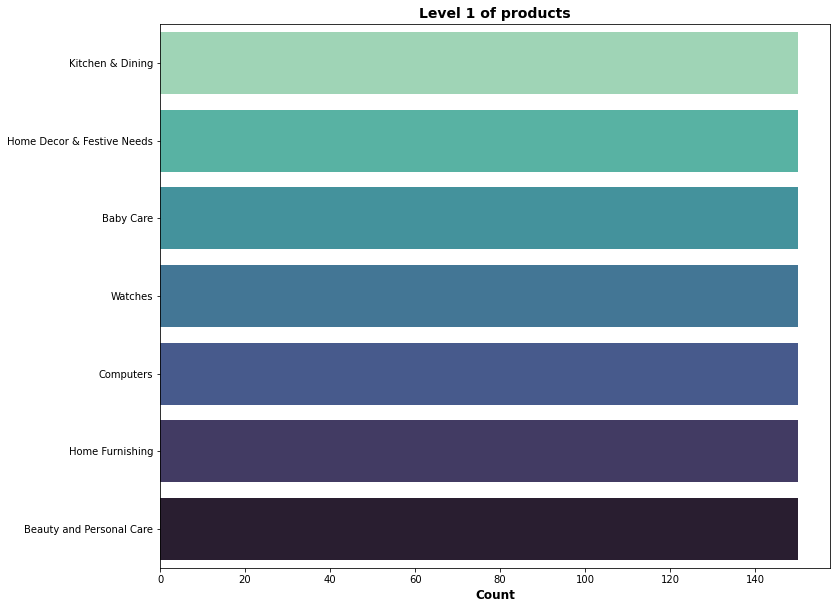

Level 1 contains 7 categories of products, number of products per category:
Kitchen & Dining              150
Home Decor & Festive Needs    150
Baby Care                     150
Watches                       150
Computers                     150
Home Furnishing               150
Beauty and Personal Care      150
Name: prod_category1, dtype: int64


In [4250]:
# data_cat['prod_category1'].value_counts()
fig = plt.figure(figsize=(12, 10))
ax = sns.countplot(y=data_cat['prod_category1'],
                   palette='mako_r',
                   order=data_cat['prod_category1']
                   .value_counts().index)
plt.title('Level 1 of products', weight='bold', size=14)
plt.ylabel('')
plt.xlabel('Count', weight='bold', size=12)
plt.show()
print("Level 1 contains {} categories of products,\
 number of products per category:\n{}".\
      format(data_cat["prod_category1"].nunique(),
             data_cat['prod_category1'].value_counts()))

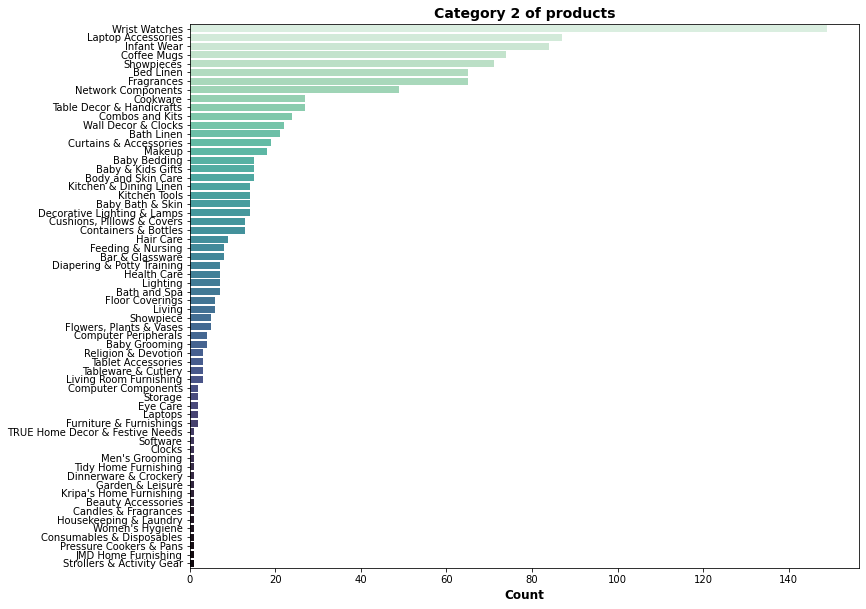

 Category 2 contains 62 different types of products,number of products by type:
Wrist Watches                149
Laptop Accessories            87
Infant Wear                   84
Coffee Mugs                   74
Showpieces                    71
                            ... 
Women's Hygiene                1
Consumables & Disposables      1
Pressure Cookers & Pans        1
JMD Home Furnishing            1
Strollers & Activity Gear      1
Name: prod_category2, Length: 62, dtype: int64


In [4251]:
# data_cat['prod_category2'].value_counts()
fig = plt.figure(figsize=(12, 10))
ax = sns.countplot(y=data_cat['prod_category2'],
                   palette='mako_r',
                   order=data_cat['prod_category2']
                   .value_counts().index)
plt.title('Category 2 of products', weight='bold', size=14)
plt.ylabel('')
plt.xlabel('Count', weight='bold', size=12)
plt.show()
print(" Category 2 contains {} different types of products,\
number of products by type:\n{}".\
      format(data_cat["prod_category2"].
             nunique(), data_cat['prod_category2'].value_counts()))

The 5th type of products only contains 50% of items with lots of types containing less than 10 items.<br>
Let's focus on Category 1.

In [4252]:
# Constitution du dataframe de travail
data_cleaned = data[['product_name', 'brand', 'image', 'product_category_tree',
                  'description', 'product_specifications', 'prod_category1']]
data_cleaned.head()

product_name                  brand  \
0  Elegance Polyester Multicolor Abstract Eyelet ...               Elegance   
1                         Sathiyas Cotton Bath Towel               Sathiyas   
2                Eurospa Cotton Terry Face Towel Set                Eurospa   
3  SANTOSH ROYAL FASHION Cotton Printed King size...  SANTOSH ROYAL FASHION   
4  Jaipur Print Cotton Floral King sized Double B...           Jaipur Print   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                              product_specifications   prod_category1  
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care  
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care  
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing

## 2. Text Pre-processing

### Tokenisation

Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords

In [4253]:
# An idea on the number of tokens in description section
data_cleaned['description_tok'] = [word_tokenize(row)
                                  for row in data_cleaned['description']]
list_all_token = []
for row in data_cleaned['description_tok']:
    list_all_token.extend(row)
tok_nbr = len(list_all_token)
tok_nbr_unique = len(set(list_all_token))
display(f'Total number of tokens in the description section : {tok_nbr}')
display(f'Number of unique tokens in the description section : {tok_nbr_unique}')

'Total number of tokens in the description section : 91612'

'Number of unique tokens in the description section : 8167'

In order to better understand the pre-processing phase and before applying it to the whole 'description' section, we take the product number 2 as an example and apply successively our cleaning phases.

### Original description

In [4254]:
# Exemple of product number 2
test = data_cleaned['description'].loc[2]
test

'Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model N

In [4255]:
test_bis = data_cleaned['product_specifications'].loc[2]
test_bis

'{"product_specification"=>[{"key"=>"Material", "value"=>"Cotton Terry"}, {"key"=>"Design", "value"=>"SHUVAM"}, {"key"=>"Brand", "value"=>"Eurospa"}, {"key"=>"GSM", "value"=>"360"}, {"key"=>"Type", "value"=>"Face Towel Set"}, {"key"=>"Model Name", "value"=>"SHUVAM20PCFTSETASSORTED"}, {"key"=>"Ideal For", "value"=>"Boys, Girls, Men, Women"}, {"key"=>"Model ID", "value"=>"SHUVAM20PCFTSETASSORTED"}, {"key"=>"Size", "value"=>"small"}, {"key"=>"Color", "value"=>"Assorted"}, {"key"=>"Weight", "value"=>"350 g"}, {"key"=>"Length", "value"=>"9 inch"}, {"key"=>"Width", "value"=>"9 inch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"20"}, {"key"=>"Sales Package", "value"=>"20 PIECE FACE TOWEL SET"}]}'

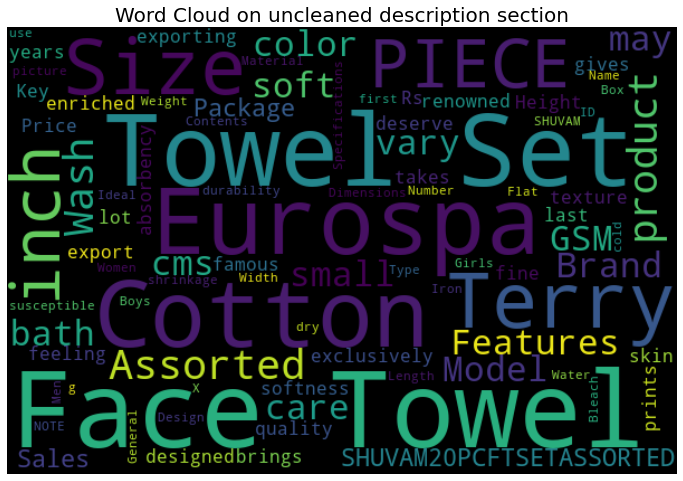

In [4256]:
cloud=WordCloud(width=600,height=400).generate(str(data_cleaned["description"].loc[2]))
fig=plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("Word Cloud on uncleaned description section", size = 20)
plt.show()

### Tokenisation

#### Description

In [4257]:
# Tokenisation on product number 2
tokens = wordpunct_tokenize(test)
print(tokens[:50])

['Key', 'Features', 'of', 'Eurospa', 'Cotton', 'Terry', 'Face', 'Towel', 'Set', 'Size', ':', 'small', 'Height', ':', '9', 'inch', 'GSM', ':', '360', ',', 'Eurospa', 'Cotton', 'Terry', 'Face', 'Towel', 'Set', '(', '20', 'PIECE', 'FACE', 'TOWEL', 'SET', ',', 'Assorted', ')', 'Price', ':', 'Rs', '.', '299', 'Eurospa', 'brings', 'to', 'you', 'an', 'exclusively', 'designed', ',', '100', '%']


#### Product specifications

In [4258]:
tokens_bis = wordpunct_tokenize(test_bis)
print(tokens_bis[:50])

['{"', 'product_specification', '"=>[{"', 'key', '"=>"', 'Material', '",', '"', 'value', '"=>"', 'Cotton', 'Terry', '"},', '{"', 'key', '"=>"', 'Design', '",', '"', 'value', '"=>"', 'SHUVAM', '"},', '{"', 'key', '"=>"', 'Brand', '",', '"', 'value', '"=>"', 'Eurospa', '"},', '{"', 'key', '"=>"', 'GSM', '",', '"', 'value', '"=>"', '360', '"},', '{"', 'key', '"=>"', 'Type', '",', '"', 'value']


### Conversion to lower case

#### Description

In [4259]:
# convert to lower case
tokens = [w.lower() for w in tokens]
print(tokens[:50])

['key', 'features', 'of', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', 'size', ':', 'small', 'height', ':', '9', 'inch', 'gsm', ':', '360', ',', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', '(', '20', 'piece', 'face', 'towel', 'set', ',', 'assorted', ')', 'price', ':', 'rs', '.', '299', 'eurospa', 'brings', 'to', 'you', 'an', 'exclusively', 'designed', ',', '100', '%']


#### Product specifications

In [4260]:
# convert to lower case
tokens_bis = [w.lower() for w in tokens_bis]
print(tokens_bis[:50])

['{"', 'product_specification', '"=>[{"', 'key', '"=>"', 'material', '",', '"', 'value', '"=>"', 'cotton', 'terry', '"},', '{"', 'key', '"=>"', 'design', '",', '"', 'value', '"=>"', 'shuvam', '"},', '{"', 'key', '"=>"', 'brand', '",', '"', 'value', '"=>"', 'eurospa', '"},', '{"', 'key', '"=>"', 'gsm', '",', '"', 'value', '"=>"', '360', '"},', '{"', 'key', '"=>"', 'type', '",', '"', 'value']


### Punctuation removed

#### Description

In [4261]:
# remove punctuation
table = str.maketrans('', '', string.punctuation)
punc = [w.translate(table) for w in tokens]
print(punc[:50])

['key', 'features', 'of', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', 'size', '', 'small', 'height', '', '9', 'inch', 'gsm', '', '360', '', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', '', '20', 'piece', 'face', 'towel', 'set', '', 'assorted', '', 'price', '', 'rs', '', '299', 'eurospa', 'brings', 'to', 'you', 'an', 'exclusively', 'designed', '', '100', '']


#### Product specifications

In [4262]:
# remove punctuation
table_bis = str.maketrans('', '', string.punctuation)
punc_bis = [w.translate(table_bis) for w in tokens_bis]
print(punc_bis[:50])

['', 'productspecification', '', 'key', '', 'material', '', '', 'value', '', 'cotton', 'terry', '', '', 'key', '', 'design', '', '', 'value', '', 'shuvam', '', '', 'key', '', 'brand', '', '', 'value', '', 'eurospa', '', '', 'key', '', 'gsm', '', '', 'value', '', '360', '', '', 'key', '', 'type', '', '', 'value']


### Non-Alphabetic characters removed

#### Description

In [4263]:
# remove tokens that are not alphabetic
alpha = [word for word in punc if word.isalpha()]
print(alpha[:50])

['key', 'features', 'of', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', 'size', 'small', 'height', 'inch', 'gsm', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', 'piece', 'face', 'towel', 'set', 'assorted', 'price', 'rs', 'eurospa', 'brings', 'to', 'you', 'an', 'exclusively', 'designed', 'soft', 'cotton', 'towels', 'of', 'export', 'quality', 'all', 'our', 'products', 'have', 'soft', 'texture', 'that', 'takes', 'care', 'of']


#### Product specifications

In [4264]:
# remove tokens that are not alphabetic
alpha_bis = [word for word in punc_bis if word.isalpha()]
print(alpha_bis[:50])

['productspecification', 'key', 'material', 'value', 'cotton', 'terry', 'key', 'design', 'value', 'shuvam', 'key', 'brand', 'value', 'eurospa', 'key', 'gsm', 'value', 'key', 'type', 'value', 'face', 'towel', 'set', 'key', 'model', 'name', 'value', 'key', 'ideal', 'for', 'value', 'boys', 'girls', 'men', 'women', 'key', 'model', 'id', 'value', 'key', 'size', 'value', 'small', 'key', 'color', 'value', 'assorted', 'key', 'weight', 'value']


### Stopwords removed

Stop words are words that do not provide any useful information to infer content or nature. It may be either because they don't carry any meaning (prepositions, conjunctions, etc.) or because they are too frequent.

#### Description

In [4265]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
alpha = [w for w in alpha if not w in stop_words]
print(alpha[:50])

['key', 'features', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', 'size', 'small', 'height', 'inch', 'gsm', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', 'piece', 'face', 'towel', 'set', 'assorted', 'price', 'rs', 'eurospa', 'brings', 'exclusively', 'designed', 'soft', 'cotton', 'towels', 'export', 'quality', 'products', 'soft', 'texture', 'takes', 'care', 'skin', 'gives', 'enriched', 'feeling', 'deserve', 'eurospa', 'exporting', 'bath', 'towels', 'lot']


#### Product specifications

In [4266]:
# Remove stopwords
stop_words_bis = set(stopwords.words('english'))
alpha_bis = [w for w in alpha_bis if not w in stop_words_bis]
print(alpha_bis[:50])

['productspecification', 'key', 'material', 'value', 'cotton', 'terry', 'key', 'design', 'value', 'shuvam', 'key', 'brand', 'value', 'eurospa', 'key', 'gsm', 'value', 'key', 'type', 'value', 'face', 'towel', 'set', 'key', 'model', 'name', 'value', 'key', 'ideal', 'value', 'boys', 'girls', 'men', 'women', 'key', 'model', 'id', 'value', 'key', 'size', 'value', 'small', 'key', 'color', 'value', 'assorted', 'key', 'weight', 'value', 'g']


### Lemmatization

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

#### Description

In [4267]:
# Lemmatization
alpha = [WordNetLemmatizer().lemmatize(w) for w in alpha]
print(alpha[:50])

['key', 'feature', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', 'size', 'small', 'height', 'inch', 'gsm', 'eurospa', 'cotton', 'terry', 'face', 'towel', 'set', 'piece', 'face', 'towel', 'set', 'assorted', 'price', 'r', 'eurospa', 'brings', 'exclusively', 'designed', 'soft', 'cotton', 'towel', 'export', 'quality', 'product', 'soft', 'texture', 'take', 'care', 'skin', 'give', 'enriched', 'feeling', 'deserve', 'eurospa', 'exporting', 'bath', 'towel', 'lot']


#### Product specifications

In [4268]:
# Lemmatization
alpha_bis = [WordNetLemmatizer().lemmatize(w) for w in alpha_bis]
print(alpha_bis[:50])

['productspecification', 'key', 'material', 'value', 'cotton', 'terry', 'key', 'design', 'value', 'shuvam', 'key', 'brand', 'value', 'eurospa', 'key', 'gsm', 'value', 'key', 'type', 'value', 'face', 'towel', 'set', 'key', 'model', 'name', 'value', 'key', 'ideal', 'value', 'boy', 'girl', 'men', 'woman', 'key', 'model', 'id', 'value', 'key', 'size', 'value', 'small', 'key', 'color', 'value', 'assorted', 'key', 'weight', 'value', 'g']


In [4269]:
def preprocess(text):
    words = wordpunct_tokenize(text)
    words = [w.lower() for w in words]
    words = [w.translate(table) for w in words]
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if not w in stop_words]
    words = [WordNetLemmatizer().lemmatize(w) for w in words]
    return (' '.join(words))

In [4270]:
data_cleaned['description_clean'] = data_cleaned['description'].apply(preprocess)
data_cleaned['product_specifications_clean'] = data_cleaned['product_specifications'].apply(preprocess)

data_cleaned['description_clean']

0       key feature elegance polyester multicolor abst...
1       specification sathiyas cotton bath towel bath ...
2       key feature eurospa cotton terry face towel se...
3       key feature santosh royal fashion cotton print...
4       key feature jaipur print cotton floral king si...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker pack pr...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker r ...
1049    buy uberlyfe large vinyl sticker r online uber...
Name: description_clean, Length: 1050, dtype: object

In [4271]:
def wordcloud_visualization(dataframe, feature, var_hue, nbr_words):

    list_hue = dataframe[var_hue].unique().tolist()
    for cat in list_hue:
        print('Mots les plus fréquents de la catégorie : ' + cat)
        wordcloud(dataframe[dataframe[var_hue] == cat][feature],
                       max_words=nbr_words)
        plt.show()


In [4272]:
# wordcloud_visualization(data_cleaned, 'product_specifications_clean', 'prod_category1', 30)

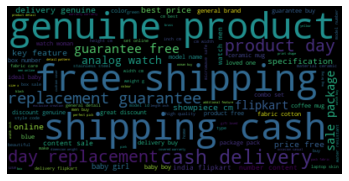

In [4273]:
# Start with one review:
text = data_cleaned # ['description_clean']

# Create and generate a word cloud image:
# wordcloud = WordCloud().generate(text)
wordcloud = WordCloud().generate(' '.join(text['description_clean']))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3. BOW - Bags of words - CountVectorizer	

#### 3.1 Section "description"

In [4274]:
# creating the feature matrix_desc 

matrix_desc = CountVectorizer(min_df=5)
X_matrix_desc = matrix_desc.fit_transform(data_cleaned['description_clean'])
X_array = X_matrix_desc.toarray()
df_countvect_desc = pd.DataFrame(data=X_array,columns = matrix_desc.get_feature_names())
df_countvect_desc.head()

absorbent  abstract  ac  accessory  actual  adapter  add  addition  \
0          0         4   0          0       0        0    0         0   
1          0         0   0          0       0        0    0         0   
2          0         0   0          0       0        0    0         0   
3          0         0   0          0       0        0    0         0   
4          0         0   0          0       0        0    0         0   

   additional  adhesive  ...  wooden  work  working  world  would  wrap  year  \
0           0         0  ...       0     0        0      1      0     0     0   
1           0         0  ...       0     0        0      0      0     0     0   
2           0         0  ...       0     0        0      0      0     0     1   
3           0         0  ...       0     0        0      0      0     0     0   
4           0         0  ...       0     0        0      0      0     0     0   

   yellow  yes  yet  
0       0    0    0  
1       2    1    0  
2       0    0    0  
3       0    1    0  
4       0    1    0  

[5 rows x 940 columns]

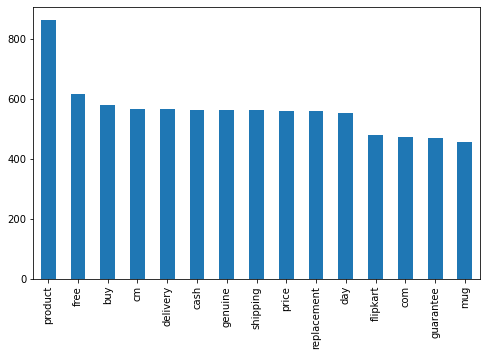

In [4275]:
df_countvect_desc.sum(axis=0).sort_values(ascending=False)[:15].plot.bar(figsize=(8,5))
plt.show()

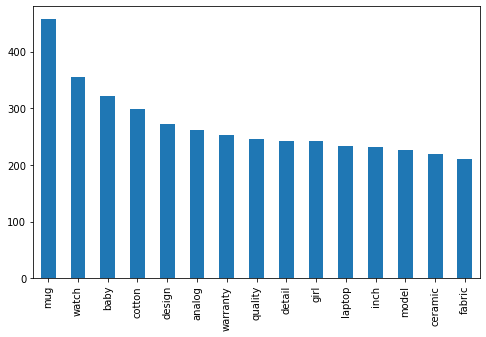

In [4276]:
# ignore words present in more than 15% of the descriptions
matrix_desc = CountVectorizer(max_df=0.15, min_df=5)
X_matrix_desc = matrix_desc.fit_transform(data_cleaned['description_clean'])
df_countvect_desc = pd.DataFrame(X_matrix_desc.toarray(), columns= matrix_desc.get_feature_names())
df_countvect_desc.sum(axis=0).sort_values(ascending=False)[:15].plot.bar(figsize=(8,5))
plt.show()

In [4277]:
# Words frequency in "description" section
text = ''
sentence = ' '.join([text + row for row in data_cleaned['description_clean']])
tokens = nltk.word_tokenize(sentence)
fdist = FreqDist(tokens)

# # Dataframe creation
df_fdist = pd.DataFrame({'word': fdist.keys(),
                                 'Frequency': fdist.values()}) \
                    .sort_values(['Frequency'], ascending=False)
nb_tot = df_fdist['Frequency'].count()
df_fdist['%_frequency'] = \
    round((df_fdist['Frequency'])*100/nb_tot, 2)

In [4278]:
df_fdist[df_fdist['%_frequency'] > 5]

word  Frequency  %_frequency
14                r        927        20.66
133         product        864        19.26
225            free        618        13.77
214             buy        581        12.95
10               cm        568        12.66
228        delivery        567        12.64
227            cash        564        12.57
226        shipping        564        12.57
221         genuine        564        12.57
13            price        561        12.50
223     replacement        559        12.46
222             day        553        12.32
217        flipkart        481        10.72
218             com        473        10.54
224       guarantee        471        10.50
676             mug        457        10.18
1           feature        404         9.00
215          online        396         8.83
83    specification        379         8.45
92            color        369         8.22
213           watch        355         7.91
87             type        325         7.24
648            baby        321         7.15
12             pack        319         7.11
101        material        313         6.98
90              set        311         6.93
103          cotton        299         6.66
95              box        297         6.62
84          general        288         6.42
42           design        273         6.08
99          package        269         6.00
212          analog        262         5.84
98             sale        262         5.84
96           number        254         5.66
200        warranty        252         5.62
20          quality        245         5.46
652          detail        243         5.42
118            girl        242         5.39
85            brand        238         5.30
2303         laptop        234         5.22
121            inch        231         5.15
461            best        230         5.13
88            model        226         5.04

### 3.1.1 TSNE

In [4279]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1500, random_state=42)
tsne_results = tsne.fit_transform(df_countvect_desc)
    
cv_tsne_desc = pd.concat([pd.DataFrame(tsne_results), data_cleaned['prod_category1']], axis=1)
cv_tsne_desc = cv_tsne_desc.rename(columns={'prod_category1':'Category'})

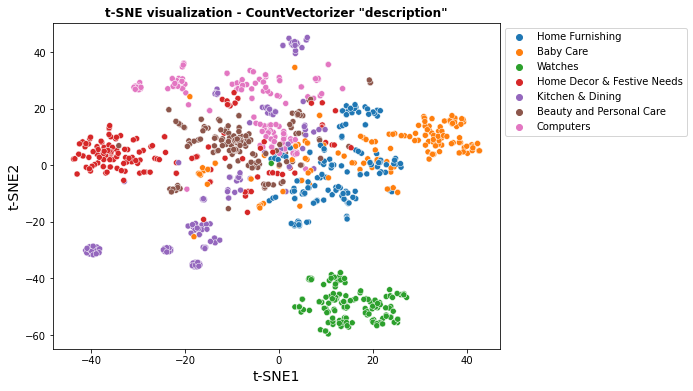

In [4280]:
title = 't-SNE visualization - CountVectorizer "description"'
tsne_visualisation(cv_tsne_desc, title)

### Clustering on t-SNE

In [4281]:
data_type = 'cv_tsne_desc'

In [4282]:
# Kmeans
tsne_cv_desc = KMeans(n_clusters=7,
                      init='k-means++',
                      random_state=42).fit(cv_tsne_desc.iloc[:, :2])
 
cv_tsne_desc['cluster'] = tsne_cv_desc.labels_
cluster_labels = tsne_cv_desc.labels_
centres_reduced = tsne_cv_desc.cluster_centers_

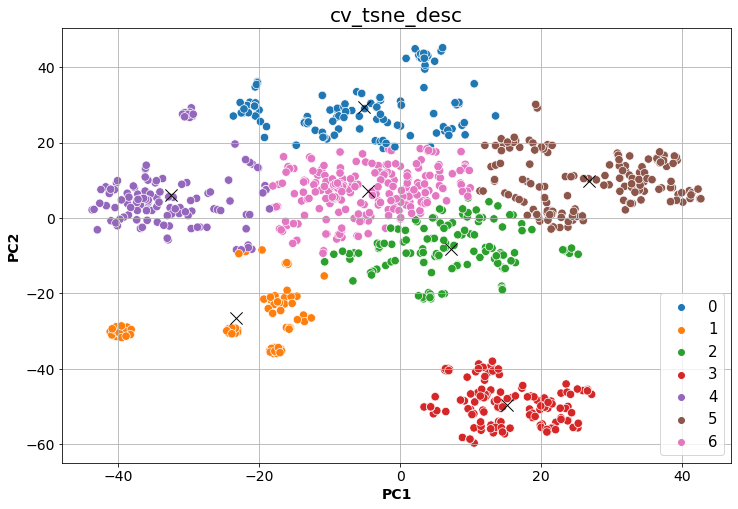

In [4283]:
display_clusters(tsne_results, cluster_labels, data_type)

Number of products per cluster:
6    243
5    166
3    149
0    137
2    136
4    134
1     85
Name: cluster, dtype: int64


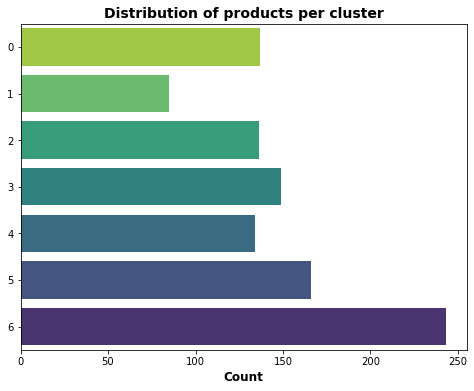

In [4284]:
cluster_distribution(cv_tsne_desc)

### Metrics evaluation for t-SNE

Regarding clustering quality measures, the following list was considered: homogeneity, completeness, adjusted Rand index,
V-measure, Fowlkes–Mallows, and AMI.<br>

The __Rand Index__ computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the __ARI__ score using the following scheme:

ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)

The adjusted Rand index is thus ensured to have a value close to 0 for random labeling independently of the number of clusters and samples and exactly 1 when the clusterings are identical (up to a permutation).

__Homogeneity__ is a material or image that is homogeneous (uniform in composition or character). While __Completeness__ is a property of a statistic in relation to a model for a set of observed data. In essence, it ensures that the distributions corresponding to different values of the parameters are distinct. In particular Rosenberg and Hirschberg (2007) define the following two desirable objectives for any cluster assignment:

homogeneity: each cluster contains only members of a single class.<br>
completeness: all members of a given class are assigned to the same cluster.<br>
Their harmonic mean is called V-measure.<br>

Adjusted mutual information (__AMI__) is a variation of mutual information and may be used for comparing clusterings. It corrects the effect of agreement solely due to chance between clusterings, similar to the way the adjusted rand index corrects the Rand index. The Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, Normalized Mutual Information (NMI) and Adjusted Mutual Information (AMI).

The __Fowlkes–Mallows__ index is an external evaluation method that is used to determine the similarity between two clusterings (clusters obtained after a clustering algorithm), and also a metric to measure confusion matrices. This measure of similarity could be either between two hierarchical clusterings or a clustering and a benchmark classification. A higher value for the Fowlkes–Mallows index indicates a greater similarity between the clusters and the benchmark classifications. The Fowlkes-Mallows index can be used when the ground truth class assignments of the samples is known. The Fowlkes-Mallows score FMI is defined as the geometric mean of the pairwise precision and recall.

In [4285]:
results11 = metrics_clusters(cv_tsne_desc, data_type)
results11.style.hide_index()

### 3.1.2 Dimension reduction - Principal Components Analysis (PCA)

Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

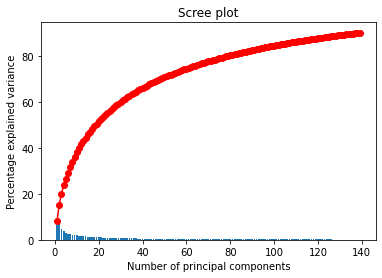

The number of principal components to keep to get 90% of the variance explained is: 139 


In [4286]:
pca = PCA(n_components = 0.90)
pca.fit(df_countvect_desc)
display_scree_plot(pca)
print("The number of principal components to keep to get 90% of the variance explained is: {} ".format(pca.n_components_))

In [4287]:
n_comp = 135
pca_cv = PCA(n_components=n_comp)
pca_cv.fit(df_countvect_desc)
X_proj_cv = pca_cv.transform(df_countvect_desc)

# Dataframe pour clustering
df_pca_cv = pd.DataFrame({'PC1': X_proj_cv[:, 0],
                          'PC2': X_proj_cv[:, 1],
                          'PC3': X_proj_cv[:, 2],
                          'Category' : data_cleaned['prod_category1']})

### 2D Visualization

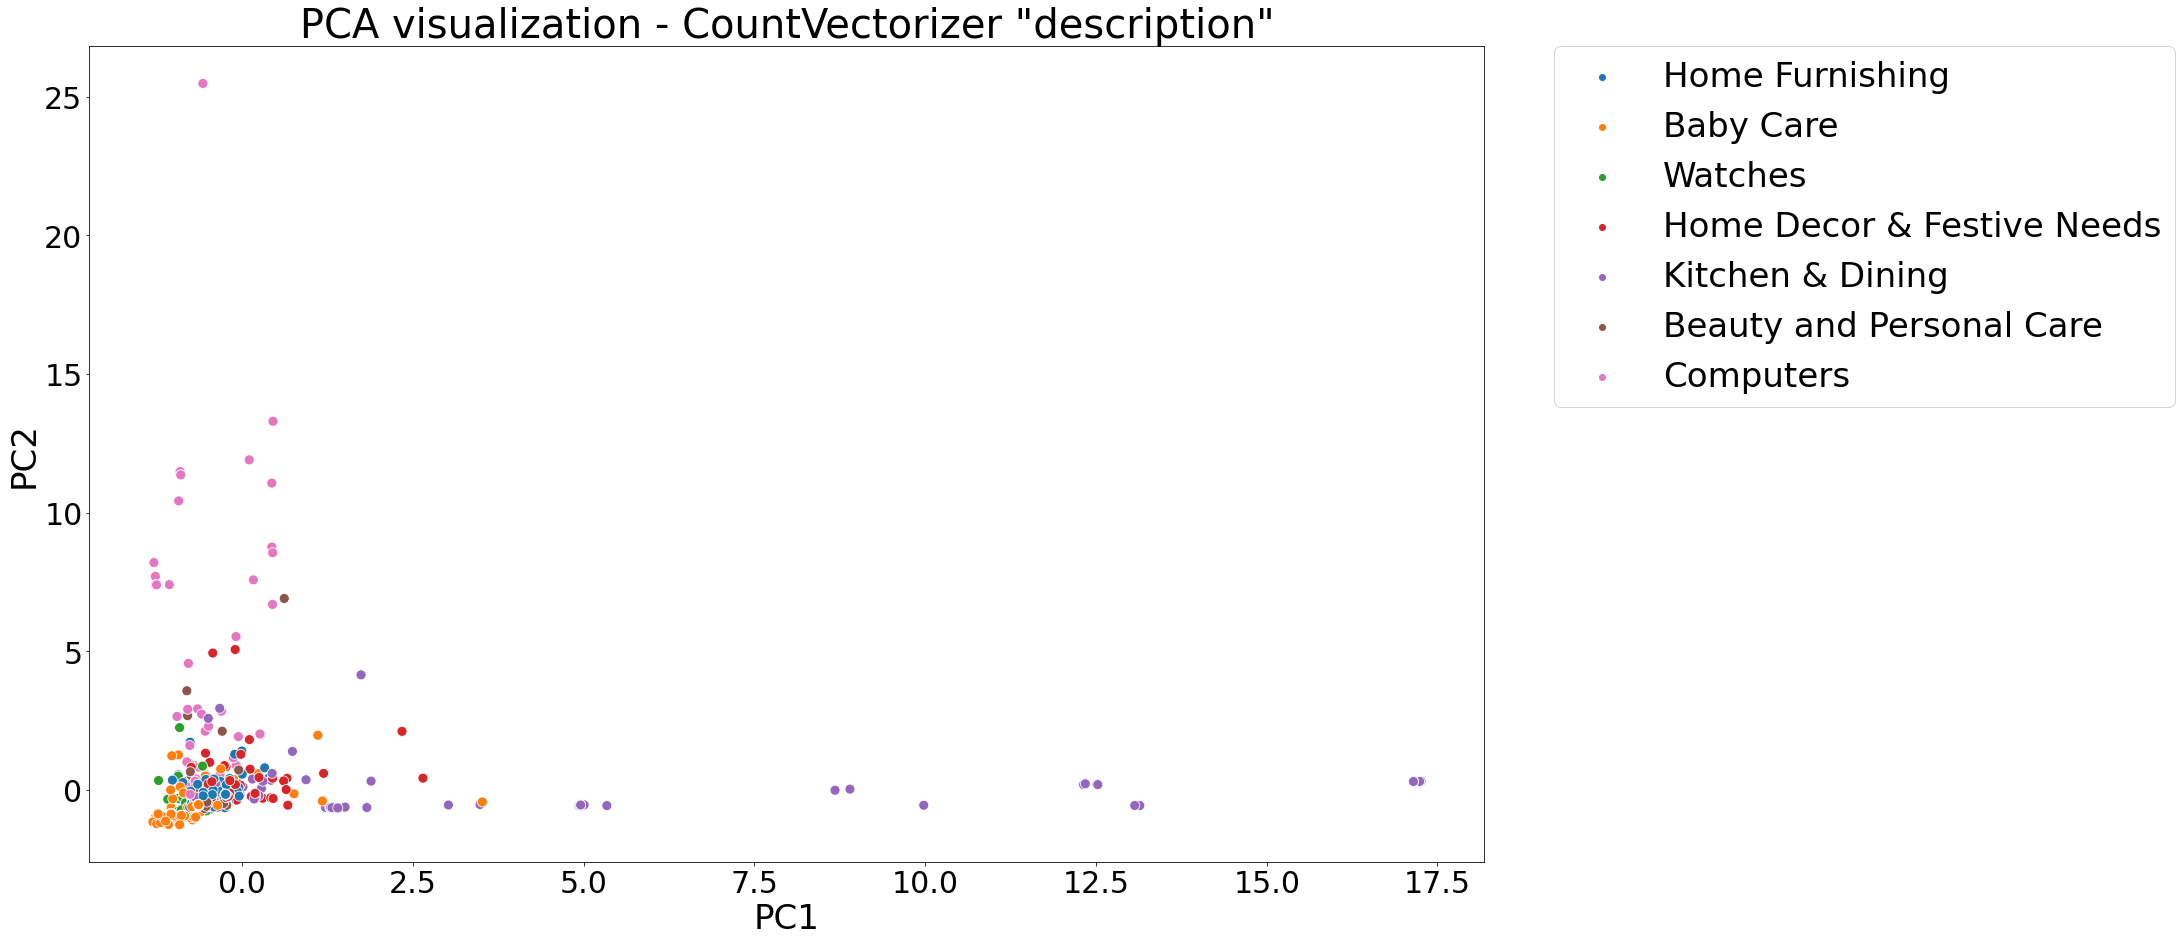

In [4288]:
# PCA visualization 
title = 'PCA visualization - CountVectorizer "description"'
pca_visualization(data_cleaned, X_proj_cv, 'PC1', 'PC2', title)

### 3D PCA model visualization 

In [4289]:
# 3d Scatter plot of categories after PCA
threed_pca(df_pca_cv)

### CountVectorizer - KMeans clustering on "description"

In [4290]:
data_type = 'cv_pca_desc'

In [4291]:
vars = ['PC1', 'PC2']
kmean = KMeans(n_clusters=7,
               init='k-means++',
               random_state=42).fit(df_pca_cv[vars])

df_pca_cv['cluster'] = kmean.labels_
cluster_labels = kmean.labels_
centres_reduced = kmean.cluster_centers_

In [4292]:
# kmeans(df_pca_cv, 7)

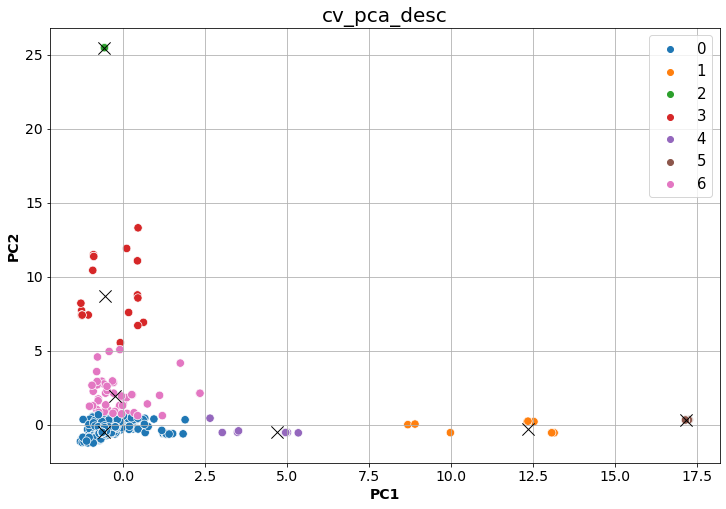

In [4293]:
display_clusters(X_proj_cv, cluster_labels, data_type)

In [4294]:
# 3d Scatter plot of clusters using K-means
threed_clustering(df_pca_cv)

Number of products per cluster:
0    907
6     57
4     26
3     23
1     20
5     11
2      6
Name: cluster, dtype: int64


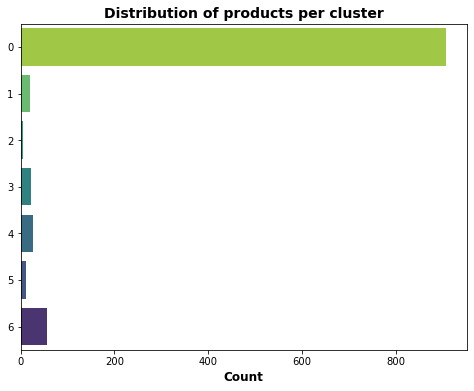

In [4295]:
cluster_distribution(df_pca_cv)

### Metrics

In [4296]:
results12 = metrics_clusters(df_pca_cv, data_type)
results1 = results11.append(results12, ignore_index=True)
results1

Methods       ARI  Homogeneity  Completness  V-Measure       AMI  \
0  cv_tsne_desc  0.434267     0.539155     0.550999   0.545013  0.540877   
1   cv_pca_desc  0.012473     0.088224     0.280233   0.134199  0.121070   

   Fowlkes-Mallows  
0         0.518467  
1         0.339468

### 3.1.3 Latent Dirichlet Allocation (LDA)

We describe latent Dirichlet allocation (LDA) as a generative probabilistic model for collections of
discrete data such as text corpora. LDA is a three-level hierarchical Bayesian model, in which each
item of a collection is modeled as a finite mixture over an underlying set of topics. Each topic is, in
turn, modeled as an infinite mixture over an underlying set of topic probabilities. In the context of
text modeling, the topic probabilities provide an explicit representation of a document.

<img src="https://miro.medium.com/max/638/0*Sj65xR38wDwuxhtr.jpg" alt="image info" />

In [4297]:
topics_name = ["Topic" + str(i) for i in range(7)]

In [4298]:
data_type = 'cv_lda_desc'

In [4299]:
# Model initialisation
lda_cv_desc = LatentDirichletAllocation(n_components=7,
                                          max_iter=10,
                                          learning_method='online',
                                          learning_offset=50,
                                          random_state=42,
                                          n_jobs=-1)
# Model training
lda_cv_desc.fit(X_matrix_desc)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          n_components=7, n_jobs=-1, random_state=42)

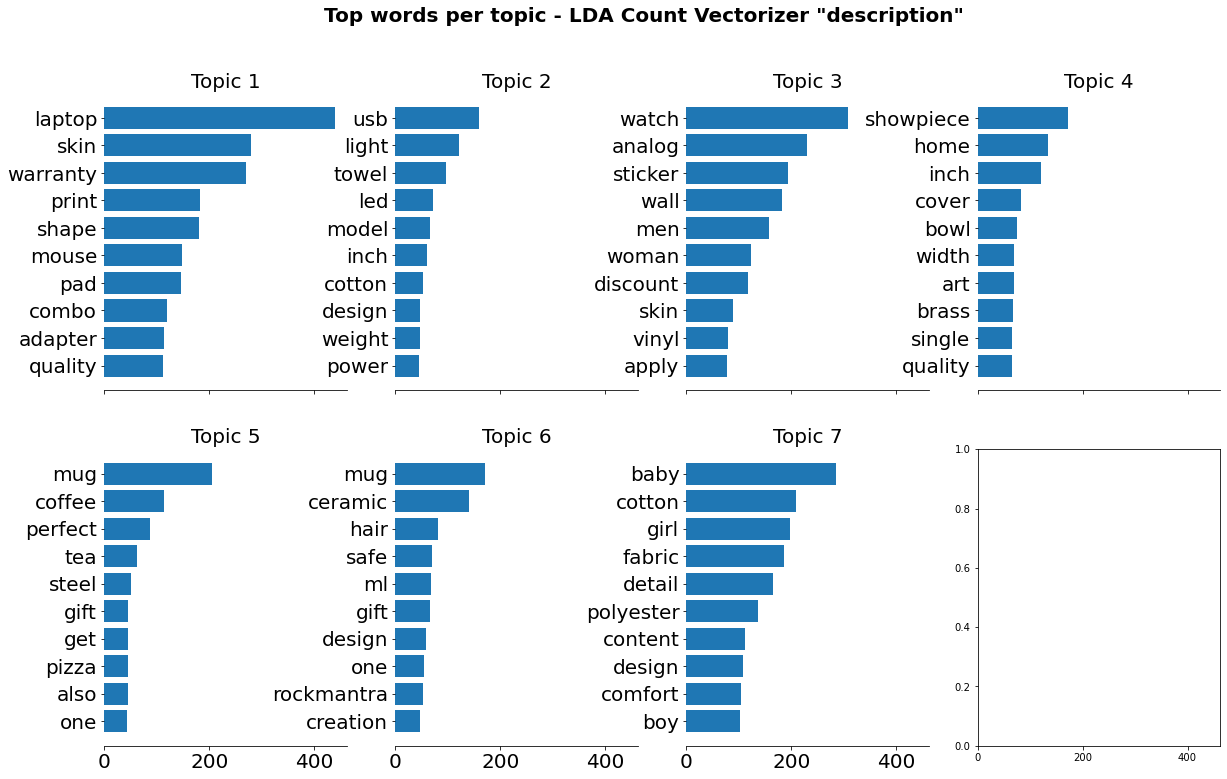

In [4300]:
# Most frequent words appearing in the different topics
n_top_words = 10
lda_cv_desc_feature_names = matrix_desc.get_feature_names()

top_words_display(lda_cv_desc, lda_cv_desc_feature_names,
                  n_top_words,
                  'Top words per topic - LDA Count Vectorizer "description"')

In [4301]:
# Descriptions
lda_cv_desc_top = lda_cv_desc.transform(X_matrix_desc)

# Dataframe creation
df_topics = pd.DataFrame(lda_cv_desc_top, columns=topics_name)

df_topics['Topics'] = np.argmax(df_topics.values, axis=1)
df_topics['Category'] = data_cleaned['prod_category1']
# Topics
df_topics.groupby('Topics')['Category'].value_counts(). \
    to_frame()

Category
Topics Category                            
0      Computers                         92
       Beauty and Personal Care          23
       Home Decor & Festive Needs         2
       Kitchen & Dining                   2
1      Computers                         49
       Home Furnishing                   37
       Baby Care                         22
       Home Decor & Festive Needs        20
       Kitchen & Dining                  15
       Beauty and Personal Care           3
       Watches                            2
2      Watches                          146
       Beauty and Personal Care          49
       Baby Care                         14
       Home Decor & Festive Needs        14
       Kitchen & Dining                   7
       Computers                          1
3      Home Decor & Festive Needs       108
       Home Furnishing                   80
       Beauty and Personal Care          45
       Kitchen & Dining                  34
       Baby Care                         13
       Watches                            1
4      Kitchen & Dining                  41
       Home Decor & Festive Needs         6
       Beauty and Personal Care           2
       Baby Care                          1
5      Kitchen & Dining                  51
       Beauty and Personal Care          14
       Baby Care                          1
       Computers                          1
6      Baby Care                         99
       Home Furnishing                   33
       Beauty and Personal Care          14
       Computers                          7
       Watches                            1

<AxesSubplot:xlabel='row_0'>

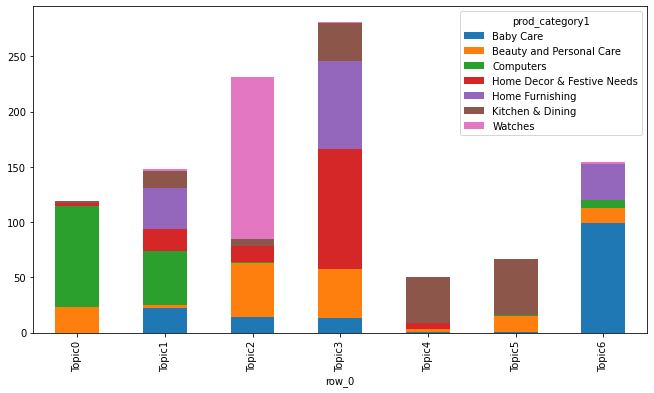

In [4302]:
lda_topic = pd.DataFrame(lda_cv_desc.transform(X_matrix_desc),
                             columns=topics_name)
lda_best_topic = lda_topic.idxmax(axis=1)
pd.crosstab(lda_best_topic, data_cleaned['prod_category1']).plot.bar(figsize=(11,6), stacked=True)

In [4303]:
results_lda_desc = metrics_clusters_lda(df_topics, data_type)
results1_ = results1.append(results_lda_desc, ignore_index=True)
results1_

Methods       ARI  Homogeneity  Completness  V-Measure       AMI  \
0  cv_tsne_desc  0.434267     0.539155     0.550999   0.545013  0.540877   
1   cv_pca_desc  0.012473     0.088224     0.280233   0.134199  0.121070   
2   cv_lda_desc  0.308110     0.410171     0.440741   0.424907  0.419528   

   Fowlkes-Mallows  
0         0.518467  
1         0.339468  
2         0.420823

### 3.2 Section "product specifications"

In [4304]:
# creating the feature matrix_spec 

matrix_spec = CountVectorizer(min_df=5)
X_matrix_spec = matrix_spec.fit_transform(data_cleaned['product_specifications_clean'])
X_array_spec = X_matrix_spec.toarray()
df_countvect_spec = pd.DataFrame(data=X_array_spec,columns = matrix_spec.get_feature_names())
df_countvect_spec.head()

absorbent  abstract  ac  access  accessory  accidental  acrylic  adapter  \
0          0         1   0       0          0           0        0        0   
1          0         0   0       0          0           0        0        0   
2          0         0   0       0          0           0        0        0   
3          0         0   0       0          0           0        0        0   
4          0         0   0       0          0           0        0        0   

   adaptor  address  ...  wool  wpa  wps  wrap  wrapper  xp  year  yellow  \
0        0        0  ...     0    0    0     0        0   0     0       0   
1        0        0  ...     0    0    0     0        0   0     0       1   
2        0        0  ...     0    0    0     0        0   0     0       0   
3        0        0  ...     0    0    0     0        0   0     0       0   
4        0        0  ...     0    0    0     0        0   0     0       0   

   yes  zipper  
0    0       0  
1    1       0  
2    0       0  
3    1       0  
4    1       0  

[5 rows x 741 columns]

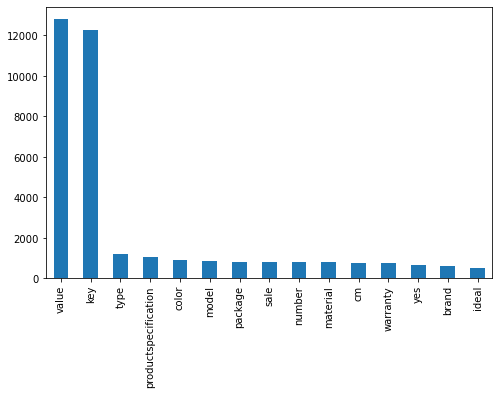

In [4305]:
df_countvect_spec.sum(axis=0).sort_values(ascending=False)[:15].plot.bar(figsize=(8,5))
plt.show()

In [4306]:
# Words frequency in "description" section
text = ''
sentence = ' '.join([text + row for row in data_cleaned['product_specifications_clean']])
tokens = nltk.word_tokenize(sentence)
fdist = FreqDist(tokens)
# Constitution du dataframe de travail
df_word_frequency = pd.DataFrame({'Word': fdist.keys(),
                                 'Frequency': fdist.values()}) \
                    .sort_values(['Frequency'], ascending=False)
nb_tot = df_word_frequency['Frequency'].count()
df_word_frequency['%_frequency'] = \
    round((df_word_frequency['Frequency'])*100/nb_tot, 2)

In [4307]:
df_word_frequency[df_word_frequency['%_frequency'] > 5]

Word  Frequency  %_frequency
3                   value      12786       395.85
1                     key      12289       380.46
7                    type       1182        36.59
0    productspecification       1049        32.48
16                  color        898        27.80
9                   model        837        25.91
23                package        810        25.08
22                   sale        808        25.02
20                 number        806        24.95
25               material        800        24.77
19                     cm        767        23.75
112              warranty        744        23.03
28                    yes        638        19.75
2                   brand        606        18.76
36                  ideal        499        15.45
21                content        497        15.39
116                 strap        482        14.92
47                  width        447        13.84
136                    mm        395        12.23
24                   pack        382        11.83
10                   name        351        10.87
55                      g        348        10.77
54                 weight        347        10.74
46                   inch        340        10.53
113                  dial        327        10.12
176                height        317         9.81
14                    set        279         8.64
37                    men        272         8.42
108                  code        257         7.96
18                 length        230         7.12
107                 style        225         6.97
15                     id        225         6.97
120                 water        224         6.93
29                 cotton        221         6.84
30                 design        220         6.81
526                   mug        220         6.81
119             resistant        218         6.75
111                  year        212         6.56
38                  woman        210         6.50
85                product        207         6.41
155                 black        207         6.41
114                 shape        201         6.22
77                  depth        200         6.19
131               feature        197         6.10
539               covered        194         6.01
44                   size        183         5.67
468                    ml        179         5.54
126                 power        176         5.45
491                  safe        167         5.17
140                   box        164         5.08

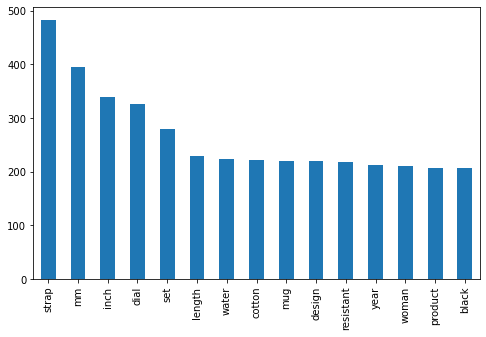

In [4308]:
# creating the feature matrix_spec 

matrix_spec = CountVectorizer(min_df=5, max_df=200)
X_matrix_spec = matrix_spec.fit_transform(data_cleaned['product_specifications_clean'])
X_array_spec = X_matrix_spec.toarray()
df_countvect_spec = pd.DataFrame(data=X_array_spec,columns = matrix_spec.get_feature_names())
df_countvect_spec.sum(axis=0).sort_values(ascending=False)[:15].plot.bar(figsize=(8,5))
plt.show()

### 3.2.1 t-SNE Visualization on "product specifications"

In [4309]:
tsne_results = tsne.fit_transform(df_countvect_spec)
    
cv_tsne_prod_spec = pd.concat([pd.DataFrame(tsne_results), data_cleaned['prod_category1']], axis=1)
cv_tsne_prod_spec = cv_tsne_prod_spec.rename(columns={'prod_category1':'Category'})

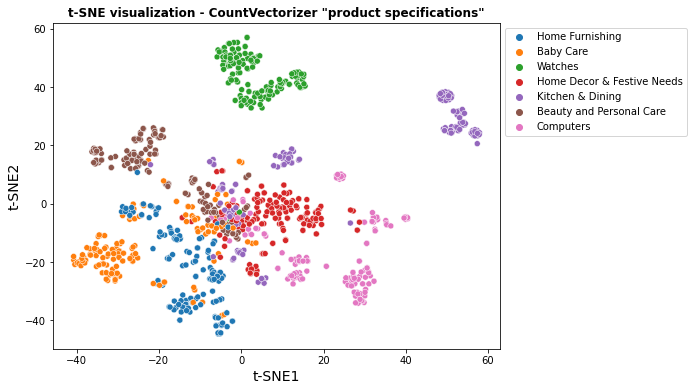

In [4310]:
title = 't-SNE visualization - CountVectorizer "product specifications"'
tsne_visualisation(cv_tsne_prod_spec, title)

### t-SNE clustering

In [4311]:
data_type = 'cv_tsne_prod_spec'

In [4312]:
# Kmeans
tsne_cv_prod_spec = KMeans(n_clusters=7,
                      init='k-means++',
                      random_state=42).fit(cv_tsne_prod_spec.iloc[:, :2])
 
cv_tsne_prod_spec['cluster'] = tsne_cv_prod_spec.labels_
cluster_labels = tsne_cv_prod_spec.labels_
centres_reduced = tsne_cv_prod_spec.cluster_centers_

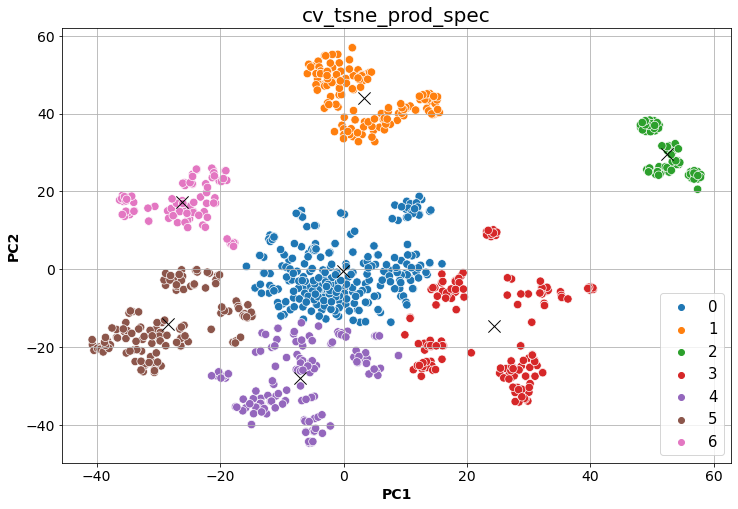

In [4313]:
display_clusters(tsne_results, cluster_labels, data_type)

Number of products per cluster:
0    279
3    162
4    151
1    144
5    139
6    101
2     74
Name: cluster, dtype: int64


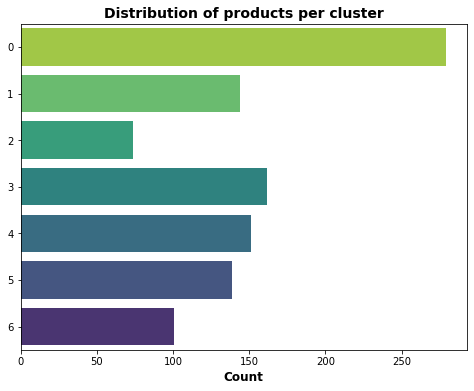

In [4314]:
cluster_distribution(cv_tsne_prod_spec)

In [4315]:
results13 = metrics_clusters(cv_tsne_prod_spec, data_type)
results1_3 = results1_.append(results13, ignore_index=True)
results1_3

Methods       ARI  Homogeneity  Completness  V-Measure       AMI  \
0       cv_tsne_desc  0.434267     0.539155     0.550999   0.545013  0.540877   
1        cv_pca_desc  0.012473     0.088224     0.280233   0.134199  0.121070   
2        cv_lda_desc  0.308110     0.410171     0.440741   0.424907  0.419528   
3  cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441  0.603839   

   Fowlkes-Mallows  
0         0.518467  
1         0.339468  
2         0.420823  
3         0.537371

### 3.2.2 PCA - Dimension reduction

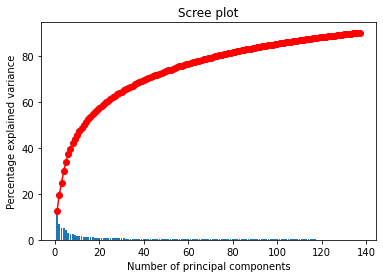

The number of principal components to keep to get 90% of the variance explained is: 137 


In [4316]:
pca = PCA(n_components = 0.90)
pca.fit(df_countvect_spec)
display_scree_plot(pca)
print("The number of principal components to keep to get 90% of the variance explained is: {} ".format(pca.n_components_))

In [4317]:
n_comp = pca.n_components_
pca_cv_spec = PCA(n_components=n_comp)
pca_cv_spec.fit(df_countvect_spec)
X_proj_cv_spec = pca_cv_spec.transform(df_countvect_spec)
# Dataframe pour clustering

df_pca_cv_spec = pd.DataFrame({'PC1': X_proj_cv_spec[:, 0],
                               'PC2': X_proj_cv_spec[:, 1],
                               'PC3': X_proj_cv_spec[:, 2],
                               'Category' : data_cleaned['prod_category1']})

### 2D PCA visualization

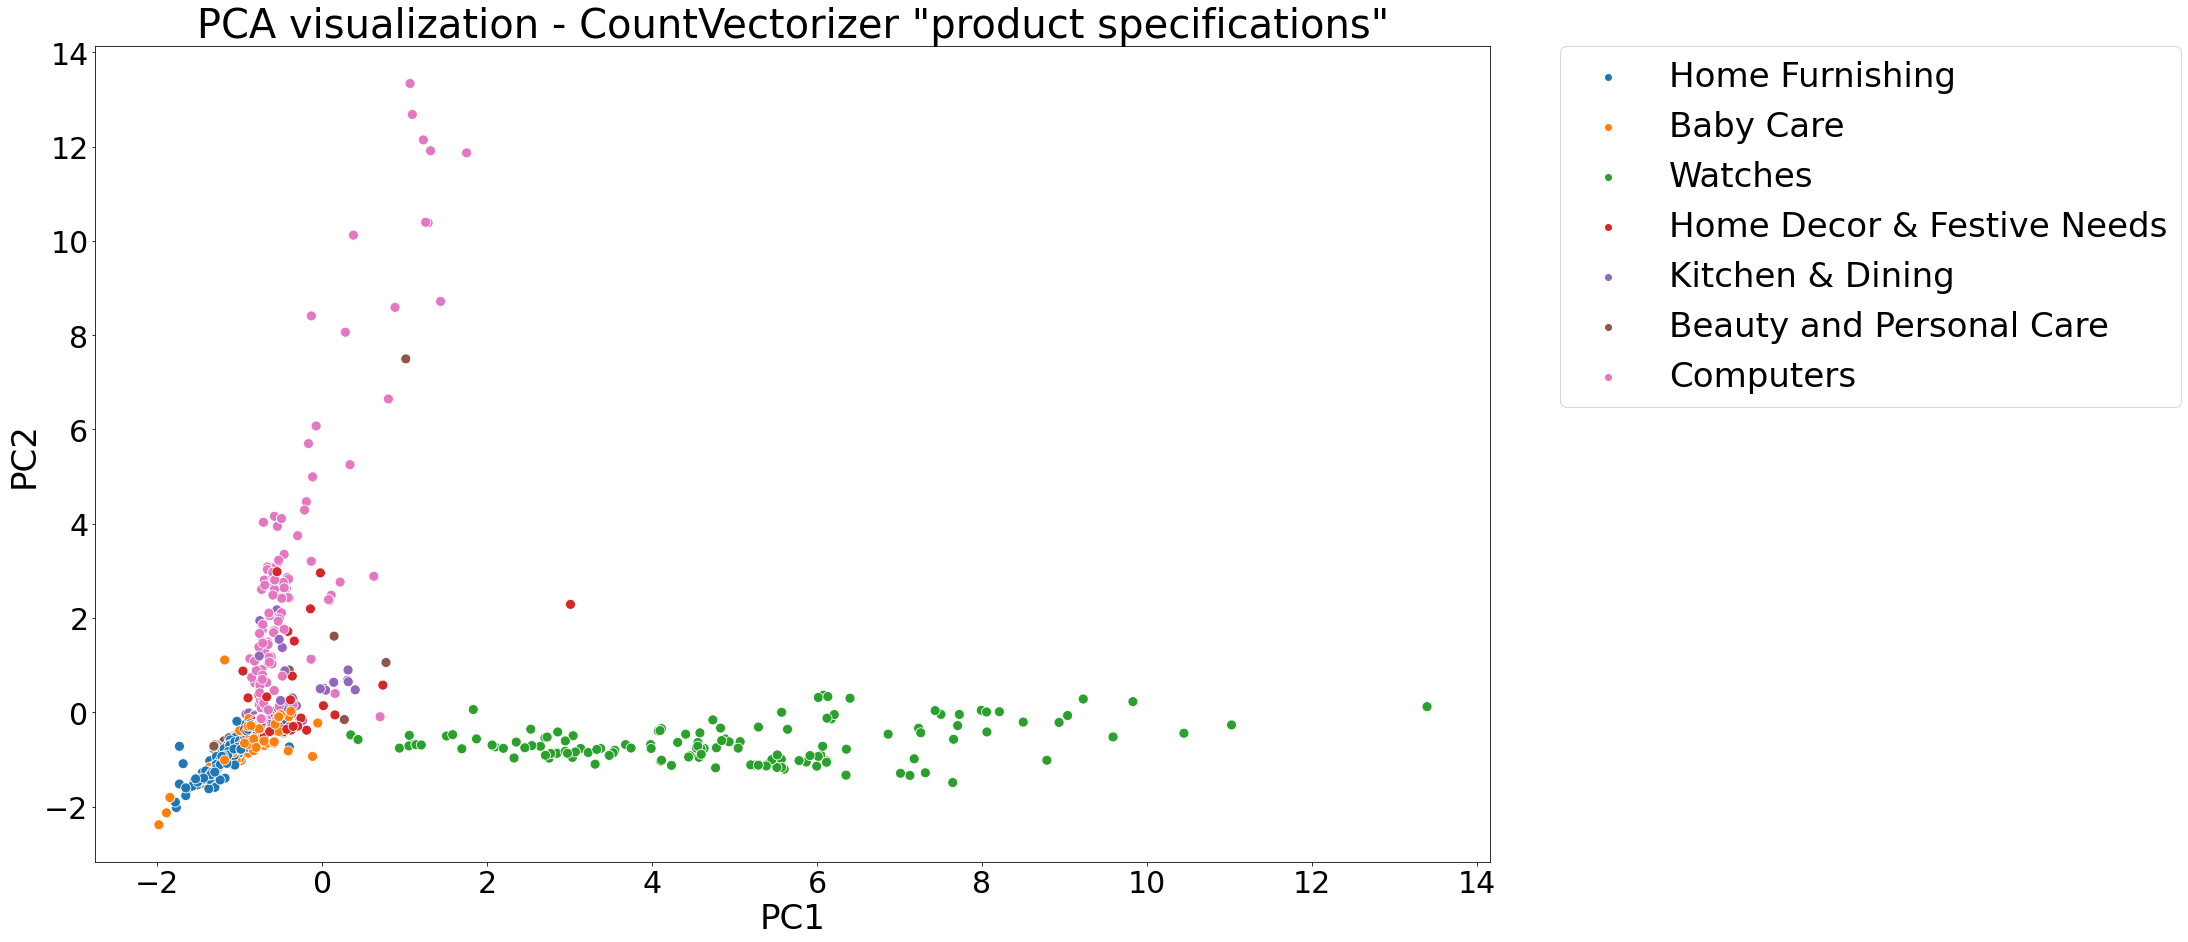

In [4318]:
# PCA visualization 
title = 'PCA visualization - CountVectorizer "product specifications"'
pca_visualization(data_cleaned, X_proj_cv_spec, 'PC1', 'PC2', title)

### 3D PCA Visualization

In [4319]:
# 3d Scatter plot of categories after PCA
threed_pca(df_pca_cv_spec)

### KMeans on CounterVectorizer "product specifications"¶

In [4320]:
data_type = 'cv_pca_prod_spec'

In [4321]:
vars = ['PC1', 'PC2']
kmean = KMeans(n_clusters=7,
               init='k-means++',
               random_state=42).fit(df_pca_cv_spec[vars])

df_pca_cv_spec['cluster'] = kmean.labels_
cluster_labels = kmean.labels_
centres_reduced = kmean.cluster_centers_
# kmeans(df_pca_cv_spec, 7)

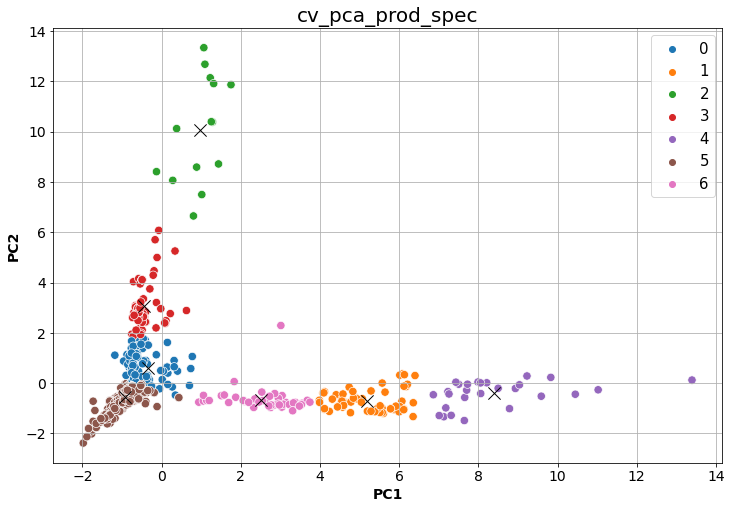

In [4322]:
display_clusters(X_proj_cv_spec, cluster_labels, data_type)

In [4323]:
# 3d Scatter plot of clusters using K-means
threed_clustering(df_pca_cv_spec)

Number of products per cluster:
5    667
0    151
3     75
1     66
6     50
4     27
2     14
Name: cluster, dtype: int64


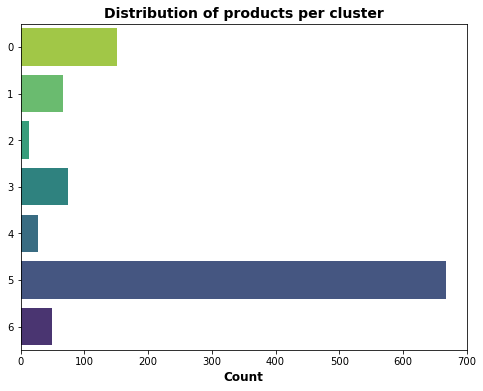

In [4324]:
cluster_distribution(df_pca_cv_spec)

### Clustering metrics

In [4325]:
results14 = metrics_clusters(df_pca_cv_spec, data_type)
results1_4 = results1_3.append(results14, ignore_index=True)
results1_4

Methods       ARI  Homogeneity  Completness  V-Measure       AMI  \
0       cv_tsne_desc  0.434267     0.539155     0.550999   0.545013  0.540877   
1        cv_pca_desc  0.012473     0.088224     0.280233   0.134199  0.121070   
2        cv_lda_desc  0.308110     0.410171     0.440741   0.424907  0.419528   
3  cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441  0.603839   
4   cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979  0.415325   

   Fowlkes-Mallows  
0         0.518467  
1         0.339468  
2         0.420823  
3         0.537371  
4         0.392403

### 3.2.3 LDA

In [4326]:
data_type = 'cv_lda_prod_spec'

In [4327]:
# Instanciation du modèle
lda_cv_spec = LatentDirichletAllocation(n_components=7,
                                          max_iter=10,
                                          learning_method='online',
                                          learning_offset=50,
                                          random_state=42,
                                          n_jobs=-1)
# Entraînement du modèle
lda_cv_spec.fit(X_matrix_spec)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          n_components=7, n_jobs=-1, random_state=42)

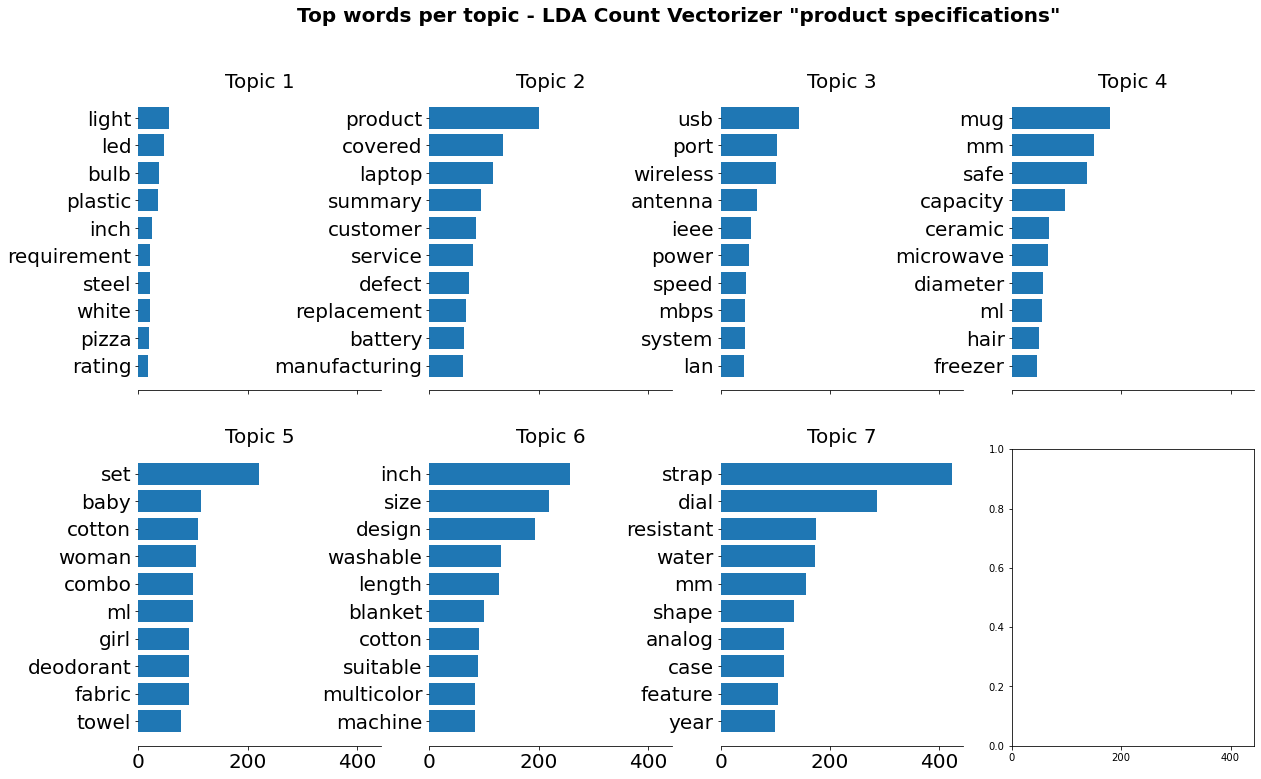

In [4328]:
# Most frequent words appearing in the different topics
n_top_words = 10
lda_cv_spec_feature_names = matrix_spec.get_feature_names()

top_words_display(lda_cv_spec, lda_cv_spec_feature_names,
                  n_top_words,
                  'Top words per topic - LDA Count Vectorizer "product specifications"')

In [4329]:
# Descriptions
lda_cv_spec_top = lda_cv_spec.transform(X_matrix_spec)

# Dataframe creation
df_topics = pd.DataFrame(lda_cv_spec_top, columns=topics_name)

df_topics['Topics'] = np.argmax(df_topics.values, axis=1)
df_topics['Category'] = data_cleaned['prod_category1']
# Topics
df_topics.groupby('Topics')['Category'].value_counts(). \
    to_frame()

Category
Topics Category                            
0      Kitchen & Dining                  22
       Computers                         20
       Home Decor & Festive Needs        17
       Beauty and Personal Care          11
       Watches                            5
       Baby Care                          2
1      Computers                         51
       Home Decor & Festive Needs         8
       Baby Care                          4
       Kitchen & Dining                   4
       Beauty and Personal Care           3
2      Computers                         75
       Beauty and Personal Care           1
3      Kitchen & Dining                 109
       Beauty and Personal Care           5
       Baby Care                          3
       Home Decor & Festive Needs         2
       Computers                          1
4      Beauty and Personal Care         121
       Baby Care                        109
       Home Furnishing                   15
       Home Decor & Festive Needs        12
       Kitchen & Dining                  12
5      Home Furnishing                  135
       Baby Care                         32
       Home Decor & Festive Needs        16
       Beauty and Personal Care           4
       Computers                          2
       Kitchen & Dining                   1
6      Watches                          145
       Home Decor & Festive Needs        95
       Beauty and Personal Care           5
       Kitchen & Dining                   2
       Computers                          1

<AxesSubplot:xlabel='row_0'>

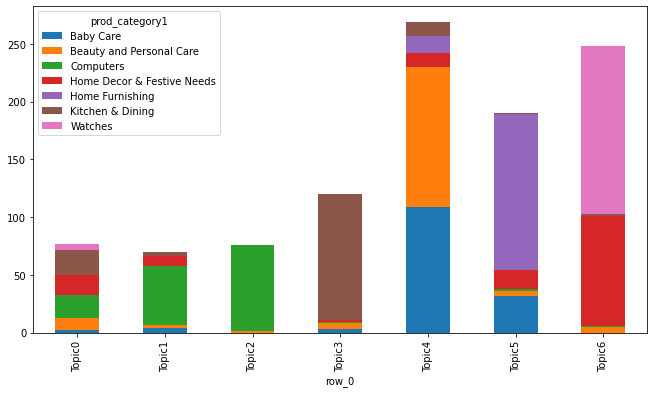

In [4330]:
lda_topic_spec = pd.DataFrame(lda_cv_spec.transform(X_matrix_spec),
                             columns=topics_name)
lda_best_topic = lda_topic_spec.idxmax(axis=1)
pd.crosstab(lda_best_topic, data_cleaned['prod_category1']).plot.bar(figsize=(11,6), stacked=True)

In [4331]:
results_lda_spec = metrics_clusters_lda(df_topics, data_type)
results1__ = results1_4.append(results_lda_spec, ignore_index=True)
results1__

Methods       ARI  Homogeneity  Completness  V-Measure       AMI  \
0       cv_tsne_desc  0.434267     0.539155     0.550999   0.545013  0.540877   
1        cv_pca_desc  0.012473     0.088224     0.280233   0.134199  0.121070   
2        cv_lda_desc  0.308110     0.410171     0.440741   0.424907  0.419528   
3  cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441  0.603839   
4   cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979  0.415325   
5   cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940  0.558853   

   Fowlkes-Mallows  
0         0.518467  
1         0.339468  
2         0.420823  
3         0.537371  
4         0.392403  
5         0.549412

### 4. BOW - Tf-idf Vectorizer

TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus.

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.

In [4332]:
# creating the feature matrix 

tfidf_desc = TfidfVectorizer(min_df=5) #, max_df=0.15)
X_tfidf_desc = tfidf_desc.fit_transform(data_cleaned['description_clean'])
X_array_tfidf_desc = X_tfidf_desc.toarray()
df_tfidf_desc = pd.DataFrame(data=X_array_tfidf_desc,
                             columns = tfidf_desc.get_feature_names())
df_tfidf_desc.head()

absorbent  abstract   ac  accessory  actual  adapter  add  addition  \
0        0.0  0.187325  0.0        0.0     0.0      0.0  0.0       0.0   
1        0.0  0.000000  0.0        0.0     0.0      0.0  0.0       0.0   
2        0.0  0.000000  0.0        0.0     0.0      0.0  0.0       0.0   
3        0.0  0.000000  0.0        0.0     0.0      0.0  0.0       0.0   
4        0.0  0.000000  0.0        0.0     0.0      0.0  0.0       0.0   

   additional  adhesive  ...  wooden  work  working     world  would  wrap  \
0         0.0       0.0  ...     0.0   0.0      0.0  0.061744    0.0   0.0   
1         0.0       0.0  ...     0.0   0.0      0.0  0.000000    0.0   0.0   
2         0.0       0.0  ...     0.0   0.0      0.0  0.000000    0.0   0.0   
3         0.0       0.0  ...     0.0   0.0      0.0  0.000000    0.0   0.0   
4         0.0       0.0  ...     0.0   0.0      0.0  0.000000    0.0   0.0   

      year    yellow       yes  yet  
0  0.00000  0.000000  0.000000  0.0  
1  0.00000  0.195986  0.076799  0.0  
2  0.04942  0.000000  0.000000  0.0  
3  0.00000  0.000000  0.043672  0.0  
4  0.00000  0.000000  0.036673  0.0  

[5 rows x 940 columns]

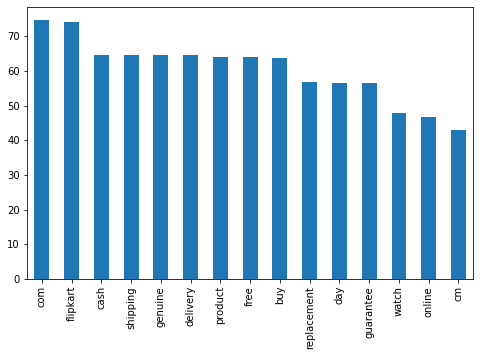

In [4333]:
df_tfidf_desc.sum(axis=0).sort_values(ascending=False)[:15].plot.bar(figsize=(8,5))
plt.show()

In [4334]:
# Words frequency in "description" section
text = ''
sentence = ' '.join([text + row for row in data_cleaned['description_clean']])
tokens = nltk.word_tokenize(sentence)
fdist = FreqDist(tokens)
# Dataframe creation
df_word_frequency = pd.DataFrame({'Word': fdist.keys(),
                                 'Frequency': fdist.values()}) \
                    .sort_values(['Frequency'], ascending=False)
nb_tot = df_word_frequency['Frequency'].count()
df_word_frequency['%_frequency'] = \
    round((df_word_frequency['Frequency'])*100/nb_tot, 2)

In [4335]:
df_word_frequency[df_word_frequency['%_frequency'] > 5]

Word  Frequency  %_frequency
14                r        927        20.66
133         product        864        19.26
225            free        618        13.77
214             buy        581        12.95
10               cm        568        12.66
228        delivery        567        12.64
227            cash        564        12.57
226        shipping        564        12.57
221         genuine        564        12.57
13            price        561        12.50
223     replacement        559        12.46
222             day        553        12.32
217        flipkart        481        10.72
218             com        473        10.54
224       guarantee        471        10.50
676             mug        457        10.18
1           feature        404         9.00
215          online        396         8.83
83    specification        379         8.45
92            color        369         8.22
213           watch        355         7.91
87             type        325         7.24
648            baby        321         7.15
12             pack        319         7.11
101        material        313         6.98
90              set        311         6.93
103          cotton        299         6.66
95              box        297         6.62
84          general        288         6.42
42           design        273         6.08
99          package        269         6.00
212          analog        262         5.84
98             sale        262         5.84
96           number        254         5.66
200        warranty        252         5.62
20          quality        245         5.46
652          detail        243         5.42
118            girl        242         5.39
85            brand        238         5.30
2303         laptop        234         5.22
121            inch        231         5.15
461            best        230         5.13
88            model        226         5.04

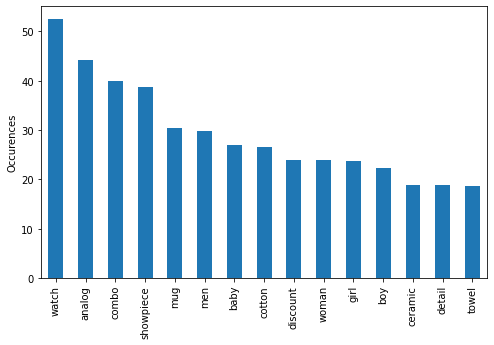

In [4336]:
# creating the feature matrix_spec 

tfidf_desc = TfidfVectorizer(min_df=5, max_df=0.15)
X_tfidf_desc = tfidf_desc.fit_transform(data_cleaned['description_clean'])
X_array_tfidf_desc = X_tfidf_desc.toarray()
df_tfidf_desc = pd.DataFrame(data=X_array_tfidf_desc,
                             columns = tfidf_desc.get_feature_names())
df_tfidf_desc.sum(axis=0).sort_values(ascending=False)[:15].plot.bar(figsize=(8,5))
plt.ylabel('Occurences')                             
plt.show()

### 4.1 t-SNE Tf-idf Vectorizer

In [4337]:
tsne_results = tsne.fit_transform(df_tfidf_desc)
    
tfidf_tsne_desc = pd.concat([pd.DataFrame(tsne_results), data_cleaned['prod_category1']], axis=1)
tfidf_tsne_desc = tfidf_tsne_desc.rename(columns={'prod_category1':'Category'})

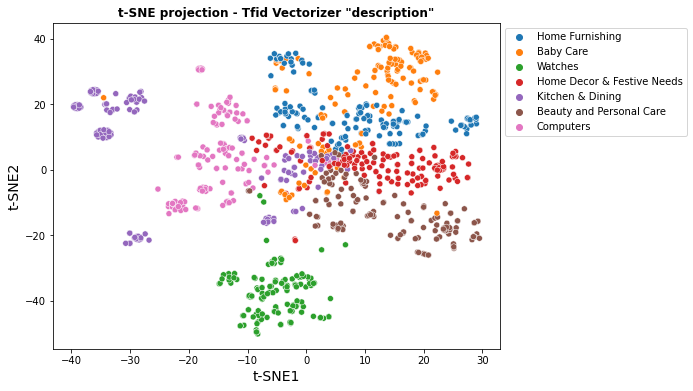

In [4338]:
title = 't-SNE projection - Tfid Vectorizer "description"'
tsne_visualisation(tfidf_tsne_desc, title)

### t-SNE clustering

In [4339]:
data_type = 'tfidf_tsne_desc'

In [4340]:
# Kmeans
tsne_tfidf_desc = KMeans(n_clusters=7,
                      init='k-means++',
                      random_state=42).fit(tfidf_tsne_desc.iloc[:, :2])
 
tfidf_tsne_desc['cluster'] = tsne_tfidf_desc.labels_
cluster_labels = tsne_tfidf_desc.labels_
centres_reduced = tsne_tfidf_desc.cluster_centers_

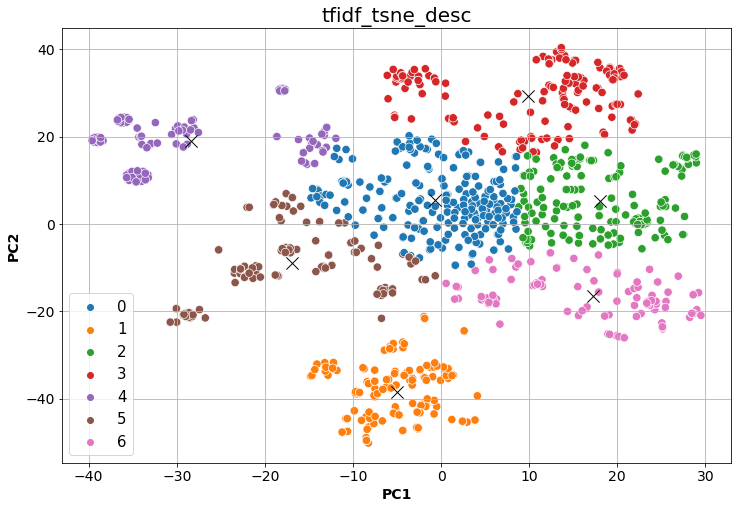

In [4341]:
display_clusters(tsne_results, cluster_labels, data_type)

Number of products per cluster:
0    236
2    165
3    154
1    149
6    120
5    119
4    107
Name: cluster, dtype: int64


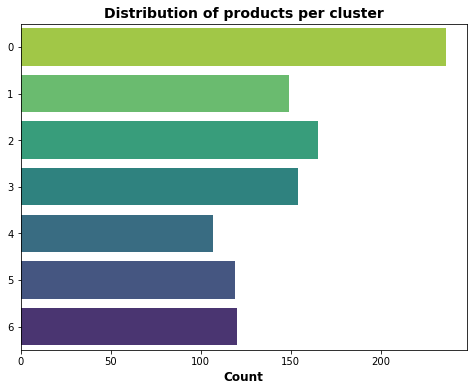

In [4342]:
cluster_distribution(tfidf_tsne_desc)

In [4343]:
results21 = metrics_clusters(tfidf_tsne_desc, data_type)
results2_1 = results1__.append(results21, ignore_index=True)
results2_1

Methods       ARI  Homogeneity  Completness  V-Measure       AMI  \
0       cv_tsne_desc  0.434267     0.539155     0.550999   0.545013  0.540877   
1        cv_pca_desc  0.012473     0.088224     0.280233   0.134199  0.121070   
2        cv_lda_desc  0.308110     0.410171     0.440741   0.424907  0.419528   
3  cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441  0.603839   
4   cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979  0.415325   
5   cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940  0.558853   
6    tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059  0.565151   

   Fowlkes-Mallows  
0         0.518467  
1         0.339468  
2         0.420823  
3         0.537371  
4         0.392403  
5         0.549412  
6         0.513588

### 4.2 Principal Components Analysis

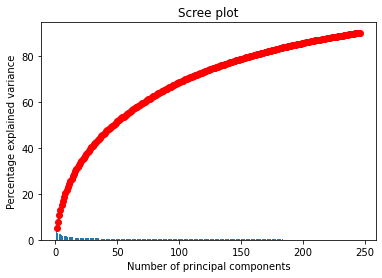

The number of principal components to keep to get 90% of the variance explained is: 246 


In [4344]:
pca = PCA(n_components = 0.90)
pca.fit(df_tfidf_desc)
display_scree_plot(pca)
print("The number of principal components to keep to get 90% of the variance explained is: {} ".format(pca.n_components_))

In [4345]:
n_comp = pca.n_components_
pca_tfidf_desc = PCA(n_components=n_comp)
pca_tfidf_desc.fit(df_tfidf_desc)
X_proj_tfidf_desc = pca_tfidf_desc.transform(df_tfidf_desc)

# Dataframe pour clustering & visualization
df_pca_tfidf_desc = pd.DataFrame({'PC1': X_proj_tfidf_desc[:, 0],
                            'PC2': X_proj_tfidf_desc[:, 1],
                            'PC3': X_proj_tfidf_desc[:, 2],
                            'Category' : data_cleaned['prod_category1']})

### 2D PCA visualization: "description"

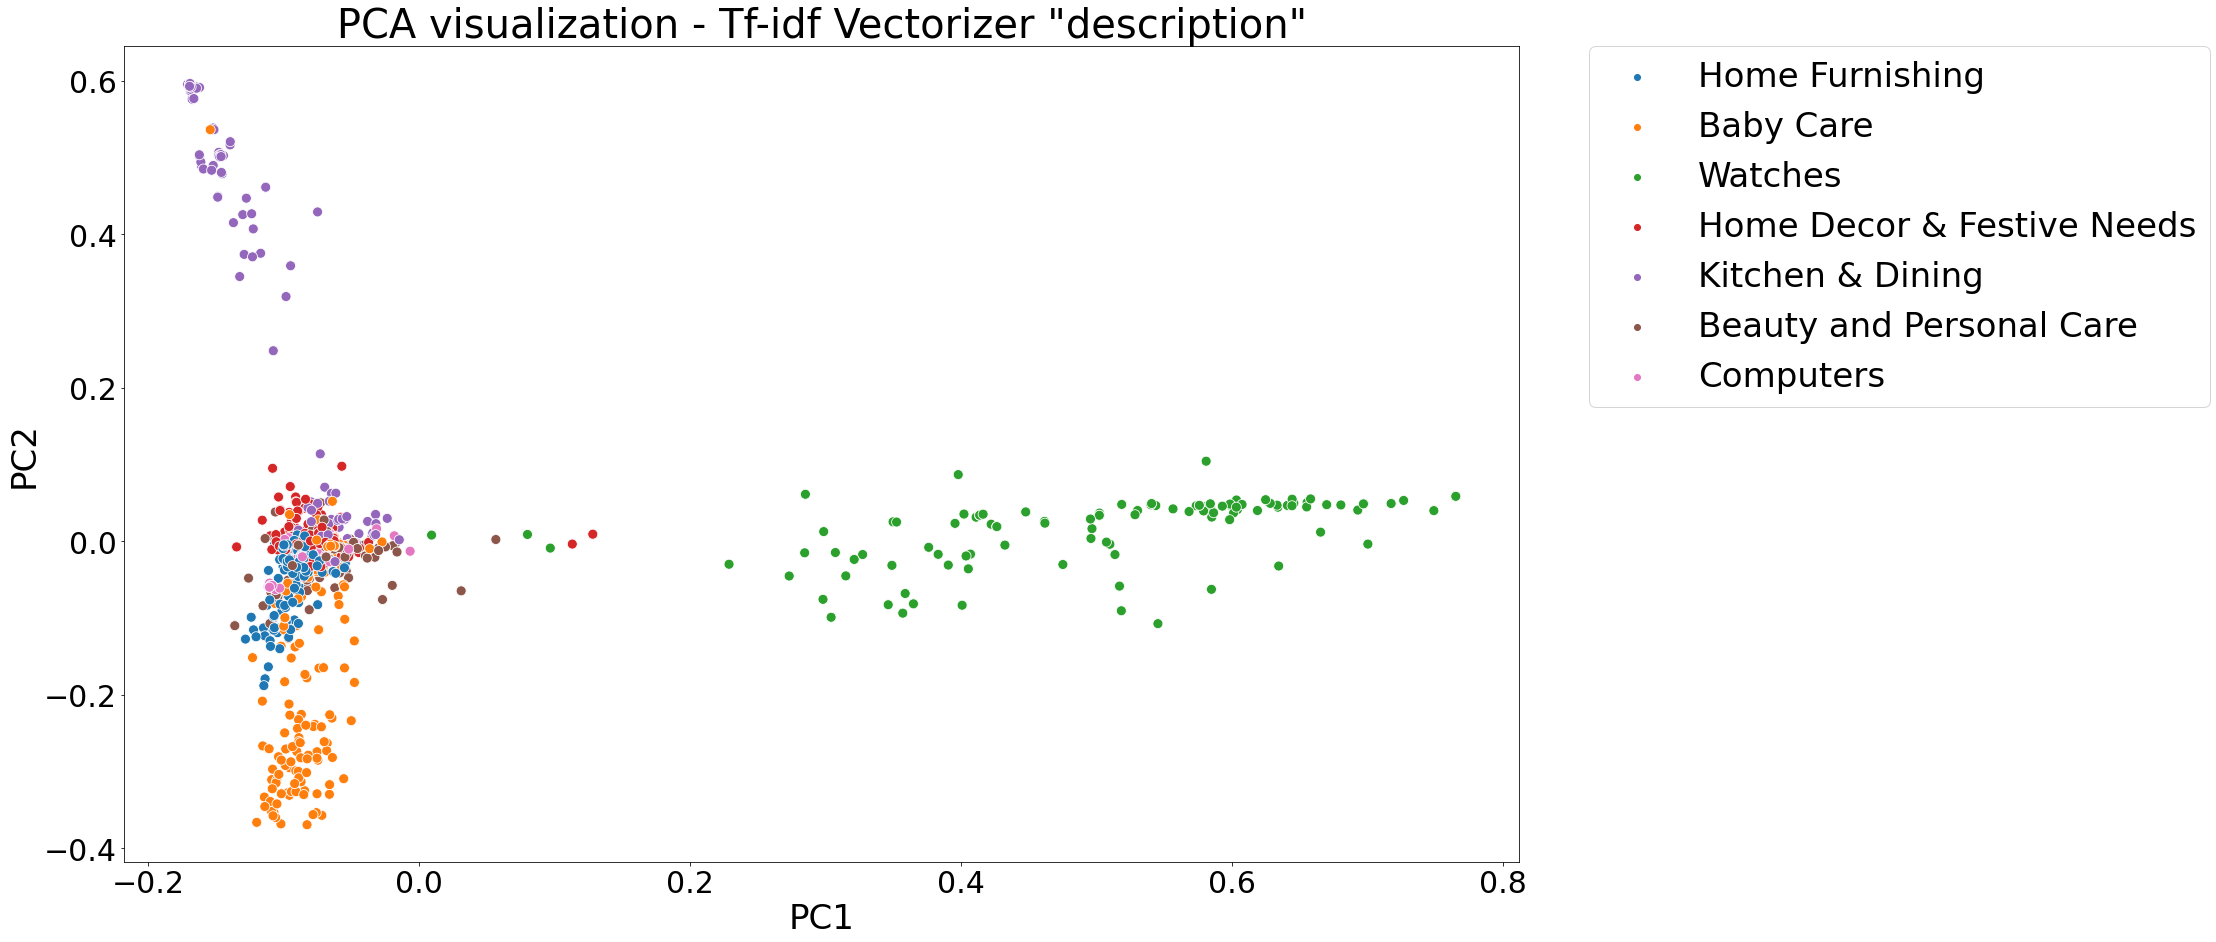

In [4346]:
# PCA Visulisation 
title = 'PCA visualization - Tf-idf Vectorizer "description"'
pca_visualization(data_cleaned, X_proj_tfidf_desc, 'PC1', 'PC2', title)

### 3D PCA visualization: "description"

In [4347]:
# 3d Scatter plot of categories after PCA
threed_pca(df_pca_tfidf_desc)

### KMeans clustering on Tf_idf Vectorizer

In [4348]:
data_type = 'tfidf_pca_desc'

In [4349]:
# Apply KMeans with optimum K
vars = ['PC1', 'PC2']
kmean = KMeans(n_clusters=7,
               init='k-means++',
               random_state=42).fit(df_pca_tfidf_desc[vars])

df_pca_tfidf_desc['cluster'] = kmean.labels_
cluster_labels = kmean.labels_
centres_reduced = kmean.cluster_centers_
# kmeans(df_pca_tfidf_desc, 7)

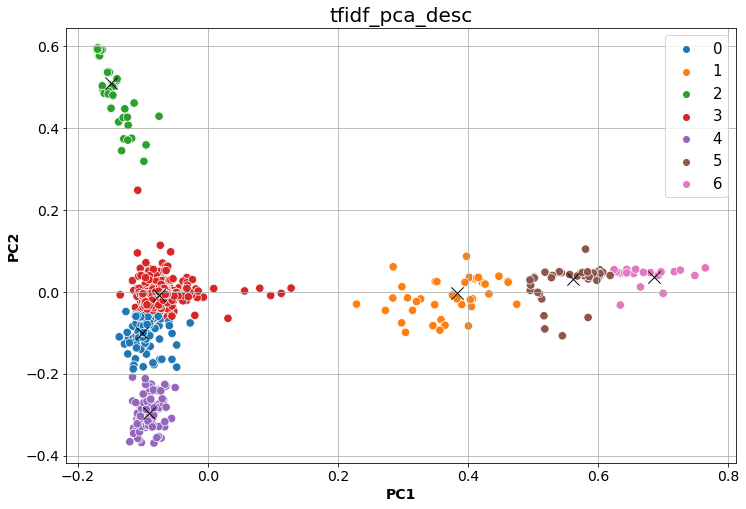

In [4350]:
display_clusters(X_proj_tfidf_desc, cluster_labels, data_type)

### KMeans 3D clustering 

In [4351]:
threed_clustering(df_pca_tfidf_desc)

Number of products per cluster:
3    616
0    137
4     76
2     74
1     55
5     54
6     38
Name: cluster, dtype: int64


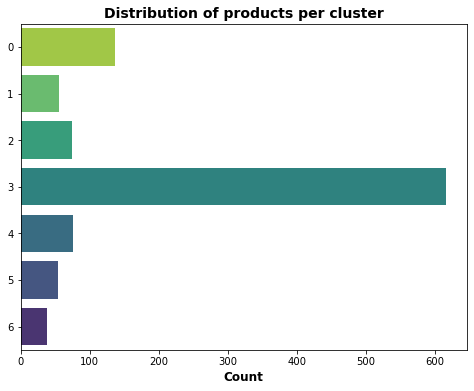

In [4352]:
cluster_distribution(df_pca_tfidf_desc)

In [4353]:
# PCA + Tf-idf Vectorizer on "description" 
results22 = metrics_clusters(df_pca_tfidf_desc, data_type)
results2_2 = results2_1.append(results22, ignore_index=True)
results2_2

Methods       ARI  Homogeneity  Completness  V-Measure       AMI  \
0       cv_tsne_desc  0.434267     0.539155     0.550999   0.545013  0.540877   
1        cv_pca_desc  0.012473     0.088224     0.280233   0.134199  0.121070   
2        cv_lda_desc  0.308110     0.410171     0.440741   0.424907  0.419528   
3  cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441  0.603839   
4   cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979  0.415325   
5   cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940  0.558853   
6    tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059  0.565151   
7     tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418  0.447585   

   Fowlkes-Mallows  
0         0.518467  
1         0.339468  
2         0.420823  
3         0.537371  
4         0.392403  
5         0.549412  
6         0.513588  
7         0.369455

### 4.3 LDA

In [4354]:
data_type = 'tfidf_lda_desc'

In [4355]:
# Instanciation du modèle
lda_tfidf_desc = LatentDirichletAllocation(n_components=7,
                                          max_iter=10,
                                          learning_method='online',
                                          learning_offset=50,
                                          random_state=42,
                                          n_jobs=-1)
# Entraînement du modèle
lda_tfidf_desc.fit(X_tfidf_desc)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          n_components=7, n_jobs=-1, random_state=42)

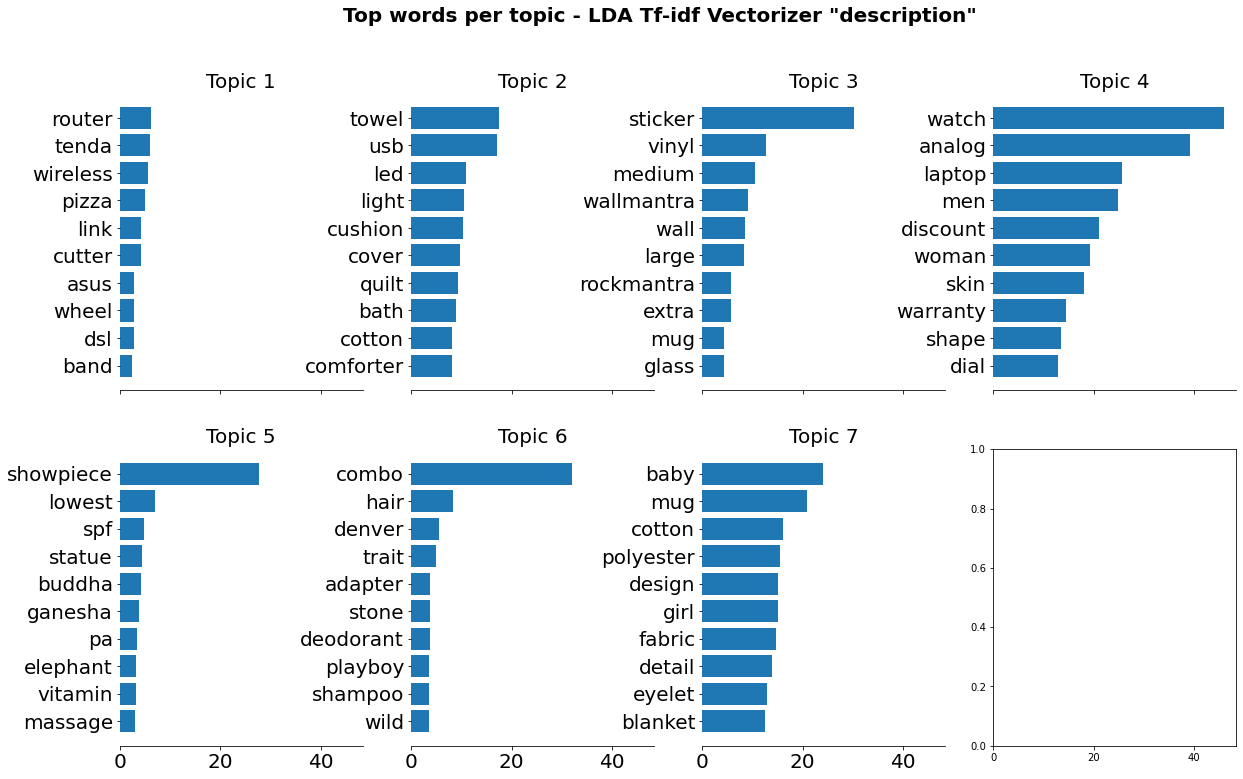

In [4356]:
# Most frequent words appearing in the different topics
n_top_words = 10
lda_tfidf_desc_feature_names = tfidf_desc.get_feature_names()

top_words_display(lda_tfidf_desc, lda_tfidf_desc_feature_names,
                  n_top_words,
                  'Top words per topic - LDA Tf-idf Vectorizer "description"')

In [4357]:
# Descriptions
lda_tfidf_desc_top = lda_tfidf_desc.transform(X_tfidf_desc)

# Dataframe creation
df_topics = pd.DataFrame(lda_tfidf_desc_top, columns=topics_name)

df_topics['Topics'] = np.argmax(df_topics.values, axis=1)
df_topics['Category'] = data_cleaned['prod_category1']
# Topics
df_topics.groupby('Topics')['Category'].value_counts(). \
    to_frame()

Category
Topics Category                            
0      Computers                         41
       Kitchen & Dining                  10
       Beauty and Personal Care           1
       Home Decor & Festive Needs         1
1      Home Furnishing                   62
       Computers                         49
       Home Decor & Festive Needs        17
       Baby Care                         13
       Kitchen & Dining                   7
2      Kitchen & Dining                  34
       Home Decor & Festive Needs        19
       Baby Care                         10
       Beauty and Personal Care           7
3      Watches                          148
       Computers                         46
       Kitchen & Dining                  20
       Home Decor & Festive Needs        10
       Beauty and Personal Care           6
       Baby Care                          1
4      Home Decor & Festive Needs        37
       Beauty and Personal Care          18
       Baby Care                          4
       Kitchen & Dining                   1
5      Beauty and Personal Care          94
       Home Decor & Festive Needs        12
       Computers                         10
       Baby Care                          4
       Kitchen & Dining                   1
6      Baby Care                        118
       Home Furnishing                   88
       Kitchen & Dining                  77
       Home Decor & Festive Needs        54
       Beauty and Personal Care          24
       Computers                          4
       Watches                            2

<AxesSubplot:xlabel='row_0'>

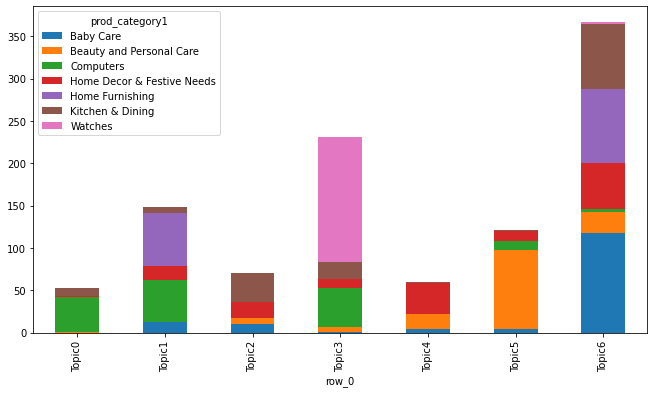

In [4358]:
lda_tfidf_topic_desc = pd.DataFrame(lda_tfidf_desc.transform(X_tfidf_desc),
                             columns=topics_name)
lda_best_topic = lda_tfidf_topic_desc.idxmax(axis=1)
pd.crosstab(lda_best_topic, data_cleaned['prod_category1']).plot.bar(figsize=(11,6), stacked=True)

In [4359]:
results_lda_desc = metrics_clusters_lda(df_topics, data_type)
results1__ = results2_2.append(results_lda_desc, ignore_index=True)
results1__

Methods       ARI  Homogeneity  Completness  V-Measure       AMI  \
0       cv_tsne_desc  0.434267     0.539155     0.550999   0.545013  0.540877   
1        cv_pca_desc  0.012473     0.088224     0.280233   0.134199  0.121070   
2        cv_lda_desc  0.308110     0.410171     0.440741   0.424907  0.419528   
3  cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441  0.603839   
4   cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979  0.415325   
5   cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940  0.558853   
6    tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059  0.565151   
7     tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418  0.447585   
8     tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115  0.384257   

   Fowlkes-Mallows  
0         0.518467  
1         0.339468  
2         0.420823  
3         0.537371  
4         0.392403  
5         0.549412  
6         0.513588  
7         0.369455  
8         0.394524

### 4.4  Negative Matrix Factorization (NMF)

Non-Negative Matrix Factorization is a state of the art feature extraction algorithm. NMF is useful when there are many attributes and the attributes are ambiguous or have weak predictability. By combining attributes, NMF can produce meaningful patterns, topics, or themes.

Each feature created by NMF is a linear combination of the original attribute set. Each feature has a set of coefficients, which are a measure of the weight of each attribute on the feature. There is a separate coefficient for each numerical attribute and for each distinct value of each categorical attribute. The coefficients are all non-negative.

Non-Negative Matrix Factorization uses techniques from multivariate analysis and linear algebra. It decomposes the data as a matrix M into the product of two lower ranking matrices W and H. The sub-matrix W contains the NMF basis; the sub-matrix H contains the associated coefficients (weights).

The algorithm iteratively modifies of the values of W and H so that their product approaches M. The technique preserves much of the structure of the original data and guarantees that both basis and weights are non-negative. The algorithm terminates when the approximation error converges or a specified number of iterations is reached.

<img src="https://miro.medium.com/max/875/1*Cdk8UXkHqkLxfPEFTNEU4A.jpeg" alt="image info" />

In [4360]:
data_type = 'nmf_tfidf_desc'

In [4361]:
# Model initialisation
nmf_desc = NMF(n_components=7,
               random_state=42,
               alpha=0.1,
               l1_ratio=0.5,
               init='nndsvd',
               solver='mu')

# Model training
nmf_desc.fit(X_tfidf_desc)

NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=7, random_state=42,
    solver='mu')

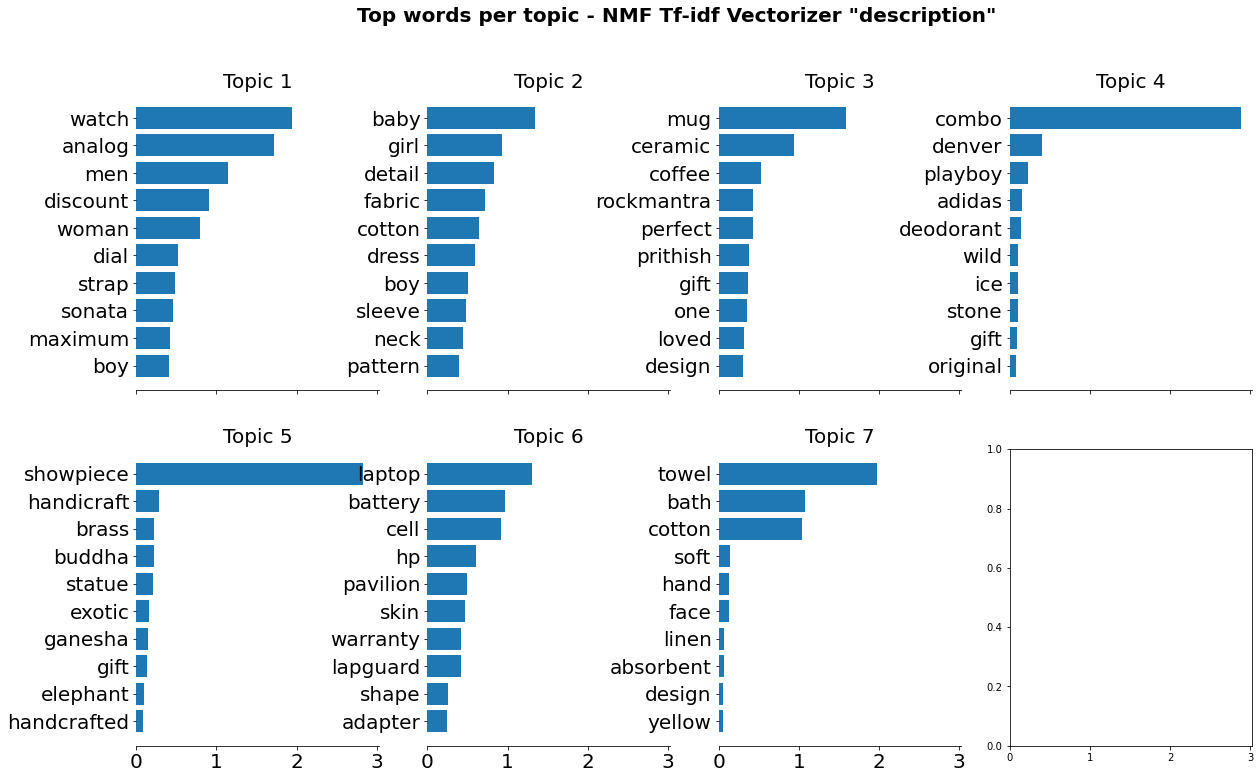

In [4362]:
# Most frequent words appearing in the different topics
n_top_words = 10
nmf_tfidf_desc_feature_names = tfidf_desc.get_feature_names()

top_words_display(nmf_desc, nmf_tfidf_desc_feature_names,
                  n_top_words,
                  'Top words per topic - NMF Tf-idf Vectorizer "description"')

In [4363]:
# Descriptions
nmf_tfidf_desc_top = nmf_desc.transform(X_tfidf_desc)

# Dataframe creation
df_topics = pd.DataFrame(nmf_tfidf_desc_top, columns=topics_name)

df_topics['Topics'] = np.argmax(df_topics.values, axis=1)
df_topics['Category'] = data_cleaned['prod_category1']
# Topics
df_topics.groupby('Topics')['Category'].value_counts(). \
    to_frame()

Category
Topics Category                            
0      Watches                          149
       Computers                         23
       Kitchen & Dining                  21
       Beauty and Personal Care          18
       Home Decor & Festive Needs         4
       Baby Care                          3
1      Baby Care                        113
       Home Furnishing                   56
       Beauty and Personal Care          19
       Home Decor & Festive Needs         7
       Kitchen & Dining                   7
       Computers                          1
2      Kitchen & Dining                 104
       Home Decor & Festive Needs         8
       Beauty and Personal Care           7
       Home Furnishing                    7
       Baby Care                          6
       Computers                          2
3      Beauty and Personal Care          85
       Home Decor & Festive Needs         2
       Home Furnishing                    1
       Kitchen & Dining                   1
4      Home Decor & Festive Needs       103
       Beauty and Personal Care           4
       Baby Care                          1
       Computers                          1
5      Computers                        123
       Home Furnishing                   61
       Home Decor & Festive Needs        26
       Beauty and Personal Care          15
       Baby Care                         13
       Kitchen & Dining                  13
       Watches                            1
6      Home Furnishing                   25
       Baby Care                         14
       Kitchen & Dining                   4
       Beauty and Personal Care           2

<AxesSubplot:xlabel='row_0'>

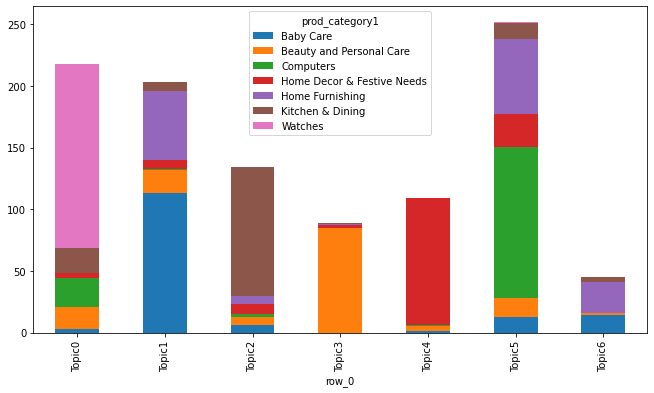

In [4364]:
nmf_tfidf_topic_desc = pd.DataFrame(nmf_desc.transform(X_tfidf_desc),
                             columns=topics_name)
nmf_best_topic = nmf_tfidf_topic_desc.idxmax(axis=1)
pd.crosstab(nmf_best_topic, data_cleaned['prod_category1']).plot.bar(figsize=(11,6), stacked=True)

In [4365]:
results_nmf_desc = metrics_clusters_lda(df_topics, data_type)
resultsx = results1__.append(results_nmf_desc, ignore_index=True)
resultsx

Methods       ARI  Homogeneity  Completness  V-Measure       AMI  \
0       cv_tsne_desc  0.434267     0.539155     0.550999   0.545013  0.540877   
1        cv_pca_desc  0.012473     0.088224     0.280233   0.134199  0.121070   
2        cv_lda_desc  0.308110     0.410171     0.440741   0.424907  0.419528   
3  cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441  0.603839   
4   cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979  0.415325   
5   cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940  0.558853   
6    tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059  0.565151   
7     tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418  0.447585   
8     tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115  0.384257   
9     nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769  0.502177   

   Fowlkes-Mallows  
0         0.518467  
1         0.339468  
2         0.420823  
3         0.537371  
4         0.392403  
5         0.549412  
6         0.513588  
7         0.369455  
8         0.394524  
9         0.512825

#### Section "product_specifications"

In [4366]:
# creating the feature matrix 

tfidf_spec = TfidfVectorizer(min_df=5, max_df=200)
X_tfidf_prod_spec = tfidf_spec.fit_transform(data_cleaned['product_specifications_clean'])
X_array_tfidf_prod_spec = X_tfidf_prod_spec.toarray()
df_tfidf_prod_spec = pd.DataFrame(data=X_array_tfidf_prod_spec,
                                  columns = tfidf_spec.get_feature_names())
df_tfidf_prod_spec.head()

absorbent  abstract   ac  access  accessory  accidental  acrylic  adapter  \
0        0.0  0.256742  0.0     0.0        0.0         0.0      0.0      0.0   
1        0.0  0.000000  0.0     0.0        0.0         0.0      0.0      0.0   
2        0.0  0.000000  0.0     0.0        0.0         0.0      0.0      0.0   
3        0.0  0.000000  0.0     0.0        0.0         0.0      0.0      0.0   
4        0.0  0.000000  0.0     0.0        0.0         0.0      0.0      0.0   

   adaptor  address  ...  wooden  wool  wpa  wps  wrap  wrapper   xp  year  \
0      0.0      0.0  ...     0.0   0.0  0.0  0.0   0.0      0.0  0.0   0.0   
1      0.0      0.0  ...     0.0   0.0  0.0  0.0   0.0      0.0  0.0   0.0   
2      0.0      0.0  ...     0.0   0.0  0.0  0.0   0.0      0.0  0.0   0.0   
3      0.0      0.0  ...     0.0   0.0  0.0  0.0   0.0      0.0  0.0   0.0   
4      0.0      0.0  ...     0.0   0.0  0.0  0.0   0.0      0.0  0.0   0.0   

     yellow  zipper  
0  0.000000     0.0  
1  0.184352     0.0  
2  0.000000     0.0  
3  0.000000     0.0  
4  0.000000     0.0  

[5 rows x 716 columns]

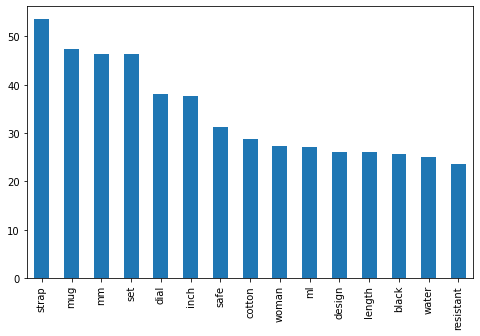

In [4367]:
df_tfidf_prod_spec.sum(axis=0).sort_values(ascending=False)[:15].plot.bar(figsize=(8,5))
plt.show()

### t-SNE visualization - Tf-idf Vectorizer "product_specification"

In [4368]:
tsne_results = tsne.fit_transform(df_tfidf_prod_spec)
    
tfidf_tsne_prod_spec = pd.concat([pd.DataFrame(tsne_results), data_cleaned['prod_category1']], axis=1)
tfidf_tsne_prod_spec = tfidf_tsne_prod_spec.rename(columns={'prod_category1':'Category'})

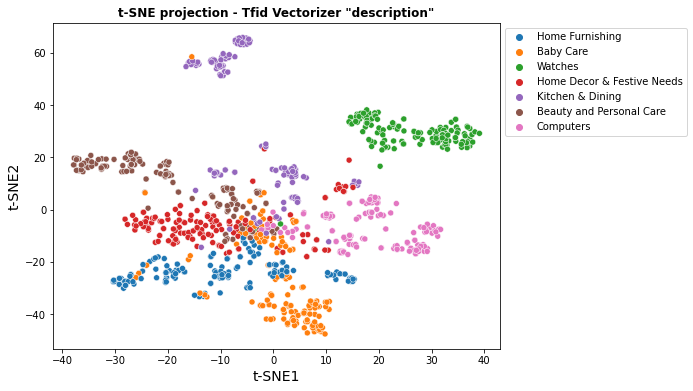

In [4369]:
title = 't-SNE projection - Tfid Vectorizer "description"'
tsne_visualisation(tfidf_tsne_prod_spec, title)

### t-SNE clustering

In [4370]:
data_type = 'tfidf_tsne_prod_spec'

In [4371]:
# Kmeans
tsne_tfidf_prod_spec = KMeans(n_clusters=7,
                      init='k-means++',
                      random_state=42).fit(tfidf_tsne_prod_spec.iloc[:, :2])
 
tfidf_tsne_prod_spec['cluster'] = tsne_tfidf_prod_spec.labels_
cluster_labels = tsne_tfidf_prod_spec.labels_
centres_reduced = tsne_tfidf_prod_spec.cluster_centers_

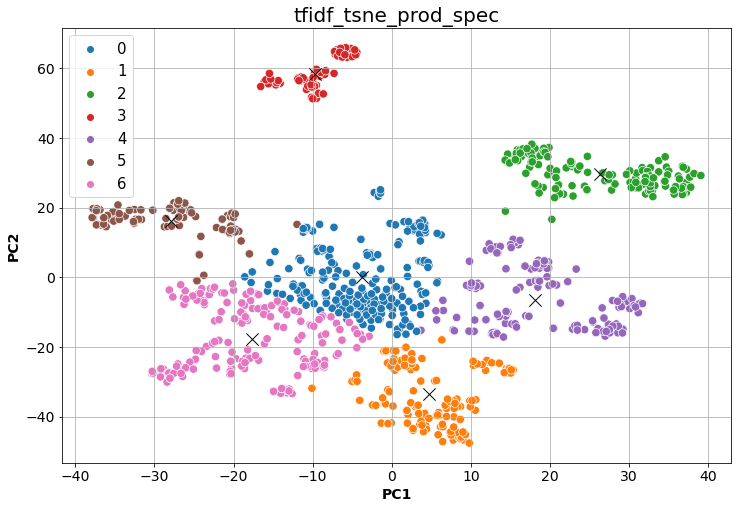

In [4372]:
display_clusters(tsne_results, cluster_labels, data_type)

Number of products per cluster:
0    233
6    197
4    163
2    145
1    139
5     98
3     75
Name: cluster, dtype: int64


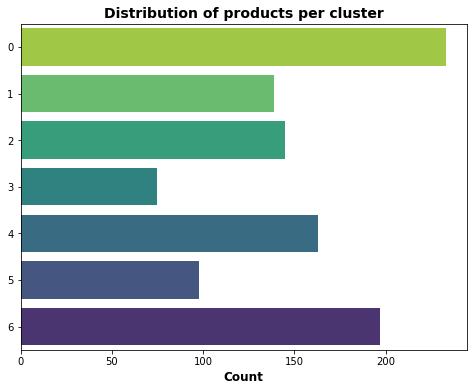

In [4373]:
cluster_distribution(tfidf_tsne_prod_spec)

In [4374]:
# tSNE + Tf-idf Vectorizer on "product_specifications" 
results23 = metrics_clusters(tfidf_tsne_prod_spec, data_type)
results2_3 = resultsx.append(results23, ignore_index=True)
results2_3

Methods       ARI  Homogeneity  Completness  V-Measure  \
0           cv_tsne_desc  0.434267     0.539155     0.550999   0.545013   
1            cv_pca_desc  0.012473     0.088224     0.280233   0.134199   
2            cv_lda_desc  0.308110     0.410171     0.440741   0.424907   
3      cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441   
4       cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979   
5       cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
6        tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059   
7         tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418   
8         tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115   
9         nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769   
10  tfidf_tsne_prod_spec  0.463240     0.593730     0.611894   0.602675   

         AMI  Fowlkes-Mallows  
0   0.540877         0.518467  
1   0.121070         0.339468  
2   0.419528         0.420823  
3   0.603839         0.537371  
4   0.415325         0.392403  
5   0.558853         0.549412  
6   0.565151         0.513588  
7   0.447585         0.369455  
8   0.384257         0.394524  
9   0.502177         0.512825  
10  0.599046         0.544357

### PCA

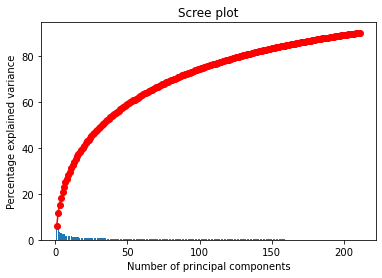

The number of principal components to keep to get 90% of the variance explained is: 211 


In [4375]:
pca = PCA(n_components = 0.90)
pca.fit(df_tfidf_prod_spec)
display_scree_plot(pca)
print("The number of principal components to keep to get 90% of the variance explained is: {} ".format(pca.n_components_))

In [4376]:
n_comp = pca.n_components_
pca_tfidf_prod_spec = PCA(n_components=n_comp)
pca_tfidf_prod_spec.fit(df_tfidf_prod_spec)
X_proj_tfidf_prod_spec = pca_tfidf_prod_spec.transform(df_tfidf_prod_spec)

# Dataframe pour clustering & visualization
df_pca_tfidf_prod_spec = pd.DataFrame({'PC1': X_proj_tfidf_prod_spec[:, 0],
                            'PC2': X_proj_tfidf_prod_spec[:, 1],
                            'PC3': X_proj_tfidf_prod_spec[:, 2],
                            'Category' : data_cleaned['prod_category1']})

### 2D PCA visualization

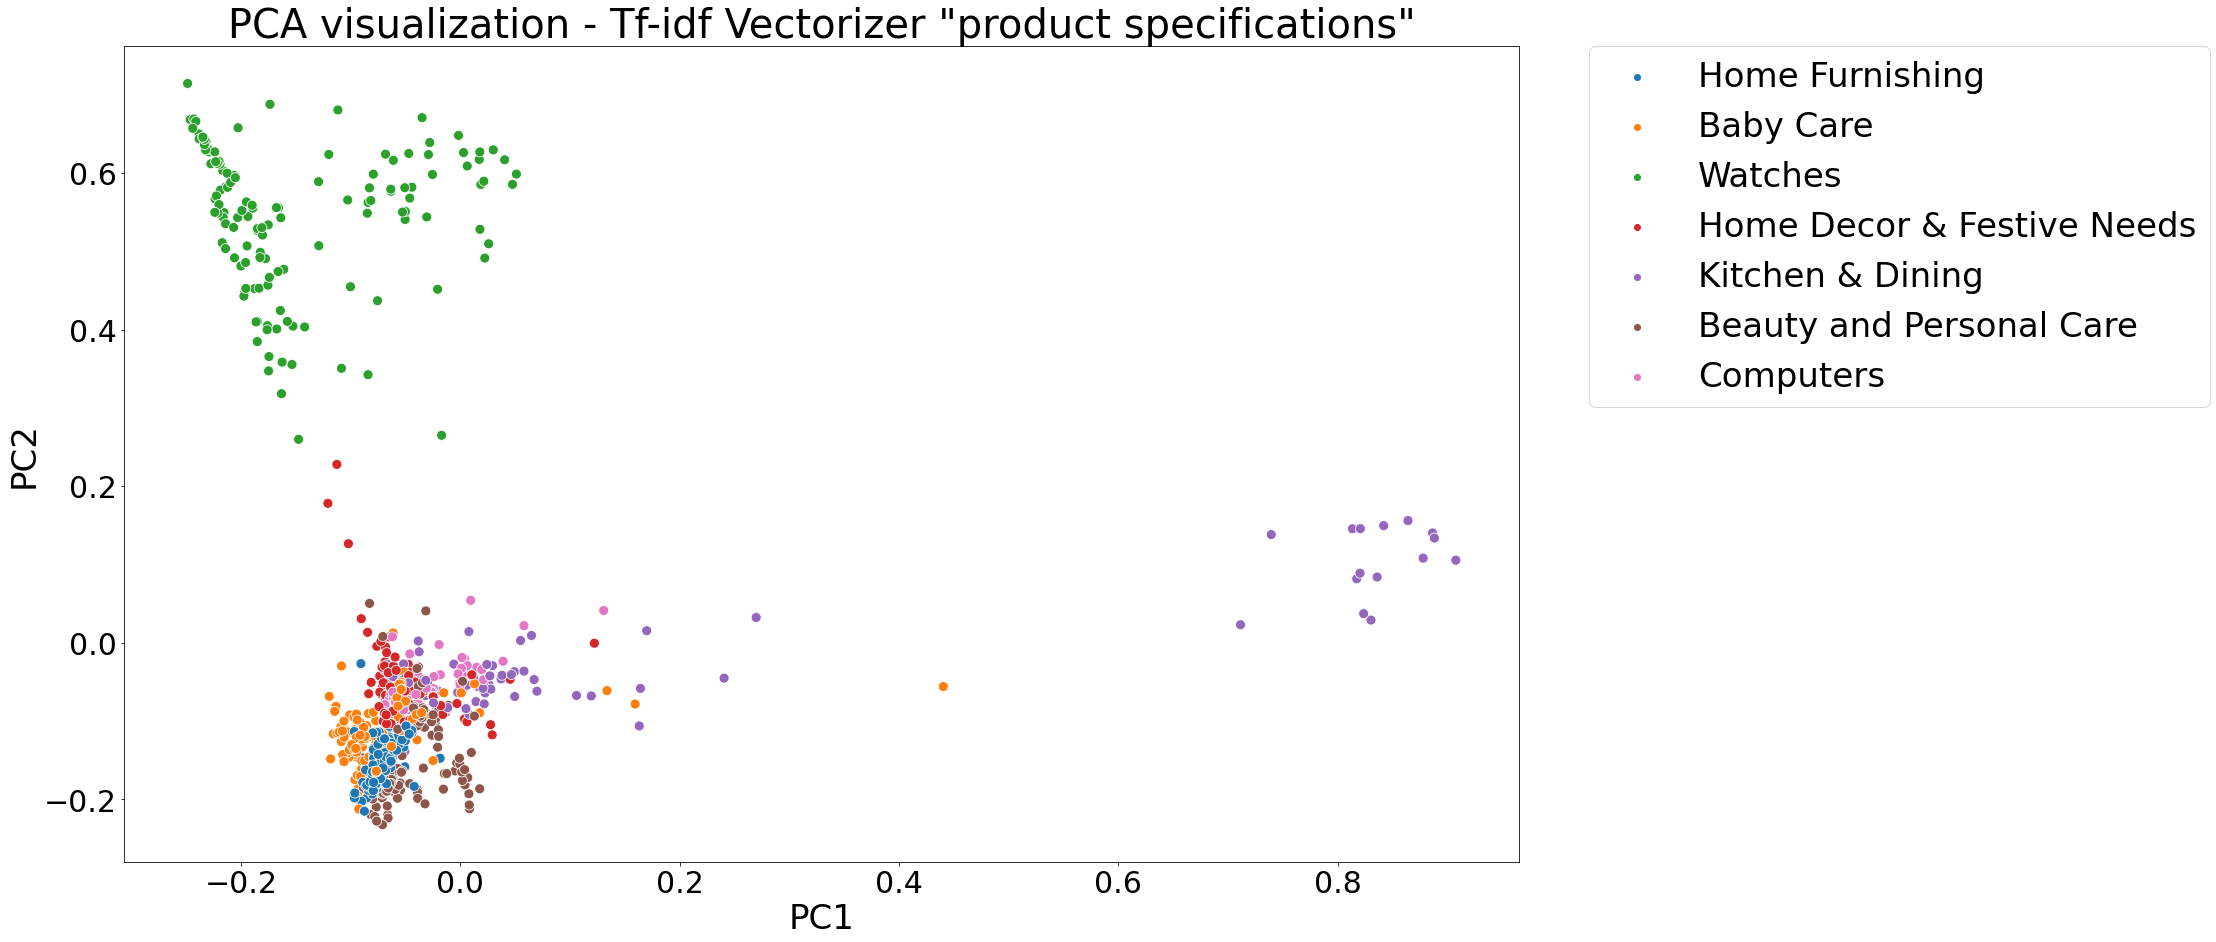

In [4377]:
# PCA Visulisation 
title = 'PCA visualization - Tf-idf Vectorizer "product specifications"'
pca_visualization(data_cleaned, X_proj_tfidf_prod_spec, 'PC1', 'PC2', title)

### 3D PCA visualization

In [4378]:
threed_pca(df_pca_tfidf_prod_spec)

### KMeans clustering on Tf-idf Vectorizer "product specifications"

In [4379]:
data_type = 'tfidf_pca_prod_spec'

In [4380]:
# Apply KMeans with optimum K
vars = ['PC1', 'PC2']
kmean = KMeans(n_clusters=7,
                  init='k-means++',
                  random_state=42).fit(df_pca_tfidf_prod_spec[vars])

df_pca_tfidf_prod_spec['cluster'] = kmean.labels_
cluster_labels = kmean.labels_
centres_reduced = kmean.cluster_centers_

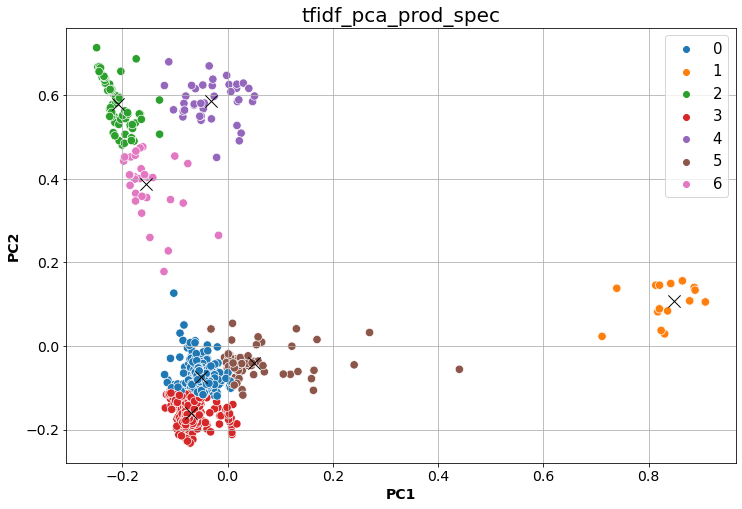

In [4381]:
display_clusters(X_proj_tfidf_prod_spec, cluster_labels, data_type)

### 3D clustering visualization

In [4382]:
threed_clustering(df_pca_tfidf_prod_spec)

Number of products per cluster:
0    437
3    324
1     74
2     74
5     68
4     39
6     34
Name: cluster, dtype: int64


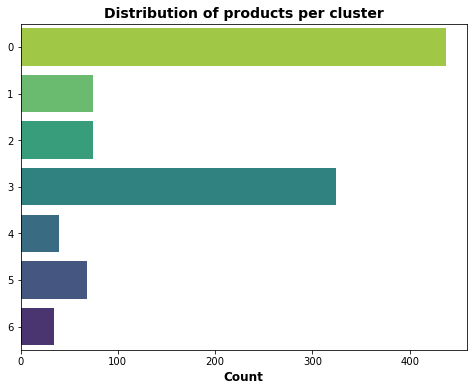

In [4383]:
cluster_distribution(df_pca_tfidf_prod_spec)

### Clusters metrics  

In [4384]:
# PCA + CountVectorizer on "product_specification" 
results24 = metrics_clusters(df_pca_tfidf_prod_spec, data_type)
results2_4 = results2_3.append(results24, ignore_index=True)
results2_4

Methods       ARI  Homogeneity  Completness  V-Measure  \
0           cv_tsne_desc  0.434267     0.539155     0.550999   0.545013   
1            cv_pca_desc  0.012473     0.088224     0.280233   0.134199   
2            cv_lda_desc  0.308110     0.410171     0.440741   0.424907   
3      cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441   
4       cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979   
5       cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
6        tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059   
7         tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418   
8         tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115   
9         nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769   
10  tfidf_tsne_prod_spec  0.463240     0.593730     0.611894   0.602675   
11   tfidf_pca_prod_spec  0.252031     0.420270     0.540817   0.472983   

         AMI  Fowlkes-Mallows  
0   0.540877         0.518467  
1   0.121070         0.339468  
2   0.419528         0.420823  
3   0.603839         0.537371  
4   0.415325         0.392403  
5   0.558853         0.549412  
6   0.565151         0.513588  
7   0.447585         0.369455  
8   0.384257         0.394524  
9   0.502177         0.512825  
10  0.599046         0.544357  
11  0.467561         0.417663

### LDA on product specifications

In [4385]:
data_type = 'tfidf_lda_spec'

In [4386]:
# Instanciation du modèle
lda_tfidf_spec = LatentDirichletAllocation(n_components=7,
                                          max_iter=10,
                                          learning_method='online',
                                          learning_offset=50,
                                          random_state=42,
                                          n_jobs=-1)
# Entraînement du modèle
lda_tfidf_spec.fit(X_tfidf_prod_spec)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          n_components=7, n_jobs=-1, random_state=42)

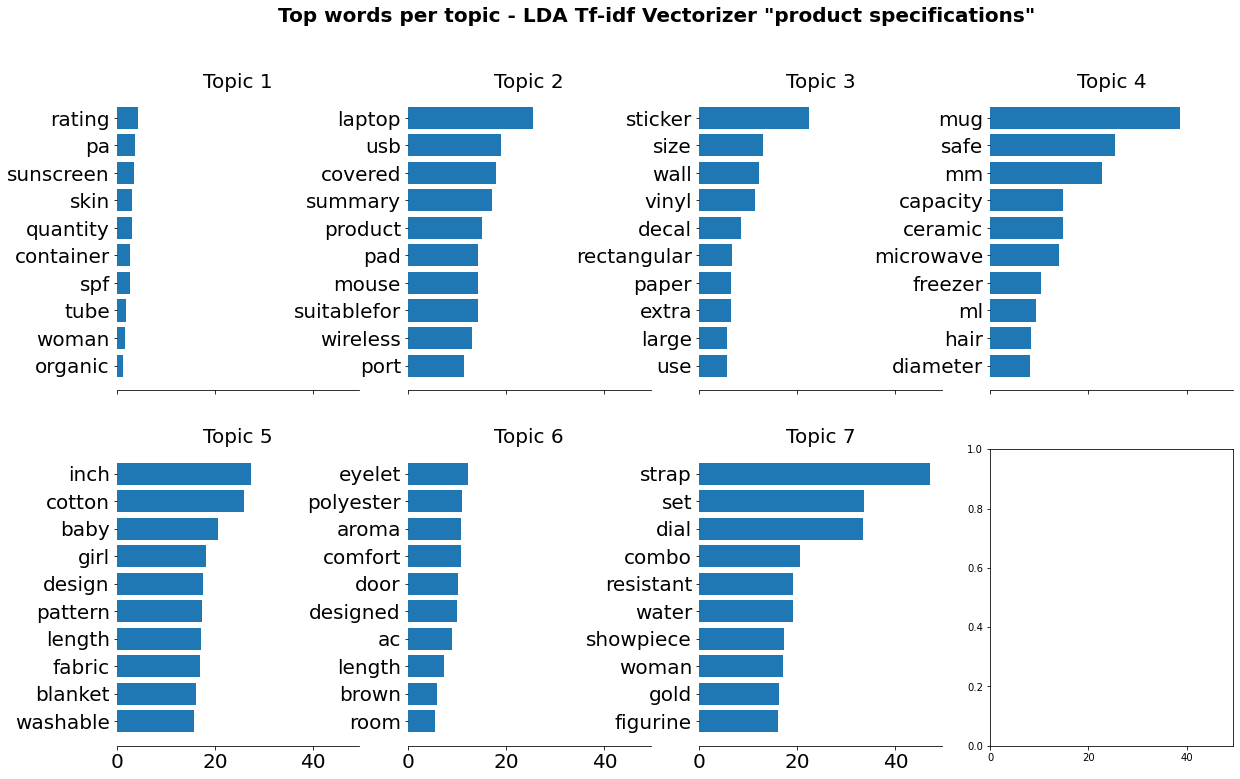

In [4387]:
# Most frequent words appearing in the different topics
n_top_words = 10
lda_tfidf_spec_feature_names = tfidf_spec.get_feature_names()

top_words_display(lda_tfidf_spec, lda_tfidf_spec_feature_names,
                  n_top_words,
                  'Top words per topic - LDA Tf-idf Vectorizer "product specifications"')

In [4388]:
# Descriptions
lda_tfidf_spec_top = lda_tfidf_spec.transform(X_tfidf_prod_spec)

# Dataframe creation
df_topics = pd.DataFrame(lda_tfidf_spec_top, columns=topics_name)

df_topics['Topics'] = np.argmax(df_topics.values, axis=1)
df_topics['Category'] = data_cleaned['prod_category1']
# Topics
df_topics.groupby('Topics')['Category'].value_counts(). \
    to_frame()

Category
Topics Category                            
0      Beauty and Personal Care          14
       Watches                            5
       Computers                          3
       Home Decor & Festive Needs         1
1      Computers                        145
       Home Decor & Festive Needs         5
       Beauty and Personal Care           4
       Kitchen & Dining                   4
2      Baby Care                         11
       Home Decor & Festive Needs        10
       Home Furnishing                    1
3      Kitchen & Dining                 102
       Beauty and Personal Care           5
       Home Decor & Festive Needs         3
       Computers                          1
4      Baby Care                        134
       Home Furnishing                  124
       Kitchen & Dining                  22
       Beauty and Personal Care          18
       Home Decor & Festive Needs        13
5      Home Furnishing                   24
       Home Decor & Festive Needs         8
       Kitchen & Dining                   5
       Baby Care                          4
6      Watches                          145
       Home Decor & Festive Needs       110
       Beauty and Personal Care         109
       Kitchen & Dining                  17
       Baby Care                          1
       Computers                          1
       Home Furnishing                    1

<AxesSubplot:xlabel='row_0'>

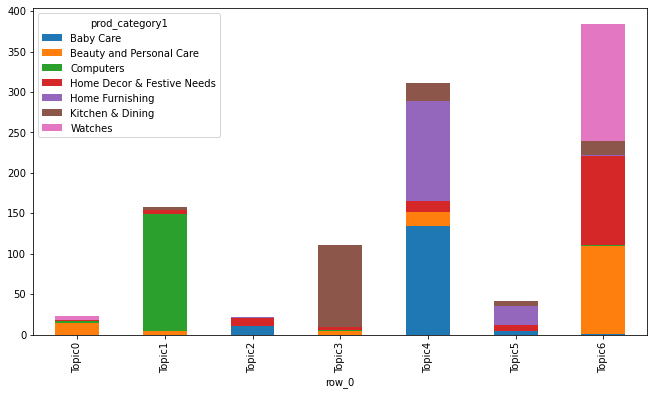

In [4389]:
lda_tfidf_topic_spec = pd.DataFrame(lda_tfidf_spec.transform(X_tfidf_prod_spec),
                             columns=topics_name)
lda_best_topic = lda_tfidf_topic_spec.idxmax(axis=1)
pd.crosstab(lda_best_topic, data_cleaned['prod_category1']).plot.bar(figsize=(11,6), stacked=True)

In [4390]:
results_lda_spec = metrics_clusters_lda(df_topics, data_type)
results1s = results2_4.append(results_lda_spec, ignore_index=True)
results1s

Methods       ARI  Homogeneity  Completness  V-Measure  \
0           cv_tsne_desc  0.434267     0.539155     0.550999   0.545013   
1            cv_pca_desc  0.012473     0.088224     0.280233   0.134199   
2            cv_lda_desc  0.308110     0.410171     0.440741   0.424907   
3      cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441   
4       cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979   
5       cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
6        tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059   
7         tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418   
8         tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115   
9         nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769   
10  tfidf_tsne_prod_spec  0.463240     0.593730     0.611894   0.602675   
11   tfidf_pca_prod_spec  0.252031     0.420270     0.540817   0.472983   
12        tfidf_lda_spec  0.395396     0.485369     0.612458   0.541557   

         AMI  Fowlkes-Mallows  
0   0.540877         0.518467  
1   0.121070         0.339468  
2   0.419528         0.420823  
3   0.603839         0.537371  
4   0.415325         0.392403  
5   0.558853         0.549412  
6   0.565151         0.513588  
7   0.447585         0.369455  
8   0.384257         0.394524  
9   0.502177         0.512825  
10  0.599046         0.544357  
11  0.467561         0.417663  
12  0.536809         0.528432

### NMF

Non-Negative Matrix Factorization is a state of the art feature extraction algorithm. NMF is useful when there are many attributes and the attributes are ambiguous or have weak predictability. By combining attributes, NMF can produce meaningful patterns, topics, or themes.

Each feature created by NMF is a linear combination of the original attribute set. Each feature has a set of coefficients, which are a measure of the weight of each attribute on the feature. There is a separate coefficient for each numerical attribute and for each distinct value of each categorical attribute. The coefficients are all non-negative.

Non-Negative Matrix Factorization uses techniques from multivariate analysis and linear algebra. It decomposes the data as a matrix M into the product of two lower ranking matrices W and H. The sub-matrix W contains the NMF basis; the sub-matrix H contains the associated coefficients (weights).

The algorithm iteratively modifies of the values of W and H so that their product approaches M. The technique preserves much of the structure of the original data and guarantees that both basis and weights are non-negative. The algorithm terminates when the approximation error converges or a specified number of iterations is reached.

In [4391]:
data_type = 'nmf_tfidf_prod_spec'

In [4392]:
# Model initialisation
nmf_spec = NMF(n_components=7,
               random_state=42,
               alpha=0.1,
               l1_ratio=0.5,
               init='nndsvd',
               solver='mu')

# Model training
nmf_spec.fit(X_tfidf_prod_spec)

NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=7, random_state=42,
    solver='mu')

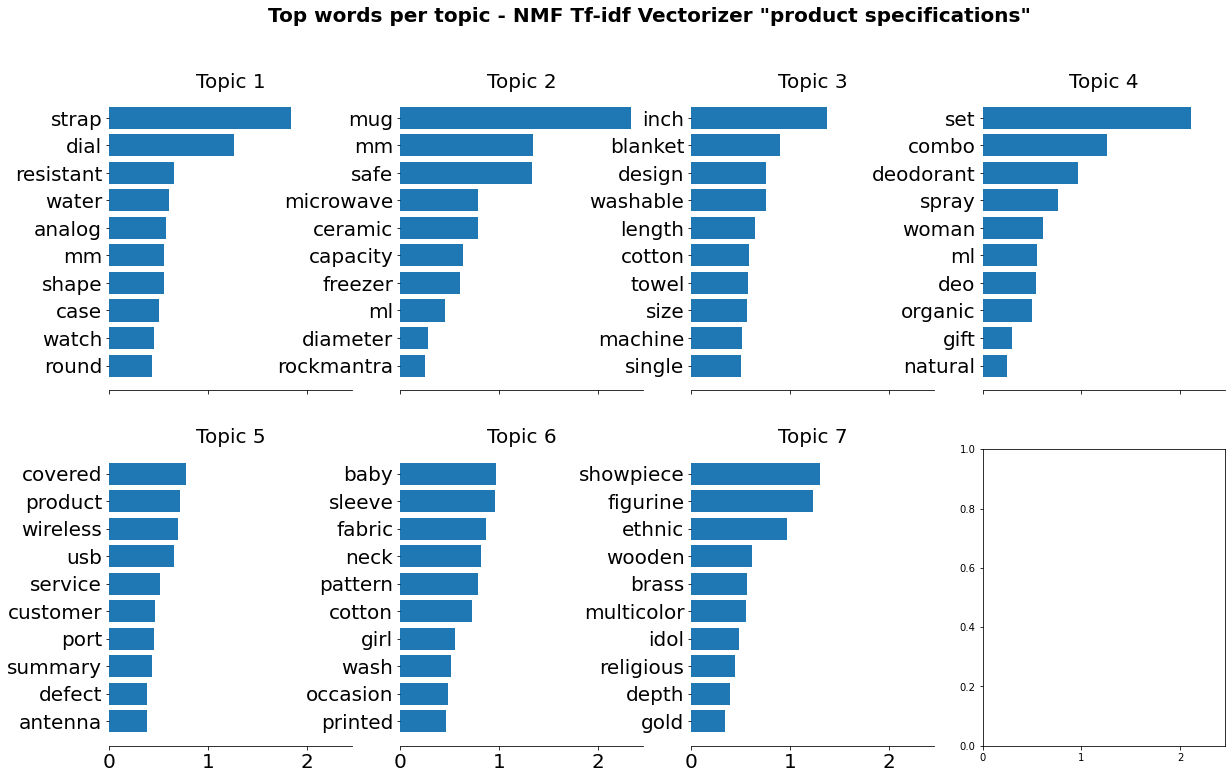

In [4393]:
# Most frequent words appearing in the different topics
n_top_words = 10
nmf_tfidf_spec_feature_names = tfidf_spec.get_feature_names()

top_words_display(nmf_spec, nmf_tfidf_spec_feature_names,
                  n_top_words,
                  'Top words per topic - NMF Tf-idf Vectorizer "product specifications"')

In [4394]:
# Descriptions
nmf_tfidf_spec_top = nmf_spec.transform(X_tfidf_prod_spec)

# Dataframe creation
df_topics = pd.DataFrame(nmf_tfidf_spec_top, columns=topics_name)

df_topics['Topics'] = np.argmax(df_topics.values, axis=1)
df_topics['Category'] = data_cleaned['prod_category1']
# Topics
df_topics.groupby('Topics')['Category'].value_counts(). \
    to_frame()

Category
Topics Category                            
0      Watches                          150
       Kitchen & Dining                   8
       Beauty and Personal Care           5
       Computers                          4
       Baby Care                          2
       Home Decor & Festive Needs         2
1      Kitchen & Dining                  98
       Baby Care                          3
       Home Decor & Festive Needs         2
       Computers                          1
2      Home Furnishing                  148
       Baby Care                         42
       Home Decor & Festive Needs        29
       Kitchen & Dining                   6
       Beauty and Personal Care           5
       Computers                          1
3      Beauty and Personal Care         126
       Kitchen & Dining                  16
       Baby Care                          4
       Home Decor & Festive Needs         2
       Home Furnishing                    1
4      Computers                        144
       Kitchen & Dining                  18
       Home Decor & Festive Needs        13
       Baby Care                          4
       Beauty and Personal Care           4
5      Baby Care                         95
       Beauty and Personal Care           3
       Home Furnishing                    1
6      Home Decor & Festive Needs       102
       Beauty and Personal Care           7
       Kitchen & Dining                   4

<AxesSubplot:xlabel='row_0'>

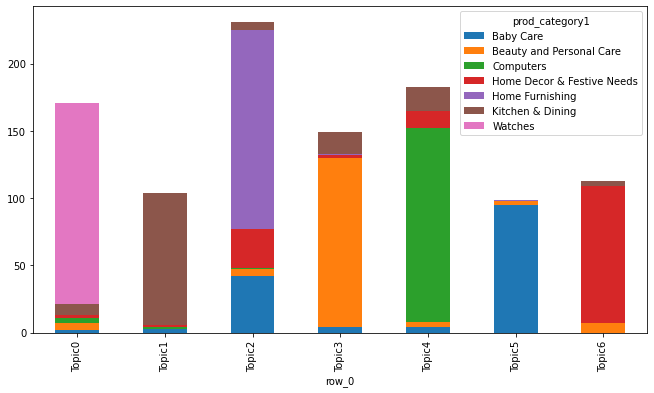

In [4395]:
nmf_tfidf_topic_spec = pd.DataFrame(nmf_spec.transform(X_tfidf_prod_spec),
                             columns=topics_name)
nmf_best_topic = nmf_tfidf_topic_spec.idxmax(axis=1)
pd.crosstab(nmf_best_topic, data_cleaned['prod_category1']).plot.bar(figsize=(11,6), stacked=True)

In [4396]:
results_nmf_spec = metrics_clusters_lda(df_topics, data_type)
resultss = results1s.append(results_nmf_spec, ignore_index=True)
resultss

Methods       ARI  Homogeneity  Completness  V-Measure  \
0           cv_tsne_desc  0.434267     0.539155     0.550999   0.545013   
1            cv_pca_desc  0.012473     0.088224     0.280233   0.134199   
2            cv_lda_desc  0.308110     0.410171     0.440741   0.424907   
3      cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441   
4       cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979   
5       cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
6        tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059   
7         tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418   
8         tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115   
9         nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769   
10  tfidf_tsne_prod_spec  0.463240     0.593730     0.611894   0.602675   
11   tfidf_pca_prod_spec  0.252031     0.420270     0.540817   0.472983   
12        tfidf_lda_spec  0.395396     0.485369     0.612458   0.541557   
13   nmf_tfidf_prod_spec  0.634832     0.678816     0.694558   0.686597   

         AMI  Fowlkes-Mallows  
0   0.540877         0.518467  
1   0.121070         0.339468  
2   0.419528         0.420823  
3   0.603839         0.537371  
4   0.415325         0.392403  
5   0.558853         0.549412  
6   0.565151         0.513588  
7   0.447585         0.369455  
8   0.384257         0.394524  
9   0.502177         0.512825  
10  0.599046         0.544357  
11  0.467561         0.417663  
12  0.536809         0.528432  
13  0.683746         0.689597

### 5. BOW - HashingVectorizer

Convert a collection of text documents to a matrix of token occurrences.

It turns a collection of text documents into a scipy.sparse matrix holding token occurrence counts (or binary occurrence information), possibly normalized as token frequencies if norm=’l1’ or projected on the euclidean unit sphere if norm=’l2’.

This text vectorizer implementation uses the hashing trick to find the token string name to feature integer index mapping.

#### Section "description"

In [4397]:
hashvect_desc = HashingVectorizer(norm=None, n_features=741)
X_hashvect_desc = hashvect_desc.fit_transform(data_cleaned['description_clean'])
X_array_hash_desc = X_hashvect_desc.toarray()

df_hashvect_desc = pd.DataFrame(X_array_hash_desc,
                              columns=tfidf.get_feature_names())
df_hashvect_desc.head(3)

absorbent  abstract   ac  access  accessory  accidental  acrylic  adapter  \
0        0.0       0.0  0.0     0.0        0.0         0.0     -6.0      0.0   
1        0.0       0.0  0.0     0.0        0.0         0.0      0.0      0.0   
2        0.0       4.0  0.0     0.0        0.0         0.0      0.0      0.0   

   adaptor  address  ...  wool  wpa  wps  wrap  wrapper   xp  year  yellow  \
0      0.0      0.0  ...   0.0  0.0  0.0   0.0      0.0  0.0   0.0    -1.0   
1      0.0      0.0  ...   0.0  0.0  0.0   0.0      0.0  0.0   0.0     0.0   
2      0.0      0.0  ...   0.0  0.0  0.0   0.0      0.0  0.0   0.0     0.0   

   yes  zipper  
0  0.0     0.0  
1  0.0     0.0  
2  0.0     0.0  

[3 rows x 741 columns]

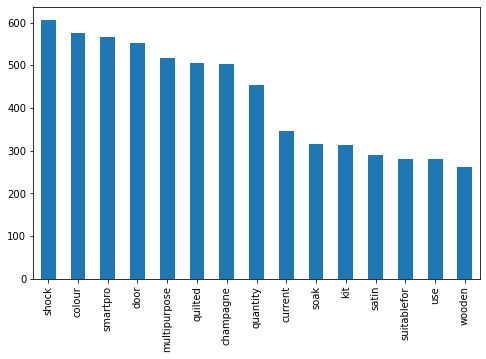

In [4398]:
df_hashvect_desc.sum(axis=0).sort_values(ascending=False)[:15].plot.bar(figsize=(8,5))
plt.show()

### t-SNE 

In [4399]:
tsne_results = tsne.fit_transform(df_hashvect_desc)
    
hashvect_tsne_desc = pd.concat([pd.DataFrame(tsne_results), data_cleaned['prod_category1']], axis=1)
hashvect_tsne_desc = hashvect_tsne_desc.rename(columns={'prod_category1':'Category'})

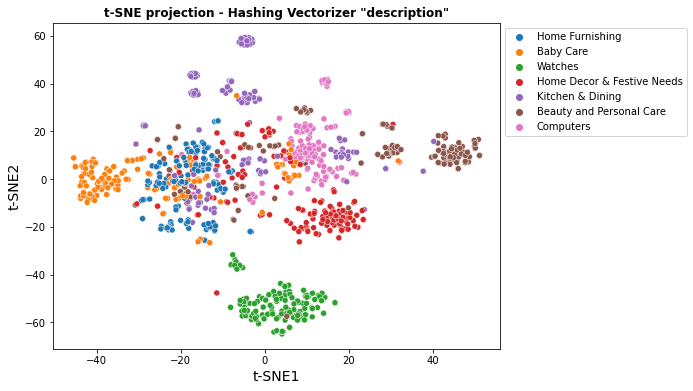

In [4400]:
title = 't-SNE projection - Hashing Vectorizer "description"'
tsne_visualisation(hashvect_tsne_desc, title)

### t-SNE clustering

In [4401]:
data_type = 'hash_tsne_desc'

In [4402]:
# Kmeans
tsne_hash_desc = KMeans(n_clusters=7,
                      init='k-means++',
                      random_state=42).fit(hashvect_tsne_desc.iloc[:, :2])
 
hashvect_tsne_desc['cluster'] = tsne_hash_desc.labels_
cluster_labels = tsne_hash_desc.labels_
centres_reduced = tsne_hash_desc.cluster_centers_

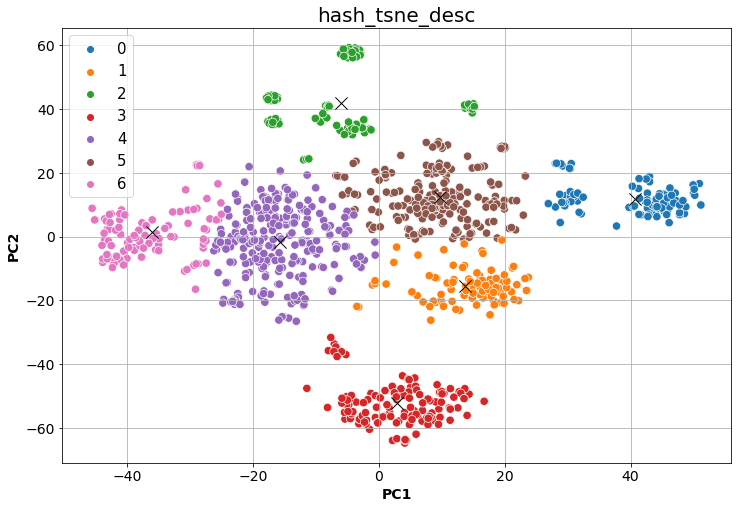

In [4403]:
display_clusters(tsne_results, cluster_labels, data_type)

Number of products per cluster:
4    267
5    217
3    152
6    117
1    107
0    100
2     90
Name: cluster, dtype: int64


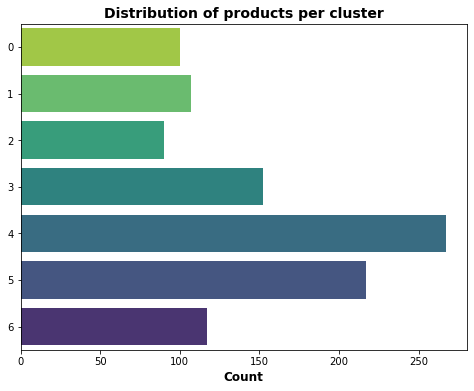

In [4404]:
cluster_distribution(hashvect_tsne_desc)

### Clusters metrics  

In [4405]:
# PCA + CountVectorizer on "product_specification" 
results31 = metrics_clusters(hashvect_tsne_desc, data_type)
results3_1 = resultss.append(results31, ignore_index=True)
results3_1

Methods       ARI  Homogeneity  Completness  V-Measure  \
0           cv_tsne_desc  0.434267     0.539155     0.550999   0.545013   
1            cv_pca_desc  0.012473     0.088224     0.280233   0.134199   
2            cv_lda_desc  0.308110     0.410171     0.440741   0.424907   
3      cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441   
4       cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979   
5       cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
6        tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059   
7         tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418   
8         tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115   
9         nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769   
10  tfidf_tsne_prod_spec  0.463240     0.593730     0.611894   0.602675   
11   tfidf_pca_prod_spec  0.252031     0.420270     0.540817   0.472983   
12        tfidf_lda_spec  0.395396     0.485369     0.612458   0.541557   
13   nmf_tfidf_prod_spec  0.634832     0.678816     0.694558   0.686597   
14        hash_tsne_desc  0.440361     0.536891     0.560014   0.548209   

         AMI  Fowlkes-Mallows  
0   0.540877         0.518467  
1   0.121070         0.339468  
2   0.419528         0.420823  
3   0.603839         0.537371  
4   0.415325         0.392403  
5   0.558853         0.549412  
6   0.565151         0.513588  
7   0.447585         0.369455  
8   0.384257         0.394524  
9   0.502177         0.512825  
10  0.599046         0.544357  
11  0.467561         0.417663  
12  0.536809         0.528432  
13  0.683746         0.689597  
14  0.544056         0.527908

### PCA HashingVectorizer "description"

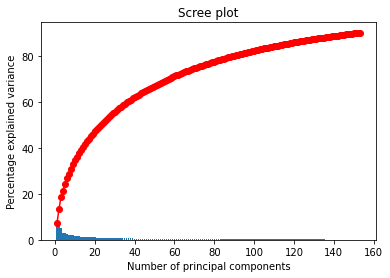

The number of principal components to keep to get 90% of the variance explained is: 153 


In [4406]:
pca = PCA(n_components = 0.90)
pca.fit(df_hashvect_desc)
display_scree_plot(pca)
print("The number of principal components to keep to get 90% of the variance explained is: {} ".format(pca.n_components_))

In [4407]:
n_comp = pca.n_components_
pca_hash = PCA(n_components=n_comp)
X_proj_hashvect_desc = pca_hash.fit_transform(df_hashvect_desc)

# Dataframe creationour clustering
df_pca_hashvect_desc = pd.DataFrame({'PC1': X_proj_hashvect_desc[:, 0],
                                     'PC2': X_proj_hashvect_desc[:, 1],
                                     'PC3': X_proj_hashvect_desc[:, 2],
                                     'Category' : data_cleaned['prod_category1']})

### 2D PCA

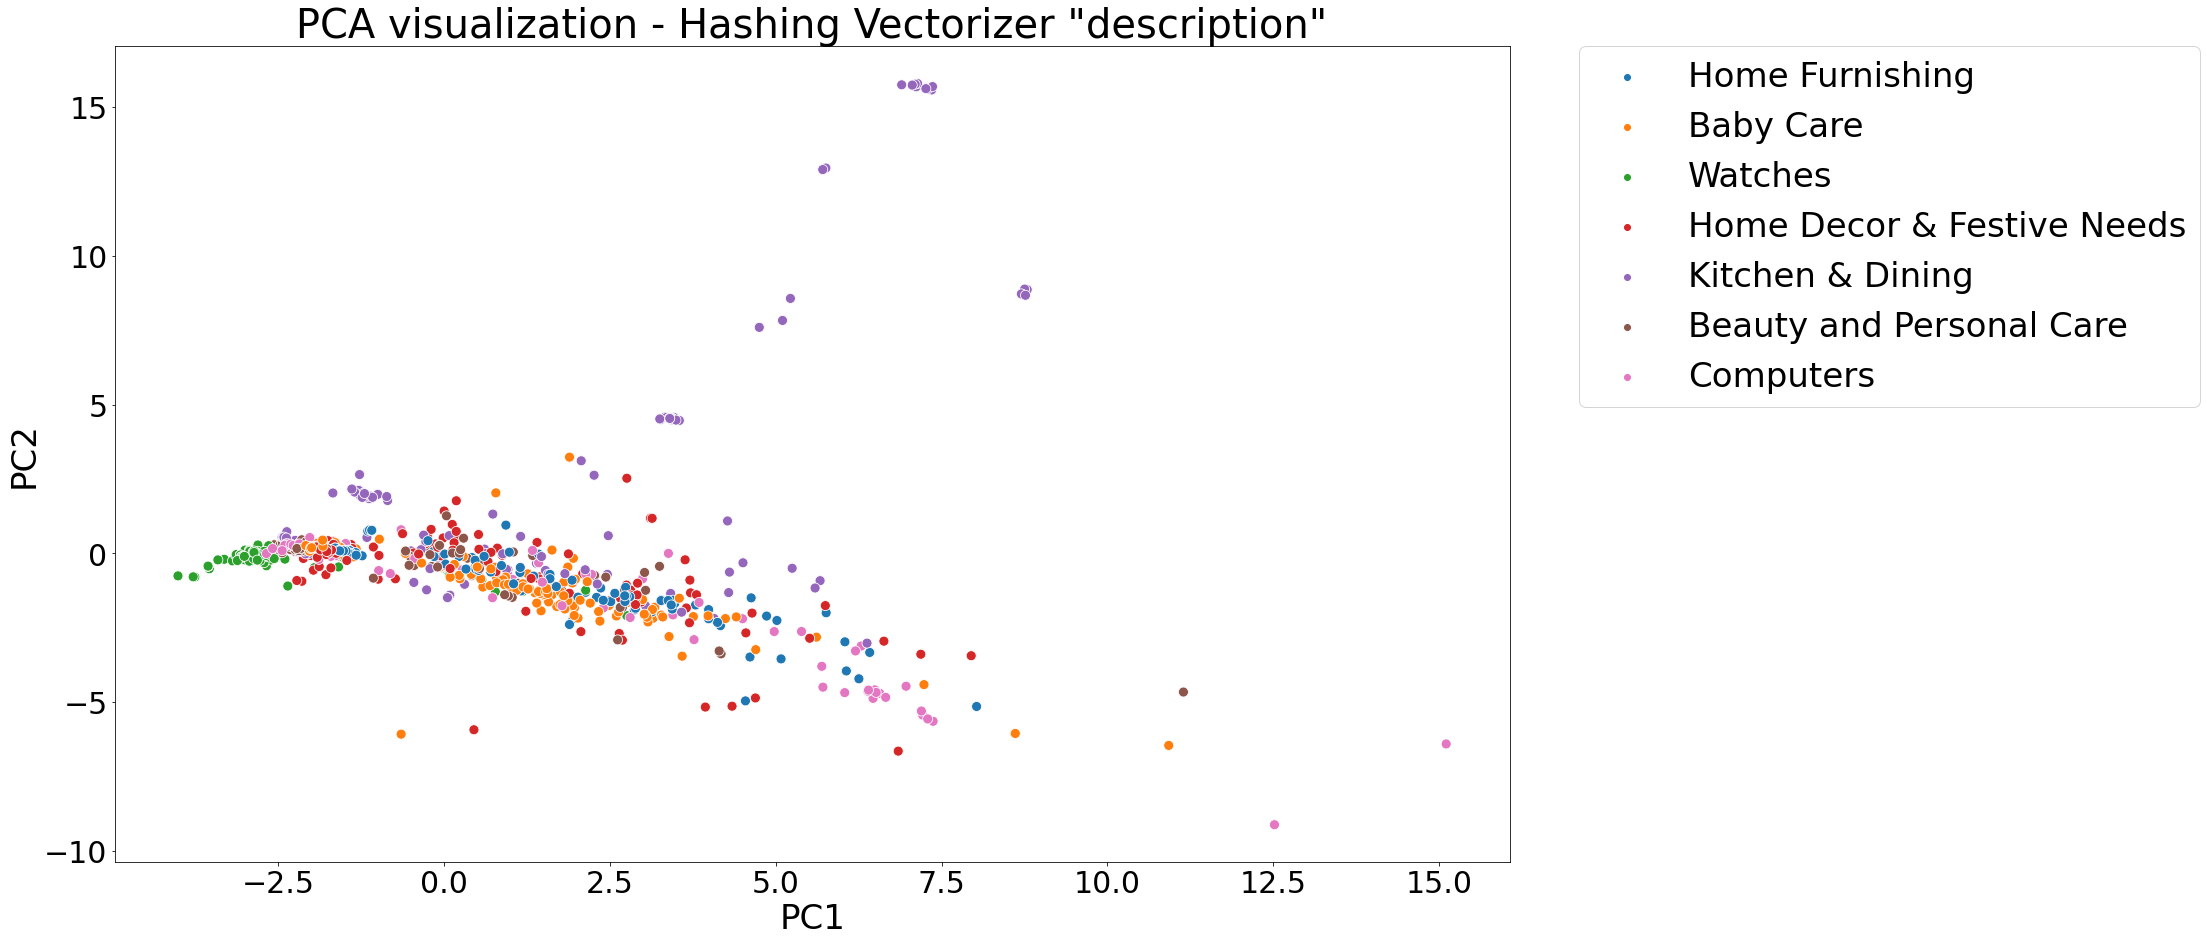

In [4408]:
# 2D PCA visualization
title = 'PCA visualization - Hashing Vectorizer "description"'
pca_visualization(data_cleaned, X_proj_hashvect_desc, 'PC1', 'PC2', title)

### 3D PCA visualization

In [4409]:
threed_pca(df_pca_hashvect_desc)

### KMeans clustering on Hashing Vectorizer "description"

In [4410]:
data_type = 'hashvect_pca_desc'

In [4411]:
# Apply KMeans with optimum K
vars = ['PC1', 'PC2']
kmean = KMeans(n_clusters=7,
                  init='k-means++',
                  random_state=42).fit(df_pca_hashvect_desc[vars])

df_pca_hashvect_desc['cluster'] = kmean.labels_
cluster_labels = kmean.labels_
centres_reduced = kmean.cluster_centers_

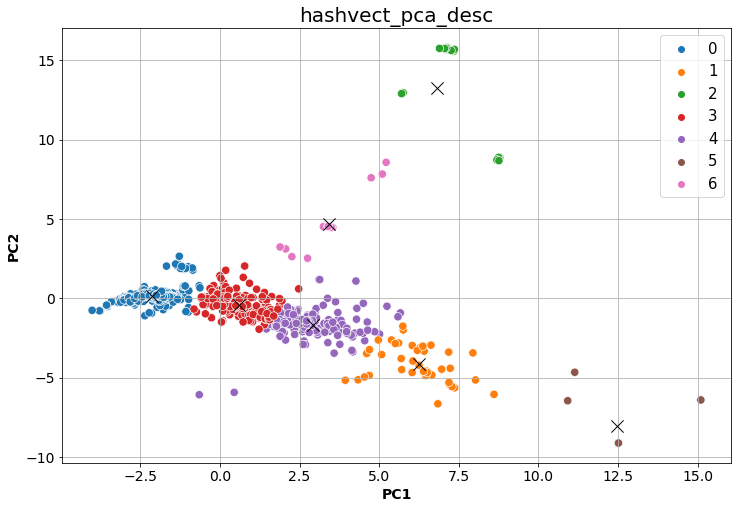

In [4412]:
display_clusters(X_proj_hashvect_desc, cluster_labels, data_type)

### 3D clustering visualization

In [4413]:
threed_clustering(df_pca_hashvect_desc)

Number of products per cluster:
0    586
3    202
4    153
1     43
6     29
2     28
5      9
Name: cluster, dtype: int64


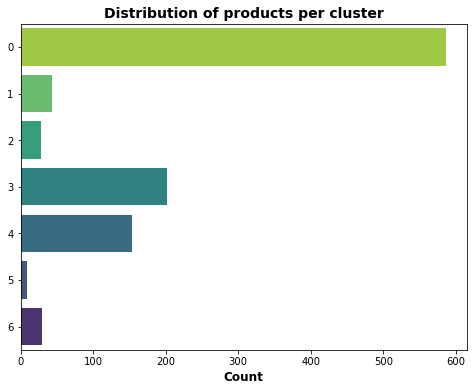

In [4414]:
cluster_distribution(df_pca_hashvect_desc)

### Clusters metrics

In [4415]:
# PCA + HashingVectorizer on "description" 
results32 = metrics_clusters(df_pca_hashvect_desc, data_type)
results3_2 = results3_1.append(results32, ignore_index=True)
results3_2

Methods       ARI  Homogeneity  Completness  V-Measure  \
0           cv_tsne_desc  0.434267     0.539155     0.550999   0.545013   
1            cv_pca_desc  0.012473     0.088224     0.280233   0.134199   
2            cv_lda_desc  0.308110     0.410171     0.440741   0.424907   
3      cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441   
4       cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979   
5       cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
6        tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059   
7         tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418   
8         tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115   
9         nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769   
10  tfidf_tsne_prod_spec  0.463240     0.593730     0.611894   0.602675   
11   tfidf_pca_prod_spec  0.252031     0.420270     0.540817   0.472983   
12        tfidf_lda_spec  0.395396     0.485369     0.612458   0.541557   
13   nmf_tfidf_prod_spec  0.634832     0.678816     0.694558   0.686597   
14        hash_tsne_desc  0.440361     0.536891     0.560014   0.548209   
15     hashvect_pca_desc  0.045396     0.115849     0.174661   0.139302   

         AMI  Fowlkes-Mallows  
0   0.540877         0.518467  
1   0.121070         0.339468  
2   0.419528         0.420823  
3   0.603839         0.537371  
4   0.415325         0.392403  
5   0.558853         0.549412  
6   0.565151         0.513588  
7   0.447585         0.369455  
8   0.384257         0.394524  
9   0.502177         0.512825  
10  0.599046         0.544357  
11  0.467561         0.417663  
12  0.536809         0.528432  
13  0.683746         0.689597  
14  0.544056         0.527908  
15  0.129474         0.270301

#### Section "product_specifications"

In [4416]:
hashvect = HashingVectorizer(norm=None, n_features=741)
X_hashvect_prod_spec = hashvect.fit_transform(data_cleaned['product_specifications_clean'])
X_array_hash_prod_spec = X_hashvect_prod_spec.toarray()

df_hashvect_prod_spec = pd.DataFrame(X_array_hash_prod_spec,
                              columns=tfidf.get_feature_names())
df_hashvect_prod_spec.head(3)

absorbent  abstract   ac  access  accessory  accidental  acrylic  adapter  \
0        0.0       0.0  0.0     0.0        0.0         0.0     -2.0      0.0   
1        0.0       0.0  0.0     0.0        0.0         0.0      0.0      0.0   
2        0.0       1.0  0.0     0.0        0.0         0.0      0.0      0.0   

   adaptor  address  ...  wool  wpa  wps  wrap  wrapper   xp  year  yellow  \
0      0.0      0.0  ...   0.0  0.0  0.0   0.0      0.0  0.0   0.0     0.0   
1      0.0      0.0  ...   0.0  0.0  0.0   0.0      0.0  0.0   0.0     0.0   
2      0.0      0.0  ...   0.0  0.0  0.0   0.0      0.0  0.0   0.0     0.0   

   yes  zipper  
0  0.0     0.0  
1  0.0     0.0  
2  0.0     0.0  

[3 rows x 741 columns]

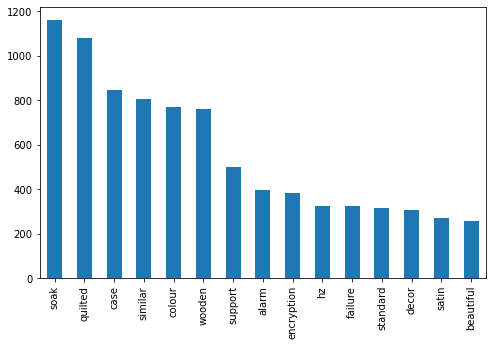

In [4417]:
df_hashvect_prod_spec.sum(axis=0).sort_values(ascending=False)[:15].plot.bar(figsize=(8,5))
plt.show()

### t-SNE visualization

In [4418]:
tsne_results = tsne.fit_transform(df_hashvect_prod_spec)
    
hashvect_tsne_prod_spec = pd.concat([pd.DataFrame(tsne_results), data_cleaned['prod_category1']], axis=1)
hashvect_tsne_prod_spec = hashvect_tsne_prod_spec.rename(columns={'prod_category1':'Category'})

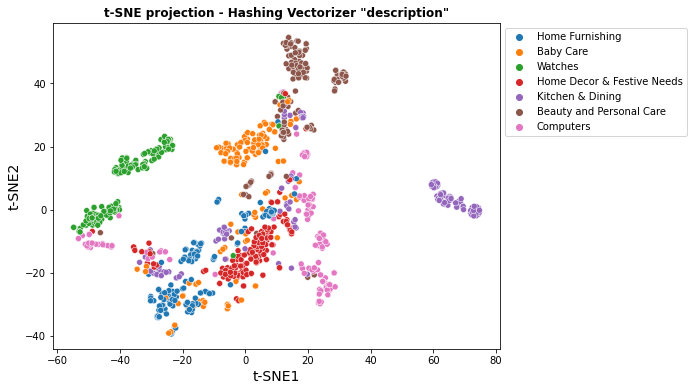

In [4419]:
title = 't-SNE projection - Hashing Vectorizer "description"'
tsne_visualisation(hashvect_tsne_prod_spec, title)

### t-SNE clustering

In [4420]:
data_type = 'hash_tsne_prod_spec'

In [4421]:
# Kmeans
tsne_hash_prod_spec = KMeans(n_clusters=7,
                      init='k-means++',
                      random_state=42).fit(hashvect_tsne_prod_spec.iloc[:, :2])
 
hashvect_tsne_prod_spec['cluster'] = tsne_hash_prod_spec.labels_
cluster_labels = tsne_hash_prod_spec.labels_
centres_reduced = tsne_hash_prod_spec.cluster_centers_

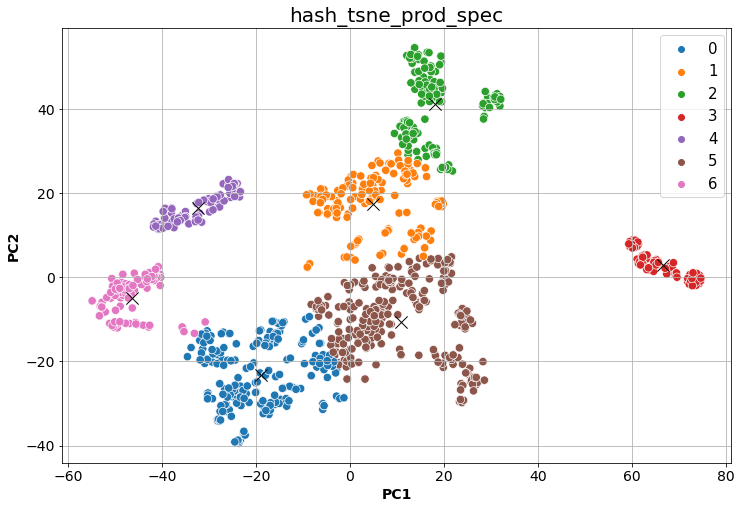

In [4422]:
display_clusters(tsne_results, cluster_labels, data_type)

Number of products per cluster:
0    586
3    202
4    153
1     43
6     29
2     28
5      9
Name: cluster, dtype: int64


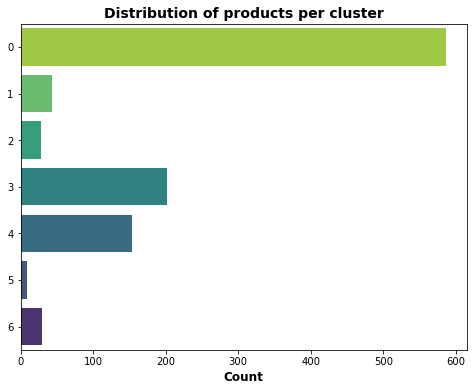

In [4423]:
cluster_distribution(df_pca_hashvect_desc)

### Clusters metrics

In [4424]:
# tSNE + HashingVectorizer on "product specifications" 
results33 = metrics_clusters(df_pca_hashvect_desc, data_type)
results3_3 = results3_2.append(results33, ignore_index=True)
results3_3

Methods       ARI  Homogeneity  Completness  V-Measure  \
0           cv_tsne_desc  0.434267     0.539155     0.550999   0.545013   
1            cv_pca_desc  0.012473     0.088224     0.280233   0.134199   
2            cv_lda_desc  0.308110     0.410171     0.440741   0.424907   
3      cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441   
4       cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979   
5       cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
6        tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059   
7         tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418   
8         tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115   
9         nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769   
10  tfidf_tsne_prod_spec  0.463240     0.593730     0.611894   0.602675   
11   tfidf_pca_prod_spec  0.252031     0.420270     0.540817   0.472983   
12        tfidf_lda_spec  0.395396     0.485369     0.612458   0.541557   
13   nmf_tfidf_prod_spec  0.634832     0.678816     0.694558   0.686597   
14        hash_tsne_desc  0.440361     0.536891     0.560014   0.548209   
15     hashvect_pca_desc  0.045396     0.115849     0.174661   0.139302   
16   hash_tsne_prod_spec  0.045396     0.115849     0.174661   0.139302   

         AMI  Fowlkes-Mallows  
0   0.540877         0.518467  
1   0.121070         0.339468  
2   0.419528         0.420823  
3   0.603839         0.537371  
4   0.415325         0.392403  
5   0.558853         0.549412  
6   0.565151         0.513588  
7   0.447585         0.369455  
8   0.384257         0.394524  
9   0.502177         0.512825  
10  0.599046         0.544357  
11  0.467561         0.417663  
12  0.536809         0.528432  
13  0.683746         0.689597  
14  0.544056         0.527908  
15  0.129474         0.270301  
16  0.129474         0.270301

### PCA analysis

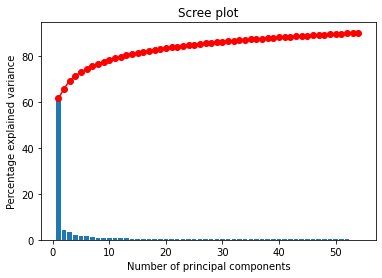

The number of principal components to keep to get 90% of the variance explained is: 54 


In [4425]:
pca = PCA(n_components = 0.90)
pca.fit(df_hashvect_prod_spec)
display_scree_plot(pca)
print("The number of principal components to keep to get 90% of the variance explained is: {} ".format(pca.n_components_))

In [4426]:
n_comp = pca.n_components_
pca_hash = PCA(n_components=n_comp)
X_proj_hashvect_prod_spec = pca_hash.fit_transform(df_hashvect_prod_spec)

# Dataframe creation for clustering
df_pca_hashvect_prod_spec = pd.DataFrame({'PC1': X_proj_hashvect_prod_spec[:, 0],
                                          'PC2': X_proj_hashvect_prod_spec[:, 1],
                                          'PC3': X_proj_hashvect_prod_spec[:, 2],
                                          'Category' : data_cleaned['prod_category1']})

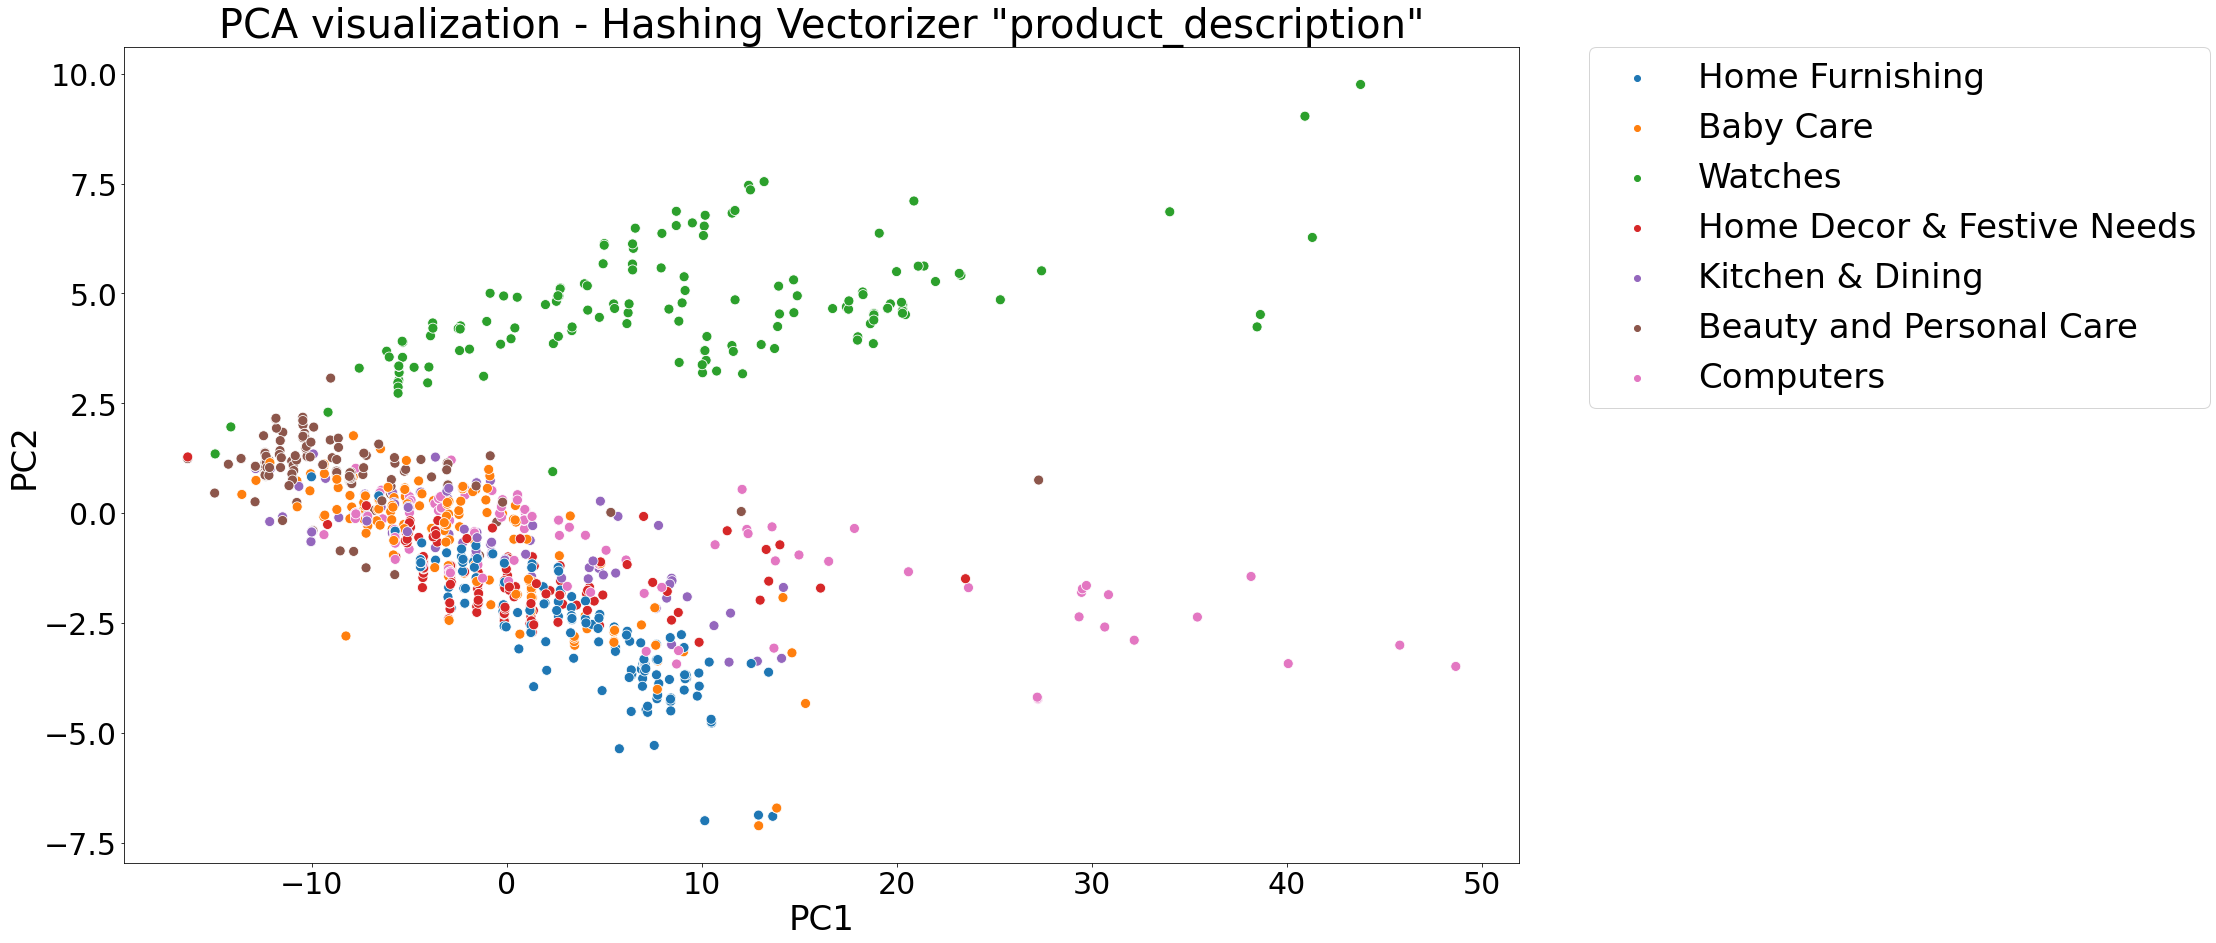

In [4427]:
# 2D PCA visualization
title = 'PCA visualization - Hashing Vectorizer "product_description"'
pca_visualization(data_cleaned, X_proj_hashvect_prod_spec, 'PC1', 'PC2', title)

In [4428]:
threed_pca(df_pca_hashvect_prod_spec)

### KMeans clustering on Hashing Vectorizer "product specifications"

In [4429]:
data_type = 'hashvect_pca_prod_spec'

In [4430]:
# Apply KMeans with optimum K
vars = ['PC1', 'PC2']
kmean = KMeans(n_clusters=7,
                  init='k-means++',
                  random_state=42).fit(df_pca_hashvect_prod_spec[vars])

df_pca_hashvect_prod_spec['cluster'] = kmean.labels_
cluster_labels = kmean.labels_
centres_reduced = kmean.cluster_centers_

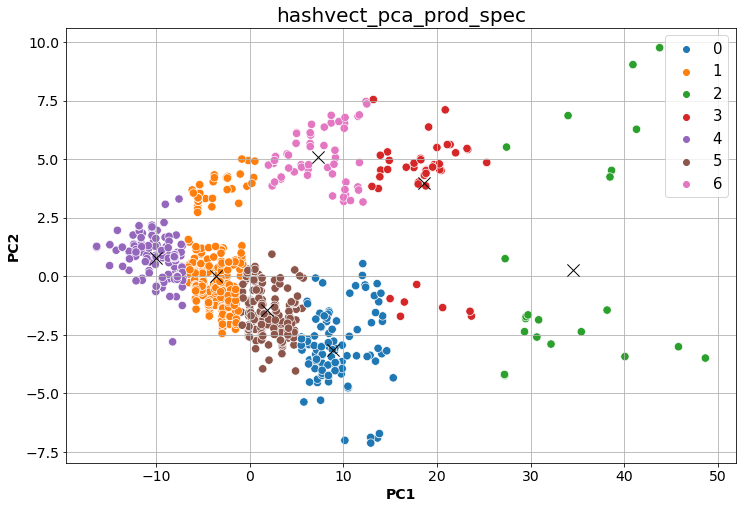

In [4431]:
display_clusters(X_proj_hashvect_prod_spec, cluster_labels, data_type)

In [4432]:
threed_clustering(df_pca_hashvect_prod_spec)

Number of products per cluster:
1    377
4    221
5    199
0    124
6     58
3     48
2     23
Name: cluster, dtype: int64


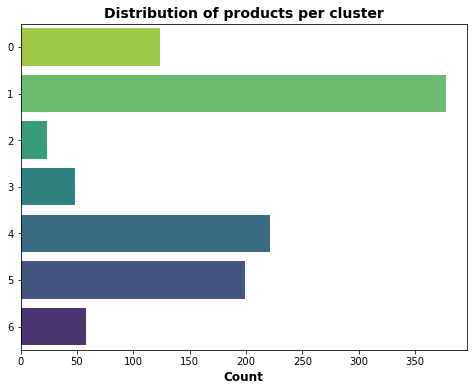

In [4433]:
cluster_distribution(df_pca_hashvect_prod_spec)

In [4434]:
df_pca_hashvect_prod_spec

PC1       PC2       PC3         Category  cluster
0     -2.976298 -1.689927 -0.444657  Home Furnishing        1
1      4.117724 -2.631412 -2.117561        Baby Care        5
2      4.023072 -2.337144 -1.470317        Baby Care        5
3     10.155136 -7.000119 -4.391779  Home Furnishing        0
4     13.640092 -6.899942 -3.598640  Home Furnishing        0
...         ...       ...       ...              ...      ...
1045  15.320340 -4.331668 -2.826197        Baby Care        0
1046   5.540787 -2.654462 -1.182886        Baby Care        0
1047  -2.954254 -2.441191 -1.146245        Baby Care        1
1048   5.530492 -2.667487 -1.112330        Baby Care        0
1049  -9.327574 -0.045880  0.174594        Baby Care        4

[1050 rows x 5 columns]

### Clusters metrics

In [4435]:
# PCA + HashingVectorizer on "product specifications" 
results34 = metrics_clusters(df_pca_hashvect_desc, data_type)
results3_4 = results3_3.append(results34, ignore_index=True)
results3_4

Methods       ARI  Homogeneity  Completness  V-Measure  \
0             cv_tsne_desc  0.434267     0.539155     0.550999   0.545013   
1              cv_pca_desc  0.012473     0.088224     0.280233   0.134199   
2              cv_lda_desc  0.308110     0.410171     0.440741   0.424907   
3        cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441   
4         cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979   
5         cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
6          tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059   
7           tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418   
8           tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115   
9           nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769   
10    tfidf_tsne_prod_spec  0.463240     0.593730     0.611894   0.602675   
11     tfidf_pca_prod_spec  0.252031     0.420270     0.540817   0.472983   
12          tfidf_lda_spec  0.395396     0.485369     0.612458   0.541557   
13     nmf_tfidf_prod_spec  0.634832     0.678816     0.694558   0.686597   
14          hash_tsne_desc  0.440361     0.536891     0.560014   0.548209   
15       hashvect_pca_desc  0.045396     0.115849     0.174661   0.139302   
16     hash_tsne_prod_spec  0.045396     0.115849     0.174661   0.139302   
17  hashvect_pca_prod_spec  0.045396     0.115849     0.174661   0.139302   

         AMI  Fowlkes-Mallows  
0   0.540877         0.518467  
1   0.121070         0.339468  
2   0.419528         0.420823  
3   0.603839         0.537371  
4   0.415325         0.392403  
5   0.558853         0.549412  
6   0.565151         0.513588  
7   0.447585         0.369455  
8   0.384257         0.394524  
9   0.502177         0.512825  
10  0.599046         0.544357  
11  0.467561         0.417663  
12  0.536809         0.528432  
13  0.683746         0.689597  
14  0.544056         0.527908  
15  0.129474         0.270301  
16  0.129474         0.270301  
17  0.129474         0.270301

### LDA

In [4436]:
data_type = 'hash_lda_prod_spec'

In [4437]:
# Model initialisation
hash_lda_prod_spec = LatentDirichletAllocation(n_components=7,
                                          max_iter=10,
                                          learning_method='online',
                                          learning_offset=50,
                                          random_state=42,
                                          n_jobs=-1)
# Model training
hash_lda_prod_spec.fit(X_matrix_spec)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          n_components=7, n_jobs=-1, random_state=42)

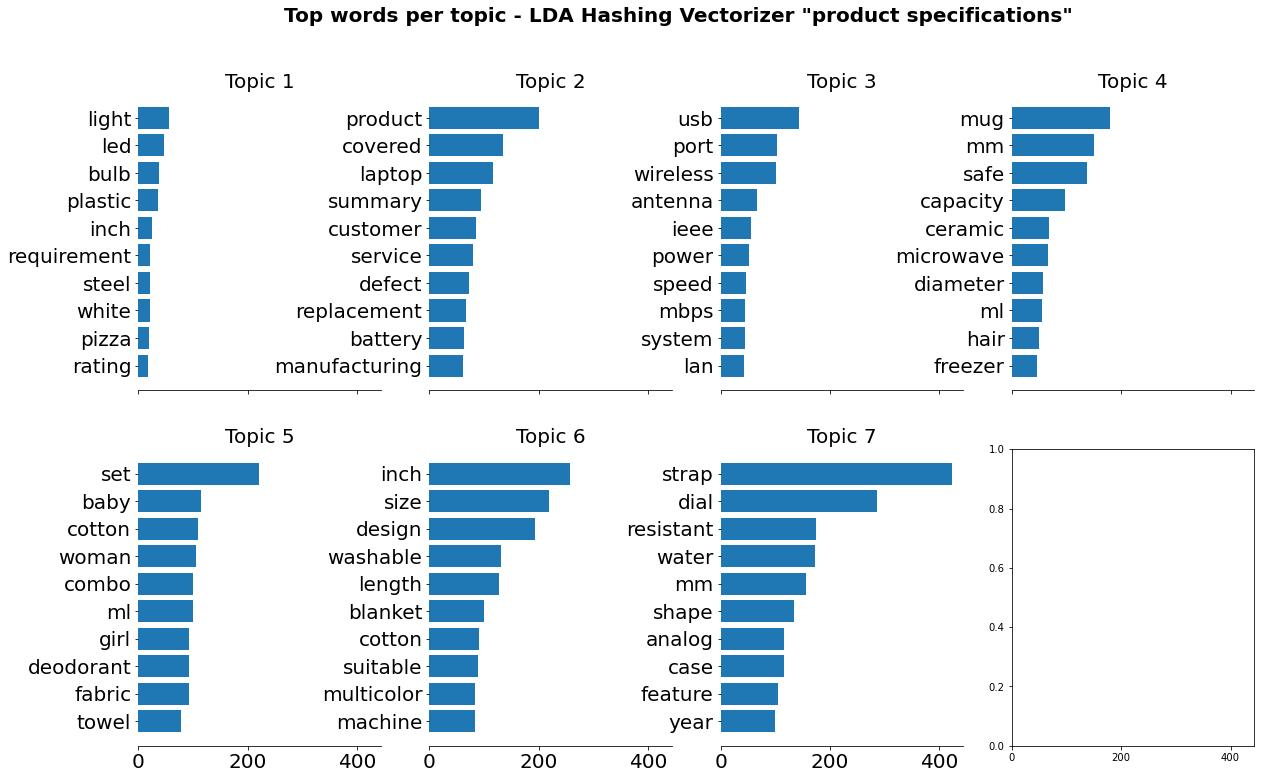

In [4438]:
# Most frequent words appearing in the different topics
n_top_words = 10
lda_hash_spec_feature_names = matrix_spec.get_feature_names()

top_words_display(hash_lda_prod_spec, lda_hash_spec_feature_names,
                  n_top_words,
                  'Top words per topic - LDA Hashing Vectorizer "product specifications"')

In [4439]:
# Descriptions
lda_hash_spec_top = hash_lda_prod_spec.transform(X_matrix_spec)

# Dataframe creation
df_topics = pd.DataFrame(lda_hash_spec_top, columns=topics_name)

df_topics['Topics'] = np.argmax(df_topics.values, axis=1)
df_topics['Category'] = data_cleaned['prod_category1']
# Topics
df_topics.groupby('Topics')['Category'].value_counts(). \
    to_frame()

Category
Topics Category                            
0      Kitchen & Dining                  22
       Computers                         20
       Home Decor & Festive Needs        17
       Beauty and Personal Care          11
       Watches                            5
       Baby Care                          2
1      Computers                         51
       Home Decor & Festive Needs         8
       Baby Care                          4
       Kitchen & Dining                   4
       Beauty and Personal Care           3
2      Computers                         75
       Beauty and Personal Care           1
3      Kitchen & Dining                 109
       Beauty and Personal Care           5
       Baby Care                          3
       Home Decor & Festive Needs         2
       Computers                          1
4      Beauty and Personal Care         121
       Baby Care                        109
       Home Furnishing                   15
       Home Decor & Festive Needs        12
       Kitchen & Dining                  12
5      Home Furnishing                  135
       Baby Care                         32
       Home Decor & Festive Needs        16
       Beauty and Personal Care           4
       Computers                          2
       Kitchen & Dining                   1
6      Watches                          145
       Home Decor & Festive Needs        95
       Beauty and Personal Care           5
       Kitchen & Dining                   2
       Computers                          1

<AxesSubplot:xlabel='row_0'>

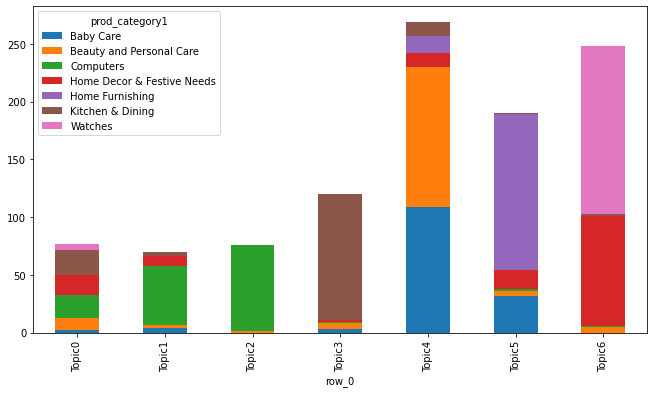

In [4440]:
lda_topic = pd.DataFrame(hash_lda_prod_spec.transform(X_matrix_spec),
                             columns=topics_name)
lda_best_topic = lda_topic.idxmax(axis=1)
pd.crosstab(lda_best_topic, data_cleaned['prod_category1']).plot.bar(figsize=(11,6), stacked=True)

In [4443]:
results_hash_spec = metrics_clusters_lda(df_topics, data_type)
results34 = results3_4.append(results_hash_spec, ignore_index=True)
results34.reset_index(drop=True)
final_results = results34.sort_values(by='ARI', ascending=False)
final_results

Methods       ARI  Homogeneity  Completness  V-Measure  \
13     nmf_tfidf_prod_spec  0.634832     0.678816     0.694558   0.686597   
10    tfidf_tsne_prod_spec  0.463240     0.593730     0.611894   0.602675   
18      hash_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
5         cv_lda_prod_spec  0.459110     0.543161     0.584214   0.562940   
3        cv_tsne_prod_spec  0.452310     0.595859     0.619482   0.607441   
14          hash_tsne_desc  0.440361     0.536891     0.560014   0.548209   
0             cv_tsne_desc  0.434267     0.539155     0.550999   0.545013   
6          tfidf_tsne_desc  0.429387     0.564148     0.574056   0.569059   
9           nmf_tfidf_desc  0.419666     0.491502     0.523014   0.506769   
12          tfidf_lda_spec  0.395396     0.485369     0.612458   0.541557   
2              cv_lda_desc  0.308110     0.410171     0.440741   0.424907   
8           tfidf_lda_desc  0.260426     0.367522     0.415668   0.390115   
11     tfidf_pca_prod_spec  0.252031     0.420270     0.540817   0.472983   
4         cv_pca_prod_spec  0.157370     0.343946     0.545810   0.421979   
7           tfidf_pca_desc  0.154887     0.387813     0.545739   0.453418   
15       hashvect_pca_desc  0.045396     0.115849     0.174661   0.139302   
16     hash_tsne_prod_spec  0.045396     0.115849     0.174661   0.139302   
17  hashvect_pca_prod_spec  0.045396     0.115849     0.174661   0.139302   
1              cv_pca_desc  0.012473     0.088224     0.280233   0.134199   

         AMI  Fowlkes-Mallows  
13  0.683746         0.689597  
10  0.599046         0.544357  
18  0.558853         0.549412  
5   0.558853         0.549412  
3   0.603839         0.537371  
14  0.544056         0.527908  
0   0.540877         0.518467  
6   0.565151         0.513588  
9   0.502177         0.512825  
12  0.536809         0.528432  
2   0.419528         0.420823  
8   0.384257         0.394524  
11  0.467561         0.417663  
4   0.415325         0.392403  
7   0.447585         0.369455  
15  0.129474         0.270301  
16  0.129474         0.270301  
17  0.129474         0.270301  
1   0.121070         0.339468

In [4442]:
tm = time.time() - start_time
print('Total running time (sec):', tm)

Total running time (sec): 87.31625199317932


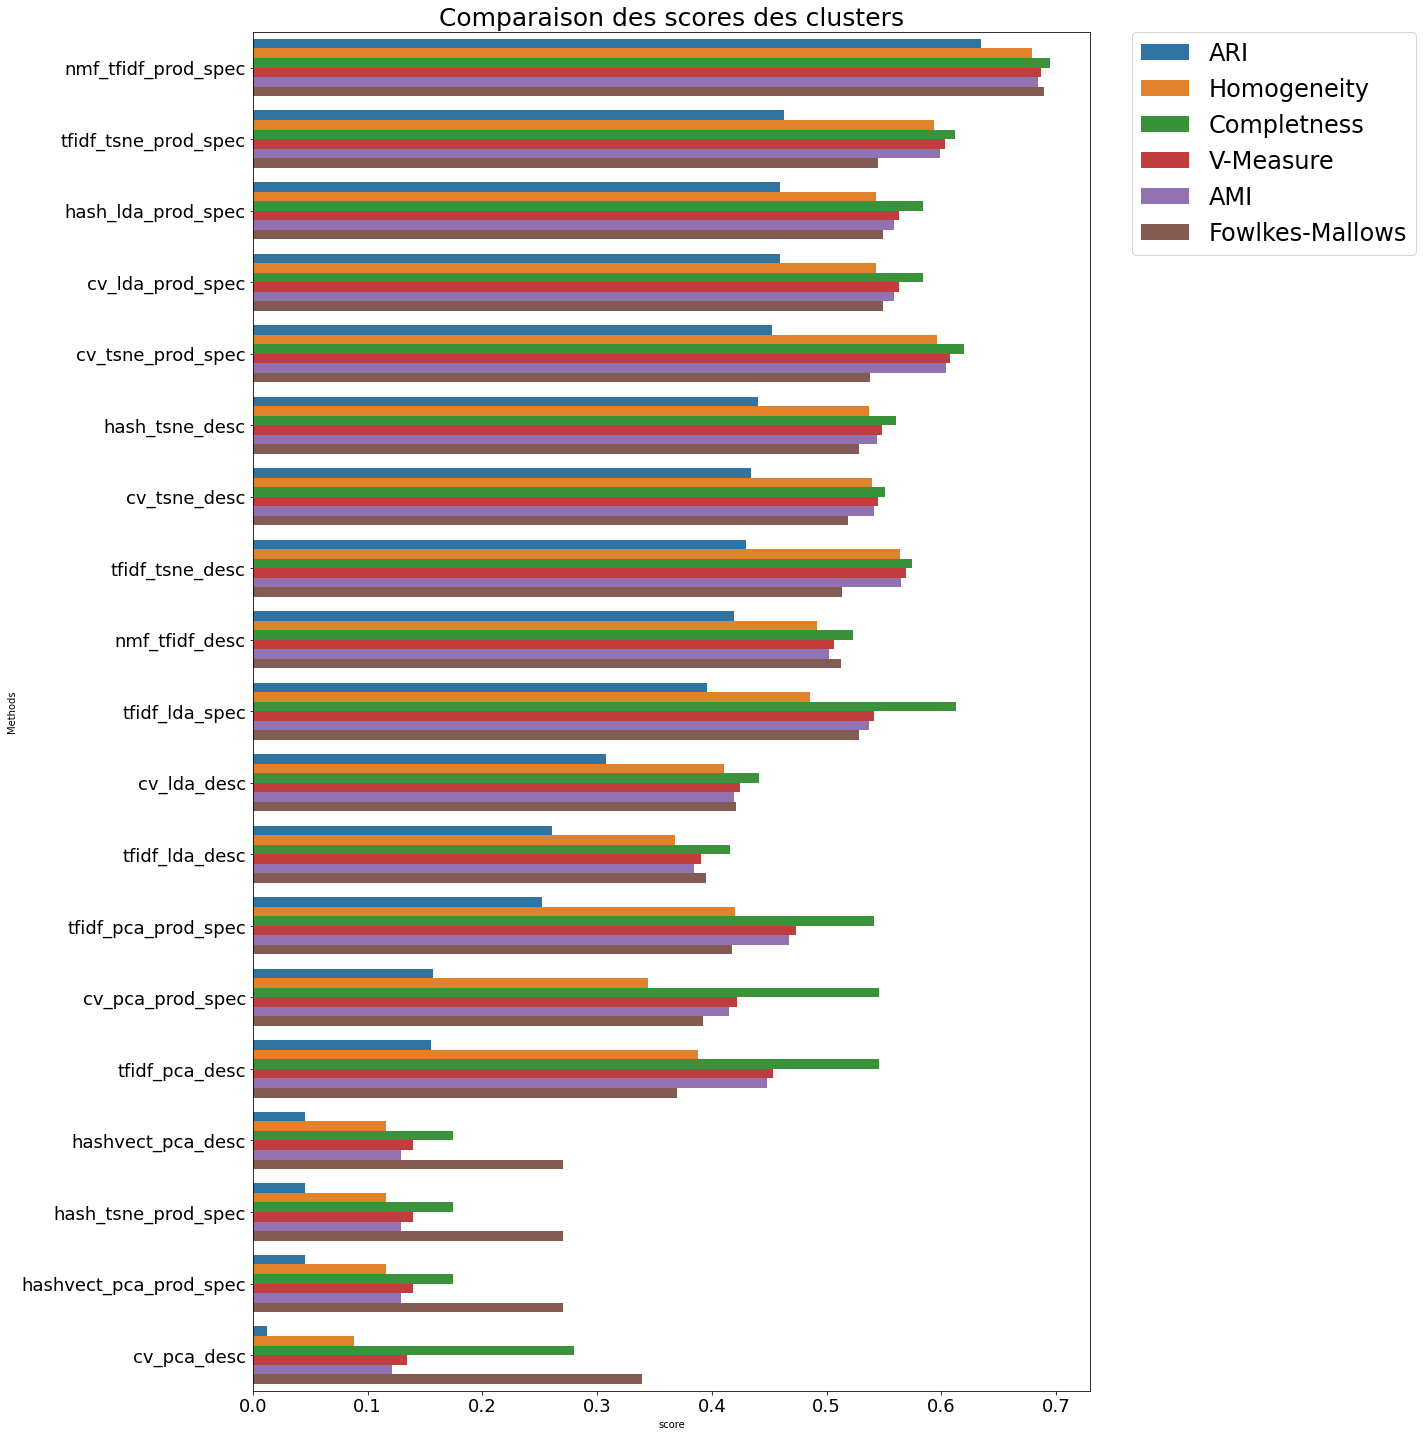

In [4454]:
# Comparaison visuelle des algorithmes
# df_comp_sort = df_comparaison.sort_values(by='ARI', ascending=False)
comparaison_score_melt = pd.melt(final_results, id_vars=['Methods'],
                                 value_name='score',
                                 value_vars=['ARI', 'Homogeneity',
                                             'Completness', 'V-Measure',
                                            'AMI', 'Fowlkes-Mallows'])
# Visualisation
plt.figure(figsize=(15, 25))
sns.barplot(y=comparaison_score_melt['Methods'],
            x=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'],
            palette='tab10')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Comparaison des scores des clusters', fontsize=25)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.show()

### Word2Vec

Genism word2vec requires that a format of ‘list of lists’ for training where every document is contained in a list and every list contains lists of tokens of that document.

In [3725]:
# Description Lemmatisée word2vec a besoin d'une liste de liste
data_vec = data_cleaned['description_clean']
data_cleaned['description_token'] = \
    [word_tokenize(str(row)) for row in
     data_vec]
data_token = data_cleaned['description_token'].copy()
text_dim = 30
# Compte le nombre de coeur du processeur
cores = multiprocessing.cpu_count()

In [3726]:
# Instanciation du modèle
w2v_model_desc_lem = Word2Vec(min_count=20, window=3, vector_size=text_dim,
                              sample=6e-5, alpha=0.03, min_alpha=0.0007,
                              negative=20, workers=cores-1)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_model_desc_lem.build_vocab(data_token,
                               progress_per=10000)
# Entraînement du modèle
w2v_model_desc_lem.train(data_token,
                         total_examples=w2v_model_desc_lem.corpus_count,
                         epochs=30, report_delay=1)
# Vectorisation
vector_w2v_desc_lem = word2vec_vectorisation(data_vec,
                                             text_dim,
                                             w2v_model_desc_lem)
# Dataframe pour réduction de dimension
df_w2v_desc_lem = pd.DataFrame(vector_w2v_desc_lem)

TypeError: 'Word2Vec' object is not subscriptable

__vector_size__: The number of dimensions of the embeddings and the default is 100.<br>
__window__: The maximum distance between a target word and words around the target word. The default window is 5.<br>
__min_count__: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.<br>
__workers__: The number of partitions during training and the default workers is 3.<br>
__sg__: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.<br>

### SUMMARY t-SNE Visualization

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))

sns.scatterplot(x=0, y=1, hue='prod_category1', data=tsne_df, ax=axes[0, 0])
axes[0, 0].set_title('t-SNE projection - CountVectorizer', fontsize=18, weight='bold')
# ax.legend(bbox_to_anchor=(1, 1))
axes[0, 0].set_xlabel('t-SNE 1', weight='bold', size=14)
axes[0, 0].set_ylabel('t-SNE 2', weight='bold', size=14)

sns.scatterplot(x=0, y=1, hue='prod_category1', data=tsne_df_tfid, ax=axes[0, 1])
axes[0, 1].set_title('t-SNE projection - TfidVectorizer', fontsize=18, weight='bold')
# ax.legend(bbox_to_anchor=(1, 1))
axes[0, 1].set_xlabel('t-SNE 1', weight='bold', size=14)
axes[0, 1].set_ylabel('t-SNE 2', weight='bold', size=14)

sns.scatterplot(x=0, y=1, hue='prod_category1', data=tsne_df_hashvec, ax=axes[1, 0])
axes[1, 0].set_title('t-SNE projection - HashingVectorizer', fontsize=18, weight='bold')
# ax.legend(bbox_to_anchor=(1, 1))
axes[1, 0].set_xlabel('t-SNE 1', weight='bold', size=14)
axes[1, 0].set_ylabel('t-SNE 2', weight='bold', size=14)

plt.show()

In [ ]:
data_type = 'cv_pca_desc'

In [ ]:
ssel, dbl, chl, slcl = [], [], [], []
for k in range(2, 30):
    kmean = KMeans(n_clusters=k, max_iter=50, random_state=10)
    start_time = time.time()
    kmean.fit(df_countvect_desc)
    cluster_labels = kmean.labels_
    time.time() - start_time

    # Elbow method
    ssel.append(kmean.inertia_)

    # Davies-Bouldin index
    db_avg = davies_bouldin_score(df_countvect_desc, cluster_labels)
    dbl.append(db_avg)

    # Calinski-Harabasz
    ch_avg = calinski_harabasz_score(df_countvect_desc, cluster_labels)
    chl.append(ch_avg)

    # Silhouette profile
    silhouette_avg = silhouette_score(df_countvect_desc, cluster_labels)
    slcl.append(silhouette_avg)

In [ ]:
# Creation of a dict to keep the different metrics
metrics = {"ssel": ssel,
            "dbl": dbl,
            "chl": chl,
            "slcl": slcl}

In [ ]:
def cluster_selection(range_n_clusters, metrics):
    """
    Display 4 plots: Elbow method, Davies-Bouldin Index
    Calinski-Harabsz & Silhouette score
    vs number of clusters

    Parameters:
    metrics: Dict of metrics results
    range_n_clusters: Number of clusters observed
    """

    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle("Selection of optimal number of clusters",
                 fontsize=18, weight='bold', size=20)

    # Display inertia v clusters number
    axs[0, 0].plot(range_n_clusters, metrics["ssel"])
    axs[0, 0].set_title('Elbow graph', weight='bold', size=14)
    axs[0, 0].set(xlabel='Clusters number', ylabel='Inertia')

    # Display of Davies-Bouldin index v clusters number
    axs[0, 1].plot(range_n_clusters, metrics["dbl"])
    axs[0, 1].set_title("Davies-Bouldin Index", weight='bold', size=14)
    axs[0, 1].set(xlabel='Clusters number', ylabel='Davies-Bouldin Index')

    # Display of Calinski-Harabasz index v clusters number
    # plt.subplot(132)
    axs[1, 0].plot(range_n_clusters, metrics["chl"])
    axs[1, 0].set_title("Calinski-Harabasz Index", weight='bold', size=14)
    axs[1, 0].set(xlabel='Clusters number', ylabel='Calinski-Harabasz Index')

    # Display silhouette score v clusters number
    axs[1, 1].plot(range_n_clusters, metrics["slcl"])
    axs[1, 1].set_title("Silhouette profile", weight='bold', size=14)
    axs[1, 1].set(xlabel="Clusters number", ylabel="Silhouette Score")

    plt.show()

In [ ]:
range_n_clusters = range(2, 30)
cluster_selection(range_n_clusters, metrics)

## Word2Vec

Word2vec is an efficient predictive model for learning word embeddings from raw text. It comes in two models: the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model. Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words.

The easiest way to think about word2vec is that it figures out how to place words on a graph in such a way that their location is determined by their meaning. In other words, words with similar meanings will be clustered together. More interestingly, though, is that the gaps and distances on the graph have meaning as well. 

The parameters:
min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
size = int - Dimensionality of the feature vectors. - (50, 300)
sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
alpha = float - The initial learning rate - (0.01, 0.05)
min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [ ]:
# Description Lemmatisée word2vec a besoin d'une liste de liste
data_vec = data_cleaned['description_clean']
data_cleaned['description_token'] = \
    [word_tokenize(str(row)) for row in
     data_vec]
data_token = data_cleaned['description_token'].copy()

In [ ]:
data_token

In [ ]:
text_dim = 30

In [ ]:
# Instanciation du modèle
w2v_desc = Word2Vec(min_count=20,
                    window=3,
                    size=text_dim,
                    sample=6e-5,
                    alpha=0.03,
                    min_alpha=0.0007,
                    negative=20,
                    workers=cores-1)

# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_desc.build_vocab(data_token,
                         progress_per=10000)

# Entraînement du modèle
w2v_desc.train(data_token,
               total_examples=w2v_desc.corpus_count,
               epochs=30, report_delay=1)

# Vectorisation
vector_w2v_desc = outils_nlp.word2vec_vectorisation(data_vec,
                                                        text_dim,
                                                        w2v_model_desc_lem)
# Dataframe pour réduction de dimension
df_w2v_desc_lem = pd.DataFrame(vector_w2v_desc_lem)

In [ ]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features, dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec, model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [ ]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(descriptions, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(descriptions), num_features),dtype="float32")
    for description in descriptions:            
        reviewFeatureVecs[counter] = featureVecMethod(description, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

### IMAGES

In [ ]:
categories = data_cat["prod_category1"]

In [ ]:
fig, ax = plt.subplots(4, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, kind in enumerate(categories.unique()) :
    name_image = data_cat[categories == kind]["image"].iloc[100]
    img = plt.imread(directory + "Images/" + name_image)
    ax[i%4, i//4].set_title(kind)
    ax[i%4, i//4].imshow(img)
  
plt.show()